In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing
from sklearn import impute

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
imputer = impute.SimpleImputer(strategy="median")
imputer.fit(train[input_cols])
train[input_cols] = imputer.transform(train[input_cols])
test[input_cols] = imputer.transform(test[input_cols])

scaler = preprocessing.MaxAbsScaler()
scaler.fit(train[input_cols])
train[input_cols] = scaler.transform(train[input_cols])
test[input_cols] = scaler.transform(test[input_cols])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
#balance_method = "weight"
balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,

    'linear_tree':True,
    #'boosting':'dart',

    #'max_bin': 63,
    #'num_leaves': 7,
    
    #'pos_bagging_fraction': 1,
    #'neg_bagging_fraction': 0.21218074656188604,
    
    #'feature_fraction': 0.75,
    #'lambda_l1': 0.00020196676966216634,
    #'lambda_l2': 2.3627262174517976e-09,
    #'min_data_in_leaf': 13,
    #'min_gain_to_split': 0.0007626326850799573,
    #'num_iterations': 1591,
    #'path_smooth': 2.652521741711401e-09,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'linear_tree': True,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [8]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 4, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 3000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.4, 1.0, step=0.05),
        #bagging_fraction = trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.01),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 50),
        
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-10, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),

        # linear tree regularization parameter
        linear_lambda = trial.suggest_float("linear_lambda", 1e-10, 1e1, log=True),
        
        # dart
        #drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        #skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [9]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 7min 2s, sys: 5.52 s, total: 7min 7s
Wall time: 54.3 s


(0.29030632377487836, 0.15746220638484598)

In [10]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-linear-bagging-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-linear-bagging-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-06-27 03:03:30,614] Using an existing study with name 'iarc-lgbm-linear-bagging-balanced' instead of creating a new one.


[I 2023-06-27 03:05:27,389] Trial 3 finished with value: 0.310284934527542 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.4102153962898166e-06, 'lambda_l2': 1.7970830113374573e-07, 'linear_lambda': 0.00037611751286439237, 'max_bin_exp': 6, 'min_data_in_leaf': 8, 'min_gain_to_split': 5.921853187714195e-07, 'num_iterations': 2181, 'num_leaves_exp': 5, 'path_smooth': 2.2769023006331284e-06}. Best is trial 1 with value: 0.2457644367640038.


[I 2023-06-27 03:06:02,974] Trial 4 finished with value: 0.24526110935154136 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.11033908152564369, 'lambda_l2': 1.958372683532392e-07, 'linear_lambda': 9.184391531388216e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 37, 'min_gain_to_split': 1.4992457970942095, 'num_iterations': 2318, 'num_leaves_exp': 5, 'path_smooth': 0.24826614986519802}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:06:42,165] Trial 5 finished with value: 0.25708350402345403 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.07117964167213248, 'lambda_l2': 6.22274805714534e-08, 'linear_lambda': 7.85645958841113e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 11, 'min_gain_to_split': 9.802137413342136e-05, 'num_iterations': 2231, 'num_leaves_exp': 2, 'path_smooth': 4.691797519462158e-06}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:07:43,603] Trial 6 finished with value: 0.2742978100403657 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0006973532593861001, 'lambda_l2': 8.95109708754699e-06, 'linear_lambda': 6.281724657708758e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.864371626133676e-10, 'num_iterations': 2627, 'num_leaves_exp': 5, 'path_smooth': 2.0520258228985714e-10}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:08:20,178] Trial 7 finished with value: 0.2520452825948232 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.007171843050434463, 'lambda_l2': 1.0682205186775884, 'linear_lambda': 0.005126104811030018, 'max_bin_exp': 7, 'min_data_in_leaf': 44, 'min_gain_to_split': 6.049753307974152e-05, 'num_iterations': 2242, 'num_leaves_exp': 2, 'path_smooth': 6.502041642025301e-08}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:08:45,184] Trial 8 finished with value: 0.2666002649041019 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 5.531837111760819e-10, 'lambda_l2': 2.426187630368275e-08, 'linear_lambda': 6.900992602231978e-08, 'max_bin_exp': 4, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.2781686534428482, 'num_iterations': 1931, 'num_leaves_exp': 2, 'path_smooth': 9.100002193070542e-05}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:09:52,659] Trial 9 finished with value: 0.27696034577847306 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.00038405300679717375, 'lambda_l2': 2.207621198455544e-07, 'linear_lambda': 5.434026079922686e-10, 'max_bin_exp': 8, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.0701636447610978e-09, 'num_iterations': 2749, 'num_leaves_exp': 5, 'path_smooth': 2.3037549051212538e-10}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:10:34,372] Trial 10 finished with value: 0.2531880033589698 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 6.699753348950782e-07, 'lambda_l2': 2.812262763765455e-08, 'linear_lambda': 1.3750592420337892e-10, 'max_bin_exp': 8, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.001628673656057375, 'num_iterations': 2395, 'num_leaves_exp': 2, 'path_smooth': 0.00014440789122427945}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:10:50,084] Trial 11 finished with value: 0.4535678258495499 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.140426032600014, 'lambda_l2': 1.2030126935303258e-10, 'linear_lambda': 0.7978204312296441, 'max_bin_exp': 4, 'min_data_in_leaf': 50, 'min_gain_to_split': 6.463422461101543, 'num_iterations': 1690, 'num_leaves_exp': 4, 'path_smooth': 1.9947862156816836}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:11:10,130] Trial 12 finished with value: 0.3894859027414956 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.895743165983019, 'lambda_l2': 0.007518537025550818, 'linear_lambda': 4.80535090842547e-06, 'max_bin_exp': 7, 'min_data_in_leaf': 36, 'min_gain_to_split': 0.04578029741049209, 'num_iterations': 1735, 'num_leaves_exp': 3, 'path_smooth': 0.049548707587950616}. Best is trial 4 with value: 0.24526110935154136.


[I 2023-06-27 03:12:00,338] Trial 13 finished with value: 0.24081538040447184 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.18640268436258103, 'lambda_l2': 0.001401848225022548, 'linear_lambda': 2.2485571571385846e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.023959332585450525, 'num_iterations': 2924, 'num_leaves_exp': 3, 'path_smooth': 0.005081797088803007}. Best is trial 13 with value: 0.24081538040447184.


[I 2023-06-27 03:12:48,995] Trial 14 finished with value: 0.24015985203188084 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.1509193981532533, 'lambda_l2': 0.00010449661296843145, 'linear_lambda': 3.922693388855578e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 37, 'min_gain_to_split': 0.1583714916381094, 'num_iterations': 2921, 'num_leaves_exp': 4, 'path_smooth': 0.007600708020804966}. Best is trial 14 with value: 0.24015985203188084.


[I 2023-06-27 03:13:36,297] Trial 15 finished with value: 0.23963362447375353 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2260238268185644, 'lambda_l2': 0.000598698961184033, 'linear_lambda': 3.818862483456087e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 37, 'min_gain_to_split': 0.03623451217445396, 'num_iterations': 2843, 'num_leaves_exp': 3, 'path_smooth': 0.006894349446927627}. Best is trial 15 with value: 0.23963362447375353.


[I 2023-06-27 03:14:19,688] Trial 16 finished with value: 0.24591542379839987 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.5101201560186457, 'lambda_l2': 0.00019889627759442892, 'linear_lambda': 0.00022398456431803974, 'max_bin_exp': 5, 'min_data_in_leaf': 43, 'min_gain_to_split': 0.0775817680702675, 'num_iterations': 2954, 'num_leaves_exp': 4, 'path_smooth': 0.002148462008737697}. Best is trial 15 with value: 0.23963362447375353.


[I 2023-06-27 03:15:02,158] Trial 17 finished with value: 0.23811160588708835 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.006735265051733459, 'lambda_l2': 0.02842376443588463, 'linear_lambda': 5.790438580531664e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.0043318704761398825, 'num_iterations': 2621, 'num_leaves_exp': 4, 'path_smooth': 2.925175264771294}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:15:36,783] Trial 18 finished with value: 0.25454217765025516 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.004092246150502939, 'lambda_l2': 0.046772243432961415, 'linear_lambda': 0.00021673734857087694, 'max_bin_exp': 4, 'min_data_in_leaf': 44, 'min_gain_to_split': 0.005848664091560775, 'num_iterations': 2566, 'num_leaves_exp': 3, 'path_smooth': 5.8662647406544774}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:15:56,193] Trial 19 finished with value: 0.28755117766967137 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00748677530718271, 'lambda_l2': 0.026345784778485645, 'linear_lambda': 0.011274659440681572, 'max_bin_exp': 5, 'min_data_in_leaf': 50, 'min_gain_to_split': 0.001515246790944934, 'num_iterations': 1315, 'num_leaves_exp': 4, 'path_smooth': 0.3055966534218091}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:16:36,701] Trial 20 finished with value: 0.24634222091824537 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.41488432281303717, 'lambda_l2': 7.946012804171958, 'linear_lambda': 1.1440613242424644e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.16318480771695457, 'num_iterations': 2544, 'num_leaves_exp': 3, 'path_smooth': 0.8952897959223899}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:17:03,426] Trial 21 finished with value: 0.3459435005272091 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.200323017038663, 'lambda_l2': 0.0012249769883965786, 'linear_lambda': 0.006177914701617269, 'max_bin_exp': 4, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0006599100962226375, 'num_iterations': 2701, 'num_leaves_exp': 4, 'path_smooth': 7.540102355797956}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:17:50,909] Trial 22 finished with value: 0.23960197123766835 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.039674190897596405, 'lambda_l2': 4.1667359552423316e-05, 'linear_lambda': 2.4793074345461947e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.3602788636593098, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.017136882979767076}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:18:33,254] Trial 23 finished with value: 0.24047088325324253 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.033809005905803304, 'lambda_l2': 9.278023403787646e-06, 'linear_lambda': 4.643802372342908e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 42, 'min_gain_to_split': 0.7314574059321552, 'num_iterations': 2797, 'num_leaves_exp': 4, 'path_smooth': 0.05535203134350517}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:19:19,887] Trial 24 finished with value: 0.2404990814165285 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.8893352190424026, 'lambda_l2': 0.002315390625456985, 'linear_lambda': 1.2601949256400083e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.012953812028707346, 'num_iterations': 3000, 'num_leaves_exp': 3, 'path_smooth': 0.0007769201410275287}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:19:53,080] Trial 25 finished with value: 0.2518381715603627 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.02297232801424717, 'lambda_l2': 0.09399117318013439, 'linear_lambda': 1.9434083582638725e-05, 'max_bin_exp': 4, 'min_data_in_leaf': 47, 'min_gain_to_split': 0.36904499765897136, 'num_iterations': 2460, 'num_leaves_exp': 4, 'path_smooth': 0.027869413957989222}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:20:22,922] Trial 26 finished with value: 0.34157084243033453 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.5466264838672727, 'lambda_l2': 0.0002153405594368954, 'linear_lambda': 0.0009425435861812404, 'max_bin_exp': 6, 'min_data_in_leaf': 32, 'min_gain_to_split': 7.057231513104238, 'num_iterations': 2789, 'num_leaves_exp': 3, 'path_smooth': 0.5080333925651641}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:20:55,865] Trial 27 finished with value: 0.23830774633481497 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.002005567226790924, 'lambda_l2': 0.010579016778028368, 'linear_lambda': 1.0351948871667175e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.01025816250340501, 'num_iterations': 1992, 'num_leaves_exp': 4, 'path_smooth': 0.07740395889599337}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:21:26,545] Trial 28 finished with value: 0.2455914796339742 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0006402496846620675, 'lambda_l2': 0.007995865055761196, 'linear_lambda': 3.3094567443883553e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 46, 'min_gain_to_split': 0.007267087746186663, 'num_iterations': 1967, 'num_leaves_exp': 5, 'path_smooth': 0.13829258832154714}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:21:52,481] Trial 29 finished with value: 0.25241594293189235 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0015976893112049815, 'lambda_l2': 0.258948449357604, 'linear_lambda': 6.914221138821296e-07, 'max_bin_exp': 4, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.31106975728212716, 'num_iterations': 1787, 'num_leaves_exp': 4, 'path_smooth': 1.8353308729268294}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:22:19,265] Trial 30 finished with value: 0.2453389223424385 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 9.842188219992144e-05, 'lambda_l2': 0.3447118550938675, 'linear_lambda': 4.3542860619345433e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.9043575677484209, 'num_iterations': 1456, 'num_leaves_exp': 4, 'path_smooth': 8.327530867299915}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:22:36,812] Trial 31 finished with value: 0.2724350391390381 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.017669281384323145, 'lambda_l2': 0.01210422550727158, 'linear_lambda': 7.335498087139455e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.0003737649230336355, 'num_iterations': 1002, 'num_leaves_exp': 4, 'path_smooth': 0.022885907619682504}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:23:26,376] Trial 32 finished with value: 0.2412072187393153 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.004688825230987282, 'lambda_l2': 0.0726334691436696, 'linear_lambda': 5.982607763490099e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.026983158611782833, 'num_iterations': 2829, 'num_leaves_exp': 4, 'path_smooth': 0.0011220541736169432}. Best is trial 17 with value: 0.23811160588708835.


[I 2023-06-27 03:24:04,546] Trial 33 finished with value: 0.23566129185626913 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.046889967064221626, 'lambda_l2': 0.0007728851650701874, 'linear_lambda': 1.3510785329214586e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.07498191514713323, 'num_iterations': 2078, 'num_leaves_exp': 3, 'path_smooth': 0.012440325198911176}. Best is trial 33 with value: 0.23566129185626913.


[I 2023-06-27 03:24:42,161] Trial 34 finished with value: 0.2350831567167681 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.3508216557144285e-05, 'lambda_l2': 0.003162259428819373, 'linear_lambda': 9.29519024428715e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.004635595506432329, 'num_iterations': 2039, 'num_leaves_exp': 3, 'path_smooth': 0.12038418050622257}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:25:22,795] Trial 35 finished with value: 0.23598911897792876 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.486861878103127e-05, 'lambda_l2': 0.005096116712250214, 'linear_lambda': 3.4945886262969505e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.005673255042402224, 'num_iterations': 2067, 'num_leaves_exp': 3, 'path_smooth': 0.22544400866019296}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:26:03,707] Trial 36 finished with value: 0.23607192018470957 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5517804372155506e-05, 'lambda_l2': 0.0030799595109443027, 'linear_lambda': 2.352937907053877e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 32, 'min_gain_to_split': 9.380758982450387e-06, 'num_iterations': 2095, 'num_leaves_exp': 3, 'path_smooth': 0.2713859525696918}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:26:47,286] Trial 37 finished with value: 0.23818442796417677 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.151212210354279e-05, 'lambda_l2': 0.0022889936269179056, 'linear_lambda': 2.9930031708743463e-07, 'max_bin_exp': 7, 'min_data_in_leaf': 32, 'min_gain_to_split': 4.25335912590125e-06, 'num_iterations': 2074, 'num_leaves_exp': 3, 'path_smooth': 0.2988775319963821}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:27:22,023] Trial 38 finished with value: 0.24767042447463247 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.5772266521916675e-05, 'lambda_l2': 0.0004077858586183986, 'linear_lambda': 2.0020234696050117e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.2885486804229491e-05, 'num_iterations': 2136, 'num_leaves_exp': 2, 'path_smooth': 0.607721986872416}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:28:11,068] Trial 39 finished with value: 0.2410946233589775 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.5050389358278727e-06, 'lambda_l2': 0.005520913775918587, 'linear_lambda': 1.7846451897079862e-07, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00022238793066099114, 'num_iterations': 1836, 'num_leaves_exp': 3, 'path_smooth': 0.09892762653603605}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:28:42,242] Trial 40 finished with value: 0.2366175128633683 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0001778930546520704, 'lambda_l2': 1.7346761167470703, 'linear_lambda': 1.3830061480937595e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00012201822616122112, 'num_iterations': 1569, 'num_leaves_exp': 3, 'path_smooth': 0.24257554037832135}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:29:17,511] Trial 41 finished with value: 0.2482469741580908 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 5.548064597807917e-06, 'lambda_l2': 0.0005247195403312538, 'linear_lambda': 1.30767653767476e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.0012144612855620159, 'num_iterations': 2298, 'num_leaves_exp': 2, 'path_smooth': 0.9458679759787507}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:29:49,068] Trial 42 finished with value: 0.23587597537791116 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.373311014306469e-05, 'lambda_l2': 1.4305433902601663, 'linear_lambda': 2.7018015160730784e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.00012313115979453745, 'num_iterations': 1558, 'num_leaves_exp': 3, 'path_smooth': 0.13059819354945684}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:30:33,544] Trial 43 finished with value: 0.2404233128455229 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 9.689320912119007e-05, 'lambda_l2': 0.20100454053786848, 'linear_lambda': 4.57976863741118e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.742060735175394e-05, 'num_iterations': 1879, 'num_leaves_exp': 3, 'path_smooth': 0.11795956359987878}. Best is trial 34 with value: 0.2350831567167681.


[I 2023-06-27 03:31:14,883] Trial 44 finished with value: 0.23502568209690786 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.4871276200164035e-05, 'lambda_l2': 0.7710377390580304, 'linear_lambda': 4.38939044046818e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.00030252733031744665, 'num_iterations': 2097, 'num_leaves_exp': 3, 'path_smooth': 1.4196773487193852}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:31:44,963] Trial 45 finished with value: 0.26246263939924785 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00031921813038779433, 'lambda_l2': 0.8210952352262062, 'linear_lambda': 4.260815588200138e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.000236466993581783, 'num_iterations': 1276, 'num_leaves_exp': 3, 'path_smooth': 1.5812522129223365}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:32:24,020] Trial 46 finished with value: 0.2476372000825744 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 6.213128837920507e-05, 'lambda_l2': 4.282384956831659, 'linear_lambda': 2.20124838737162e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0030481472238672097, 'num_iterations': 2236, 'num_leaves_exp': 2, 'path_smooth': 0.026384719934638593}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:33:05,094] Trial 47 finished with value: 0.28979695721141796 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 3.6655386638312155e-06, 'lambda_l2': 1.0034474419960215, 'linear_lambda': 7.425610197034608e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0008149171595169678, 'num_iterations': 1635, 'num_leaves_exp': 3, 'path_smooth': 0.010028455571711484}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:33:42,053] Trial 48 finished with value: 0.2382128630667244 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6405900213760525e-07, 'lambda_l2': 2.1858006525515807, 'linear_lambda': 2.5891154534528515e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 34, 'min_gain_to_split': 3.1741029017810907e-05, 'num_iterations': 2047, 'num_leaves_exp': 3, 'path_smooth': 2.890804643009609}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:34:23,487] Trial 49 finished with value: 0.24794502471167473 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.268980062138242e-05, 'lambda_l2': 0.14343251119064307, 'linear_lambda': 2.3576799796446914e-06, 'max_bin_exp': 7, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.0033405085759239477, 'num_iterations': 2380, 'num_leaves_exp': 2, 'path_smooth': 0.07195000384121217}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:35:19,044] Trial 50 finished with value: 0.39591048560331765 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.00033782145839554464, 'lambda_l2': 8.770394769427687, 'linear_lambda': 5.5823457142513295e-09, 'max_bin_exp': 8, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.00013002771523869562, 'num_iterations': 1886, 'num_leaves_exp': 3, 'path_smooth': 0.9904774973785991}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:36:05,808] Trial 51 finished with value: 0.2548547541471366 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00010069091260189827, 'lambda_l2': 0.563554380184678, 'linear_lambda': 6.731159888083705e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.070474876939493, 'num_iterations': 2172, 'num_leaves_exp': 3, 'path_smooth': 0.0028420416539751883}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:36:47,848] Trial 52 finished with value: 0.23697039678942913 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.2676212791879584e-05, 'lambda_l2': 0.018681910147880197, 'linear_lambda': 5.022684268857708e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0005460835257983026, 'num_iterations': 2097, 'num_leaves_exp': 3, 'path_smooth': 0.29035125338119194}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:37:31,011] Trial 53 finished with value: 0.23739700328920224 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.92401622506417e-06, 'lambda_l2': 0.003739256669757268, 'linear_lambda': 2.0188245699892922e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.018695358646624e-06, 'num_iterations': 2027, 'num_leaves_exp': 3, 'path_smooth': 0.20608877614271698}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:38:11,925] Trial 54 finished with value: 0.23611549159509257 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0008553794561647391, 'lambda_l2': 0.03399070534436859, 'linear_lambda': 1.2592002937293109e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 37, 'min_gain_to_split': 7.089070558317386e-05, 'num_iterations': 2285, 'num_leaves_exp': 3, 'path_smooth': 0.02669446653133614}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:38:52,812] Trial 55 finished with value: 0.23818143421952181 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.7998327527525367e-05, 'lambda_l2': 0.07606091290100664, 'linear_lambda': 1.3407579720761272e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 34, 'min_gain_to_split': 0.0022190696567133046, 'num_iterations': 2165, 'num_leaves_exp': 3, 'path_smooth': 3.7018423033283985}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:39:15,978] Trial 56 finished with value: 0.2451328434337445 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0001944863767734236, 'lambda_l2': 0.0009428601133104265, 'linear_lambda': 6.203127883091992e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.01957043500657537, 'num_iterations': 1128, 'num_leaves_exp': 3, 'path_smooth': 0.01058495305647252}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:39:53,938] Trial 57 finished with value: 0.2414296923551176 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.897291477138431e-06, 'lambda_l2': 0.003815250159625637, 'linear_lambda': 3.5499430121045446e-08, 'max_bin_exp': 7, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0011040660646607487, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 0.5912903846081173}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:40:24,689] Trial 58 finished with value: 0.2504226428447796 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.784227417385907e-07, 'lambda_l2': 0.4057044116773616, 'linear_lambda': 2.962252163554371e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 5.549537147173082e-07, 'num_iterations': 1941, 'num_leaves_exp': 2, 'path_smooth': 1.6732660000057344}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:41:17,475] Trial 59 finished with value: 0.25953230136942557 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.2336131468283398e-05, 'lambda_l2': 0.03231520478734109, 'linear_lambda': 1.2351589504159375e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.008196869997155298, 'num_iterations': 2354, 'num_leaves_exp': 3, 'path_smooth': 0.05062563097683414}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:41:46,591] Trial 60 finished with value: 0.2416735628220873 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0010854011660653491, 'lambda_l2': 0.11026515050782036, 'linear_lambda': 1.9717520093376004e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 36, 'min_gain_to_split': 0.05921264422047242, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 0.14244208255971647}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:42:36,470] Trial 61 finished with value: 0.24118451161379326 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.09840876562056654, 'lambda_l2': 7.569030805151579e-05, 'linear_lambda': 6.768069586722488e-07, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.00031173426491516883, 'num_iterations': 2475, 'num_leaves_exp': 3, 'path_smooth': 0.510477556800524}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:43:16,950] Trial 62 finished with value: 0.236363960041792 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0006384228117188618, 'lambda_l2': 0.015503672690653838, 'linear_lambda': 1.577312576193102e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 38, 'min_gain_to_split': 7.952110452987763e-05, 'num_iterations': 2292, 'num_leaves_exp': 3, 'path_smooth': 0.04580092216373165}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:43:59,720] Trial 63 finished with value: 0.2360192547198663 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.233243687641579e-05, 'lambda_l2': 0.056714670607355785, 'linear_lambda': 4.1540760891982215e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.0025051852731294774, 'num_iterations': 2226, 'num_leaves_exp': 3, 'path_smooth': 0.007546924627246276}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:44:39,896] Trial 64 finished with value: 0.2353119341788065 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.9598490702739784e-05, 'lambda_l2': 0.001524549192401741, 'linear_lambda': 5.002496048499398e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.003938165917547419, 'num_iterations': 2212, 'num_leaves_exp': 3, 'path_smooth': 0.0034272491907420756}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:45:19,615] Trial 65 finished with value: 0.23523621564238067 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.106458579719977e-05, 'lambda_l2': 0.007344876867280205, 'linear_lambda': 1.0608392282782654e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 34, 'min_gain_to_split': 0.0038127537533714792, 'num_iterations': 2218, 'num_leaves_exp': 3, 'path_smooth': 0.005811825661160511}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:45:54,327] Trial 66 finished with value: 0.23613355402881275 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.000155811985633267, 'lambda_l2': 0.0012808440128521475, 'linear_lambda': 6.224083750201638e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.0063276918179493, 'num_iterations': 1977, 'num_leaves_exp': 3, 'path_smooth': 0.0038848336502077295}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:46:37,232] Trial 67 finished with value: 0.24385425797506458 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.98448551362402e-05, 'lambda_l2': 0.007507091295119793, 'linear_lambda': 1.3271964562004481e-05, 'max_bin_exp': 4, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.038538250653651324, 'num_iterations': 2438, 'num_leaves_exp': 3, 'path_smooth': 0.0011327611690692505}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:47:17,081] Trial 68 finished with value: 0.2353652615793739 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0021140552575599917, 'lambda_l2': 0.00032531346420896454, 'linear_lambda': 1.6056794578597336e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 34, 'min_gain_to_split': 0.011853756432436717, 'num_iterations': 2227, 'num_leaves_exp': 3, 'path_smooth': 0.00037406355487001766}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:47:51,531] Trial 69 finished with value: 0.2431120865013864 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0034781480701359586, 'lambda_l2': 0.0003485414742533696, 'linear_lambda': 2.502754847853175e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 34, 'min_gain_to_split': 0.012331231589923762, 'num_iterations': 2223, 'num_leaves_exp': 2, 'path_smooth': 0.0002561662699262326}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:48:28,161] Trial 70 finished with value: 0.23818290570194145 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0003659726719169942, 'lambda_l2': 9.178212371326166e-05, 'linear_lambda': 8.744485184948482e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 38, 'min_gain_to_split': 0.13267081259911997, 'num_iterations': 2194, 'num_leaves_exp': 3, 'path_smooth': 0.0005072531500667978}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:49:08,966] Trial 71 finished with value: 0.2351679327056853 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.009141111246014272, 'lambda_l2': 0.0002022147518605716, 'linear_lambda': 1.264127253761333e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.013533535943574461, 'num_iterations': 2129, 'num_leaves_exp': 3, 'path_smooth': 0.0021237070354496136}. Best is trial 44 with value: 0.23502568209690786.


[I 2023-06-27 03:49:49,516] Trial 72 finished with value: 0.23491255707910189 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.056742589749186126, 'lambda_l2': 0.00031305566928576756, 'linear_lambda': 1.257021739348665e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.0018366857002742542, 'num_iterations': 2124, 'num_leaves_exp': 3, 'path_smooth': 0.0022471845816550476}. Best is trial 72 with value: 0.23491255707910189.


[I 2023-06-27 03:50:29,436] Trial 73 finished with value: 0.23530957260489724 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.014629431146102764, 'lambda_l2': 0.0009029864506764815, 'linear_lambda': 1.2450518340855436e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.01648079968299665, 'num_iterations': 2121, 'num_leaves_exp': 3, 'path_smooth': 5.22014837472168e-05}. Best is trial 72 with value: 0.23491255707910189.


[I 2023-06-27 03:51:09,759] Trial 74 finished with value: 0.23486035987569814 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07205730633941518, 'lambda_l2': 0.00019074503336524812, 'linear_lambda': 1.1120564134847386e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.019883361174835277, 'num_iterations': 2120, 'num_leaves_exp': 3, 'path_smooth': 7.109642577340554e-05}. Best is trial 74 with value: 0.23486035987569814.


[I 2023-06-27 03:51:50,859] Trial 75 finished with value: 0.2345893845225791 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.012822802231476698, 'lambda_l2': 0.00016418894763529034, 'linear_lambda': 3.532063966119337e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.020029022657963545, 'num_iterations': 2154, 'num_leaves_exp': 3, 'path_smooth': 0.00010960324680322658}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:52:26,950] Trial 76 finished with value: 0.2414466777190705 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01516673656537729, 'lambda_l2': 0.00018918215982921145, 'linear_lambda': 1.0769414820780156e-05, 'max_bin_exp': 4, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.025513537094545218, 'num_iterations': 2121, 'num_leaves_exp': 3, 'path_smooth': 5.7238698534644654e-05}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:53:07,797] Trial 77 finished with value: 0.23618447810915139 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0632530145020441, 'lambda_l2': 1.549482950821124e-05, 'linear_lambda': 2.605571460253762e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.02036076606179959, 'num_iterations': 2026, 'num_leaves_exp': 3, 'path_smooth': 1.645964812428641e-05}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:53:42,013] Trial 78 finished with value: 0.2402851866705725 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.20998887607656544, 'lambda_l2': 4.2716764870780606e-05, 'linear_lambda': 3.0054460375986947e-05, 'max_bin_exp': 4, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.0014189716742408975, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 0.00012723061400757654}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:54:27,451] Trial 79 finished with value: 0.2381564052941183 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02496101154091821, 'lambda_l2': 0.000157240795066916, 'linear_lambda': 0.0001392402911737738, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.04388308518110771, 'num_iterations': 2346, 'num_leaves_exp': 5, 'path_smooth': 0.001600884998343152}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:55:01,493] Trial 80 finished with value: 0.2361687985005844 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.12624527083673065, 'lambda_l2': 0.0005834395968033618, 'linear_lambda': 4.3353597638236605e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.004975683621159908, 'num_iterations': 1832, 'num_leaves_exp': 3, 'path_smooth': 2.1684709653388202e-05}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:55:47,419] Trial 81 finished with value: 0.23879434202703925 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.05161343792002798, 'lambda_l2': 0.002028704846396937, 'linear_lambda': 8.448342508883925e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0006954168056490264, 'num_iterations': 2139, 'num_leaves_exp': 3, 'path_smooth': 0.0007047753903304119}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:56:28,409] Trial 82 finished with value: 0.23523163951771625 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.014139540220169765, 'lambda_l2': 0.0007418060479675451, 'linear_lambda': 4.331766652444723e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.0030491123259179073, 'num_iterations': 2266, 'num_leaves_exp': 3, 'path_smooth': 0.0026654626877520085}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:57:02,861] Trial 83 finished with value: 0.23608907834333223 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.008941201648227823, 'lambda_l2': 0.0008167894425788202, 'linear_lambda': 2.4089558568527e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 36, 'min_gain_to_split': 0.0017795922391381442, 'num_iterations': 2002, 'num_leaves_exp': 3, 'path_smooth': 0.0002654797488587545}. Best is trial 75 with value: 0.2345893845225791.


[I 2023-06-27 03:57:45,996] Trial 84 finished with value: 0.23434467320858587 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.010918870988242652, 'lambda_l2': 9.846034441497609e-05, 'linear_lambda': 1.0386132635469118e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.013209108017555005, 'num_iterations': 2278, 'num_leaves_exp': 3, 'path_smooth': 0.0014844714674994075}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 03:58:29,485] Trial 85 finished with value: 0.23562738777860712 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.007925620023657435, 'lambda_l2': 6.426082679573955e-05, 'linear_lambda': 1.0950945009809383e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.0073888233098841965, 'num_iterations': 2279, 'num_leaves_exp': 3, 'path_smooth': 0.0017552835279961891}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 03:59:13,155] Trial 86 finished with value: 0.23585544315520435 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.03546079247561384, 'lambda_l2': 0.00015289482595855537, 'linear_lambda': 9.577115114163875e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.0031774916922808465, 'num_iterations': 2416, 'num_leaves_exp': 3, 'path_smooth': 0.00541861335619273}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 03:59:58,201] Trial 87 finished with value: 0.23895679113061175 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09621002768155387, 'lambda_l2': 2.4571256720570867e-05, 'linear_lambda': 5.220873777320689e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.12984914350458807, 'num_iterations': 2322, 'num_leaves_exp': 3, 'path_smooth': 0.0007882284925899561}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:00:46,377] Trial 88 finished with value: 0.2386803822600539 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0035620283279122478, 'lambda_l2': 0.00038212094982249757, 'linear_lambda': 6.245141644769075e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.010066208084253214, 'num_iterations': 2485, 'num_leaves_exp': 3, 'path_smooth': 0.002045669006541435}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:01:20,876] Trial 89 finished with value: 0.24301655658811852 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.4079142458982479, 'lambda_l2': 0.00014591991469786294, 'linear_lambda': 2.2662679198898167e-05, 'max_bin_exp': 4, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.031570378305860174, 'num_iterations': 2269, 'num_leaves_exp': 3, 'path_smooth': 0.013749349819018594}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:02:01,043] Trial 90 finished with value: 0.23443050743197932 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.02164931470636988, 'lambda_l2': 0.00026242475674220837, 'linear_lambda': 3.53428108903526e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0019664975284400237, 'num_iterations': 2167, 'num_leaves_exp': 3, 'path_smooth': 0.0032639783371932966}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:02:40,566] Trial 91 finished with value: 0.23465056128249237 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.02021440785091724, 'lambda_l2': 4.7070126930535474e-05, 'linear_lambda': 4.157246346104154e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0005524999271057536, 'num_iterations': 2137, 'num_leaves_exp': 3, 'path_smooth': 0.00015202026019341044}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:03:20,536] Trial 92 finished with value: 0.2343454450218417 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.012706054560944823, 'lambda_l2': 0.0002600369025456347, 'linear_lambda': 3.3768419876825844e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0008641918612467947, 'num_iterations': 2156, 'num_leaves_exp': 3, 'path_smooth': 0.0001813432487798588}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:04:00,759] Trial 93 finished with value: 0.23505943734778767 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.022956887732329866, 'lambda_l2': 5.8370038196996454e-05, 'linear_lambda': 3.11287728179622e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0009258460807740361, 'num_iterations': 2054, 'num_leaves_exp': 3, 'path_smooth': 0.00018028751497801962}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:04:41,235] Trial 94 finished with value: 0.23507362410543284 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.02442231761935916, 'lambda_l2': 6.1103845868373655e-06, 'linear_lambda': 3.291127530417459e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0005397167993943265, 'num_iterations': 2058, 'num_leaves_exp': 3, 'path_smooth': 0.0001740109049056464}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:05:21,887] Trial 95 finished with value: 0.23549773605453525 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.027115155528114148, 'lambda_l2': 2.967680016180865e-06, 'linear_lambda': 3.058213180907151e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0005182865543550526, 'num_iterations': 2074, 'num_leaves_exp': 3, 'path_smooth': 0.000154687841009918}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:06:05,021] Trial 96 finished with value: 0.2361722300649804 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.08237333217135656, 'lambda_l2': 4.858591875712008e-05, 'linear_lambda': 1.6598643019790373e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.0010436876015989531, 'num_iterations': 2172, 'num_leaves_exp': 3, 'path_smooth': 8.772801967039274e-05}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:06:40,674] Trial 97 finished with value: 0.2407310258517555 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.04854183633875107, 'lambda_l2': 1.9209505934066457e-05, 'linear_lambda': 4.410073308690051e-07, 'max_bin_exp': 4, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0002797539736378322, 'num_iterations': 1948, 'num_leaves_exp': 3, 'path_smooth': 0.00023938900556165057}. Best is trial 84 with value: 0.23434467320858587.


[I 2023-06-27 04:07:18,283] Trial 98 finished with value: 0.23406980782602552 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.16691584952689542, 'lambda_l2': 5.848403691097794e-06, 'linear_lambda': 2.0221910035145005e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0004922102831998577, 'num_iterations': 2025, 'num_leaves_exp': 3, 'path_smooth': 0.0004159614036649546}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:07:55,476] Trial 99 finished with value: 0.23418321931728264 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.22165092532960953, 'lambda_l2': 3.2626201704352936e-05, 'linear_lambda': 1.4678086952001798e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0014048586127495097, 'num_iterations': 1993, 'num_leaves_exp': 3, 'path_smooth': 0.00048789123603774556}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:08:29,491] Trial 100 finished with value: 0.23488370535496383 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.22850575326500147, 'lambda_l2': 2.918586219289691e-05, 'linear_lambda': 7.688564389900688e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.0015129868783157346, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 0.00042066342964463833}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:09:03,209] Trial 101 finished with value: 0.23444964130455484 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.17205842907650035, 'lambda_l2': 2.5816901914341204e-05, 'linear_lambda': 7.35297931125e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0015818950414675812, 'num_iterations': 1850, 'num_leaves_exp': 3, 'path_smooth': 0.0003340257929576251}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:09:35,966] Trial 102 finished with value: 0.2347845322637937 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.26557377036752383, 'lambda_l2': 3.5247726919671094e-05, 'linear_lambda': 7.956000520771011e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0016409362357689594, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 0.0003849460488539333}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:10:09,400] Trial 103 finished with value: 0.23483122429396605 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.24366572040373327, 'lambda_l2': 3.099944643448363e-05, 'linear_lambda': 1.415291067934533e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0018237530012827447, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 0.0005138846469462365}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:10:42,361] Trial 104 finished with value: 0.23706237676911482 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.8046222482130868, 'lambda_l2': 0.00011057599349310067, 'linear_lambda': 1.7608699753821522e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0022152257793032408, 'num_iterations': 1844, 'num_leaves_exp': 3, 'path_smooth': 0.0005572436107296988}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:11:18,123] Trial 105 finished with value: 0.25096193905741926 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 1.6712256299764643, 'lambda_l2': 3.9453007393216054e-05, 'linear_lambda': 1.2250865270075262e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00044217230122079555, 'num_iterations': 1719, 'num_leaves_exp': 3, 'path_smooth': 0.0003698302626036281}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:11:52,379] Trial 106 finished with value: 0.23445308810856197 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.1469778151575656, 'lambda_l2': 9.663620703496414e-05, 'linear_lambda': 2.879912568153153e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.00018184719988680604, 'num_iterations': 1864, 'num_leaves_exp': 3, 'path_smooth': 0.0012597577684208886}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:12:25,432] Trial 107 finished with value: 0.23430097650639134 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.1766675649159607, 'lambda_l2': 1.4154566994595235e-05, 'linear_lambda': 4.251295986402313e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.00017339601249759804, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 0.001114366619421123}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:12:57,371] Trial 108 finished with value: 0.23544237087261063 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.38724943601117007, 'lambda_l2': 1.4663560881345207e-05, 'linear_lambda': 1.5548190811453606e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.00018874661431947043, 'num_iterations': 1765, 'num_leaves_exp': 3, 'path_smooth': 0.0010796401475929261}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:13:26,780] Trial 109 finished with value: 0.23849664691716854 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.18761028957502843, 'lambda_l2': 8.922315407909929e-05, 'linear_lambda': 3.792484208390649e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.0001636365990457087, 'num_iterations': 1640, 'num_leaves_exp': 3, 'path_smooth': 0.00010751947230883416}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:13:55,458] Trial 110 finished with value: 0.24935288051347634 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.14673312772936745, 'lambda_l2': 6.690186366202868e-06, 'linear_lambda': 2.7567727743354933e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 36, 'min_gain_to_split': 0.0007844537187865642, 'num_iterations': 1867, 'num_leaves_exp': 2, 'path_smooth': 0.0009723831126123252}. Best is trial 98 with value: 0.23406980782602552.


[I 2023-06-27 04:14:33,670] Trial 111 finished with value: 0.2335301022480164 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.1025885788682779, 'lambda_l2': 1.2368843895889657e-05, 'linear_lambda': 9.12842451968938e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00043712936650201246, 'num_iterations': 1984, 'num_leaves_exp': 3, 'path_smooth': 0.001299613055695337}. Best is trial 111 with value: 0.2335301022480164.


[I 2023-06-27 04:15:24,396] Trial 112 finished with value: 0.2334874984137765 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.12342209569914075, 'lambda_l2': 9.863847763218628e-06, 'linear_lambda': 1.158638530873e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00028428075917743927, 'num_iterations': 1992, 'num_leaves_exp': 3, 'path_smooth': 0.0003087091136818902}. Best is trial 112 with value: 0.2334874984137765.


[I 2023-06-27 04:16:02,622] Trial 113 finished with value: 0.23349535916752992 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.13511054067042322, 'lambda_l2': 1.0956989396621878e-05, 'linear_lambda': 9.045948022584984e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00038443158198836453, 'num_iterations': 1992, 'num_leaves_exp': 3, 'path_smooth': 0.0009984253314846995}. Best is trial 112 with value: 0.2334874984137765.


[I 2023-06-27 04:16:40,880] Trial 114 finished with value: 0.23393421436435216 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.12461722100567607, 'lambda_l2': 3.456961333510362e-06, 'linear_lambda': 1.9197821508115797e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0002745850357761926, 'num_iterations': 1985, 'num_leaves_exp': 3, 'path_smooth': 0.0007505230662976825}. Best is trial 112 with value: 0.2334874984137765.


[I 2023-06-27 04:17:19,331] Trial 115 finished with value: 0.23330408144318834 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.11408400344280398, 'lambda_l2': 2.497913471412098e-06, 'linear_lambda': 9.610581906053414e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00010081207746080652, 'num_iterations': 1998, 'num_leaves_exp': 3, 'path_smooth': 0.0012654731844315551}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:17:55,197] Trial 116 finished with value: 0.23369550442374265 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.7313893441654, 'lambda_l2': 3.6046073361058246e-06, 'linear_lambda': 1.049107306486872e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.669012839127593e-05, 'num_iterations': 1968, 'num_leaves_exp': 3, 'path_smooth': 0.004206889620279447}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:18:32,046] Trial 117 finished with value: 0.23346414108720157 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.510880343374581, 'lambda_l2': 2.7720777791053007e-06, 'linear_lambda': 1.010046618990732e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.814308801696691e-05, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 0.0007558845533648778}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:19:09,877] Trial 118 finished with value: 0.23751715499437162 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.7164660737839321, 'lambda_l2': 2.022942599113966e-06, 'linear_lambda': 1.0008854471019937e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 8.122576449360172e-05, 'num_iterations': 1989, 'num_leaves_exp': 3, 'path_smooth': 0.0007405247297960034}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:19:44,689] Trial 119 finished with value: 0.23608677905096564 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.0242620723764662, 'lambda_l2': 1.8536603814951836e-06, 'linear_lambda': 1.0938849989263153e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00011476004445714881, 'num_iterations': 1948, 'num_leaves_exp': 3, 'path_smooth': 0.004224098912564547}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:20:21,568] Trial 120 finished with value: 0.23336714724517477 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.4728428952815036, 'lambda_l2': 1.0379395355498754e-05, 'linear_lambda': 5.523862466410446e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.2675726352674974e-05, 'num_iterations': 2003, 'num_leaves_exp': 3, 'path_smooth': 0.0014019359825723503}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:20:55,434] Trial 121 finished with value: 0.2443018063628453 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.9696991371321546, 'lambda_l2': 3.457591549722616e-06, 'linear_lambda': 6.047951744210047e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 4.147696951712559e-05, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 0.0014046628136344462}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:21:33,957] Trial 122 finished with value: 0.23608730085349655 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.48367454561198564, 'lambda_l2': 9.217523765179101e-06, 'linear_lambda': 1.9417579870170138e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.4325567738680476e-05, 'num_iterations': 2003, 'num_leaves_exp': 3, 'path_smooth': 0.0007345448492934166}. Best is trial 115 with value: 0.23330408144318834.


[I 2023-06-27 04:22:10,759] Trial 123 finished with value: 0.23291410883687852 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.3226256692905569, 'lambda_l2': 4.6893525578709744e-06, 'linear_lambda': 5.7574939669831294e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00028336083013885254, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 0.0015626227831763092}. Best is trial 123 with value: 0.23291410883687852.


[I 2023-06-27 04:22:47,674] Trial 124 finished with value: 0.23244460487402357 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.352521318866901, 'lambda_l2': 1.1504065706575769e-05, 'linear_lambda': 5.883630942739923e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0003155715079189028, 'num_iterations': 1984, 'num_leaves_exp': 3, 'path_smooth': 0.007407348686410166}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:23:24,104] Trial 125 finished with value: 0.23310504850747843 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.43168546817225995, 'lambda_l2': 9.713773504311069e-07, 'linear_lambda': 4.948884881446897e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0002874962782368523, 'num_iterations': 1959, 'num_leaves_exp': 3, 'path_smooth': 0.0051965950713150815}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:24:00,674] Trial 126 finished with value: 0.23279833298257785 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.34926866015500413, 'lambda_l2': 1.041755278966623e-06, 'linear_lambda': 5.4036362360330156e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0003036025865485806, 'num_iterations': 1955, 'num_leaves_exp': 3, 'path_smooth': 0.005615148698818861}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:24:30,986] Trial 127 finished with value: 0.24905624963742068 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.870690645045586, 'lambda_l2': 9.153478219308536e-07, 'linear_lambda': 4.350682180302014e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00029926015816782143, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 0.006433754973725492}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:25:06,963] Trial 128 finished with value: 0.25211841526853856 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.1069011307323389, 'lambda_l2': 6.492096514847056e-07, 'linear_lambda': 2.0333232298490915e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 23, 'min_gain_to_split': 2.5198271247910324e-05, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 0.016797688973073772}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:25:44,445] Trial 129 finished with value: 0.23417924242238441 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.5661028580743246, 'lambda_l2': 5.162143453541634e-06, 'linear_lambda': 9.124516159394629e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.00010441080435031765, 'num_iterations': 2027, 'num_leaves_exp': 3, 'path_smooth': 0.010156238218672523}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:26:21,262] Trial 130 finished with value: 0.23428226066283828 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.36865407045381393, 'lambda_l2': 4.474141773128801e-06, 'linear_lambda': 6.091447179995626e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.00040693314790064854, 'num_iterations': 1924, 'num_leaves_exp': 3, 'path_smooth': 0.004222815877904952}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:26:46,657] Trial 131 finished with value: 0.27768641217531514 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.9821003095826795, 'lambda_l2': 8.814110950798683e-06, 'linear_lambda': 2.7753613063182372e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 7.642605442595039e-05, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 0.0025684139020410723}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:27:23,437] Trial 132 finished with value: 0.2338238577927417 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.5868052757749087, 'lambda_l2': 4.745892913115645e-06, 'linear_lambda': 8.815412125532756e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00010617043240895637, 'num_iterations': 2023, 'num_leaves_exp': 3, 'path_smooth': 0.008974703763907478}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:27:59,626] Trial 133 finished with value: 0.23368501672975842 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.6458304577508066, 'lambda_l2': 2.3357485150154578e-06, 'linear_lambda': 3.993376797549914e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00023662041384889251, 'num_iterations': 1999, 'num_leaves_exp': 3, 'path_smooth': 0.004402036542432737}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:28:35,961] Trial 134 finished with value: 0.23772158848747268 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.1009782612644337, 'lambda_l2': 1.5515169779102243e-06, 'linear_lambda': 4.5628016843721434e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00022617422653307696, 'num_iterations': 2078, 'num_leaves_exp': 3, 'path_smooth': 0.005499557383217818}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:29:12,169] Trial 135 finished with value: 0.2341937759251926 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.5781107535824476, 'lambda_l2': 2.834833372001233e-06, 'linear_lambda': 1.3724833749616486e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00011920264205830895, 'num_iterations': 1974, 'num_leaves_exp': 3, 'path_smooth': 0.007794109146168483}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:29:49,115] Trial 136 finished with value: 0.2341144289041373 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.37316685950447015, 'lambda_l2': 1.00264063855471e-05, 'linear_lambda': 1.2977579742227355e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.990504169421233e-05, 'num_iterations': 1892, 'num_leaves_exp': 3, 'path_smooth': 0.0033426109536914515}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:30:23,374] Trial 137 finished with value: 0.24120981812941814 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.9035051608214137, 'lambda_l2': 3.9493303870219625e-06, 'linear_lambda': 6.737762346537583e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0002842885594117001, 'num_iterations': 2011, 'num_leaves_exp': 3, 'path_smooth': 0.016883139129123936}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:31:00,720] Trial 138 finished with value: 0.2450824398781707 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.9081510210206731, 'lambda_l2': 1.4192437387042678e-06, 'linear_lambda': 3.050578846000719e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 4.103646198549513e-05, 'num_iterations': 1964, 'num_leaves_exp': 3, 'path_smooth': 0.002185143536591037}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:31:39,732] Trial 139 finished with value: 0.2331161724377823 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.10470605748241835, 'lambda_l2': 5.401473944844768e-07, 'linear_lambda': 9.680940082462787e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.5779125314471133e-05, 'num_iterations': 2046, 'num_leaves_exp': 3, 'path_smooth': 0.009106183335617019}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:32:20,784] Trial 140 finished with value: 0.24169438123183185 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.09695242053141956, 'lambda_l2': 5.500861408198457e-07, 'linear_lambda': 1.848661979991641e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.0134662146091254e-05, 'num_iterations': 2041, 'num_leaves_exp': 3, 'path_smooth': 0.033537664950156844}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:33:01,151] Trial 141 finished with value: 0.23393070133530358 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.31942567133366406, 'lambda_l2': 3.4792110961763764e-07, 'linear_lambda': 9.487108047513847e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.1014142203114855e-05, 'num_iterations': 2093, 'num_leaves_exp': 3, 'path_smooth': 0.01091657812721434}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:33:40,401] Trial 142 finished with value: 0.23503267007464845 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.5003085469170327, 'lambda_l2': 4.107507972012031e-07, 'linear_lambda': 8.839233094805459e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.375190814893248e-05, 'num_iterations': 2078, 'num_leaves_exp': 3, 'path_smooth': 0.009552532085926357}. Best is trial 124 with value: 0.23244460487402357.


[I 2023-06-27 04:34:17,053] Trial 143 finished with value: 0.23199118134195623 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.32288149295196844, 'lambda_l2': 1.0972502812698514e-06, 'linear_lambda': 7.67172826757658e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.394534427286449e-05, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 0.02327675724602456}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:34:52,461] Trial 144 finished with value: 0.23407671031590557 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.714488689152971, 'lambda_l2': 1.226524793381724e-06, 'linear_lambda': 3.640038644323432e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.496477859776156e-05, 'num_iterations': 1933, 'num_leaves_exp': 3, 'path_smooth': 0.018372545929815277}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:35:25,022] Trial 145 finished with value: 0.23785681193055133 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.4395009849605702, 'lambda_l2': 2.217054215840607e-06, 'linear_lambda': 1.8347093099248854e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.00015809348145751686, 'num_iterations': 1876, 'num_leaves_exp': 3, 'path_smooth': 0.005126425189338033}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:36:03,610] Trial 146 finished with value: 0.23842859100800975 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07433904065881726, 'lambda_l2': 7.687600388062903e-07, 'linear_lambda': 8.299190636114676e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.693699416910867e-05, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 0.02611717009438229}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:36:41,679] Trial 147 finished with value: 0.23328002736312844 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.3080092159198031, 'lambda_l2': 2.252980364530643e-06, 'linear_lambda': 5.191018033637408e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.287871340000243e-05, 'num_iterations': 2029, 'num_leaves_exp': 3, 'path_smooth': 0.003215091555723075}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:37:17,961] Trial 148 finished with value: 0.25744923543853604 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.8709463602971526, 'lambda_l2': 1.064192813065911e-06, 'linear_lambda': 5.474162768575947e-08, 'max_bin_exp': 8, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.040804867612326e-05, 'num_iterations': 2051, 'num_leaves_exp': 3, 'path_smooth': 0.001976173708304602}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:37:53,823] Trial 149 finished with value: 0.23300675173481777 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.2940739685520126, 'lambda_l2': 2.4905132202195618e-06, 'linear_lambda': 2.835732211400806e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.204568001264854e-05, 'num_iterations': 1941, 'num_leaves_exp': 3, 'path_smooth': 0.0031468354246680075}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:38:27,371] Trial 150 finished with value: 0.2334891316066158 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.32423264290399323, 'lambda_l2': 2.112775444911964e-07, 'linear_lambda': 3.863688472757409e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.3823947905362768e-05, 'num_iterations': 1786, 'num_leaves_exp': 5, 'path_smooth': 0.0023910108691303097}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:39:00,521] Trial 151 finished with value: 0.23327703407541767 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2591088449292443, 'lambda_l2': 2.0652004305126794e-07, 'linear_lambda': 4.566851464029406e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.4026506948452878e-05, 'num_iterations': 1756, 'num_leaves_exp': 5, 'path_smooth': 0.001195213227927732}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:39:34,336] Trial 152 finished with value: 0.23301113044860458 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2850370058157266, 'lambda_l2': 1.9120199326129076e-07, 'linear_lambda': 3.5164615909679857e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.2975473543844665e-05, 'num_iterations': 1804, 'num_leaves_exp': 5, 'path_smooth': 0.002237063693287014}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:40:08,775] Trial 153 finished with value: 0.23276953409299073 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.23517566693305225, 'lambda_l2': 1.4526358737476367e-07, 'linear_lambda': 3.3477580814303253e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.140884931150784e-05, 'num_iterations': 1807, 'num_leaves_exp': 5, 'path_smooth': 0.002177019922685184}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:40:42,045] Trial 154 finished with value: 0.23320921768823888 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2945398348330658, 'lambda_l2': 1.4636800307337303e-07, 'linear_lambda': 3.54028289870288e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.07142847970441e-05, 'num_iterations': 1765, 'num_leaves_exp': 5, 'path_smooth': 0.002528724074476513}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:41:14,623] Trial 155 finished with value: 0.23323819190834424 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.27943500687766515, 'lambda_l2': 1.1837695635098144e-07, 'linear_lambda': 1.5232709394904753e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0475533203817273e-05, 'num_iterations': 1705, 'num_leaves_exp': 5, 'path_smooth': 0.003294557593608857}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:41:46,469] Trial 156 finished with value: 0.23369902839350903 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.25837616711121725, 'lambda_l2': 7.893696907560376e-08, 'linear_lambda': 1.3267875538300394e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 8.062369127874044e-06, 'num_iterations': 1675, 'num_leaves_exp': 5, 'path_smooth': 0.00272715278140091}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:42:18,581] Trial 157 finished with value: 0.23613349270518846 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2806647859749014, 'lambda_l2': 2.8537162300035065e-07, 'linear_lambda': 5.192925249356903e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 8.717560803559808e-06, 'num_iterations': 1737, 'num_leaves_exp': 5, 'path_smooth': 0.006925578554230912}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:42:48,211] Trial 158 finished with value: 0.23474826250241526 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06740396706322196, 'lambda_l2': 1.4882719672928947e-07, 'linear_lambda': 2.9854959971019872e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.813601691509984e-05, 'num_iterations': 1517, 'num_leaves_exp': 5, 'path_smooth': 0.012928182696011934}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:43:22,337] Trial 159 finished with value: 0.2330577499805775 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.39408609839591113, 'lambda_l2': 1.4650118956187207e-07, 'linear_lambda': 6.979694131232075e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.948201630044394e-06, 'num_iterations': 1732, 'num_leaves_exp': 5, 'path_smooth': 0.0016767942911209358}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:43:54,486] Trial 160 finished with value: 0.23736267355801058 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.3170698630318807, 'lambda_l2': 1.0737557014519703e-07, 'linear_lambda': 1.7446488746692502e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.486114898364877e-06, 'num_iterations': 1733, 'num_leaves_exp': 5, 'path_smooth': 0.039128492827014666}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:44:23,806] Trial 161 finished with value: 0.23702944384158253 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04263378592136632, 'lambda_l2': 1.885649601938274e-07, 'linear_lambda': 7.13889275511788e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 1.2378684886815776e-05, 'num_iterations': 1613, 'num_leaves_exp': 5, 'path_smooth': 0.0015474256970839735}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:44:58,224] Trial 162 finished with value: 0.23341425738179605 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.3924983671690833, 'lambda_l2': 4.6820228195906047e-08, 'linear_lambda': 1.126234231213751e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.3854448658535138e-05, 'num_iterations': 1777, 'num_leaves_exp': 5, 'path_smooth': 0.003893872146486602}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:45:32,820] Trial 163 finished with value: 0.2323925282035131 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.3195252874177226, 'lambda_l2': 6.580966358489422e-08, 'linear_lambda': 9.322354016784624e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.5416824005991505e-06, 'num_iterations': 1754, 'num_leaves_exp': 5, 'path_smooth': 0.003241306375611384}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:46:04,073] Trial 164 finished with value: 0.2342516886095151 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2349525349896531, 'lambda_l2': 4.341470846801481e-07, 'linear_lambda': 1.1357604011352636e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.544222554762934e-06, 'num_iterations': 1660, 'num_leaves_exp': 5, 'path_smooth': 0.002838935217022827}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:46:37,145] Trial 165 finished with value: 0.23266909517366108 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.27938149336478824, 'lambda_l2': 1.1015573785271188e-07, 'linear_lambda': 3.1509668744538624e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.70215748324383e-06, 'num_iterations': 1693, 'num_leaves_exp': 5, 'path_smooth': 0.0017203053901973758}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:47:11,279] Trial 166 finished with value: 0.24138267634176774 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2026939995812357, 'lambda_l2': 2.9073121829035917e-07, 'linear_lambda': 2.869143363711443e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.650427295247792e-06, 'num_iterations': 1703, 'num_leaves_exp': 5, 'path_smooth': 0.006262877782370272}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:47:43,093] Trial 167 finished with value: 0.23296573813488206 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.10445059110771773, 'lambda_l2': 1.2933074957485992e-07, 'linear_lambda': 7.493056547404914e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.645747453168352e-06, 'num_iterations': 1595, 'num_leaves_exp': 5, 'path_smooth': 0.0019012818155688448}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:48:16,504] Trial 168 finished with value: 0.23397619712920215 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.27212226964441316, 'lambda_l2': 1.2042001630632573e-07, 'linear_lambda': 5.559567843263039e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 6.0773074651446805e-06, 'num_iterations': 1604, 'num_leaves_exp': 5, 'path_smooth': 0.02415906174476372}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:48:49,258] Trial 169 finished with value: 0.23491844030716094 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.9357213068847464, 'lambda_l2': 5.6848046148801417e-08, 'linear_lambda': 5.588105055688306e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.783641471194943e-06, 'num_iterations': 1758, 'num_leaves_exp': 5, 'path_smooth': 0.006835172746557654}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:49:18,399] Trial 170 finished with value: 0.23689456974004033 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.09485834976856591, 'lambda_l2': 1.7738585499690775e-07, 'linear_lambda': 2.5664186479482532e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.4458281933769638e-06, 'num_iterations': 1584, 'num_leaves_exp': 5, 'path_smooth': 0.014450229267181699}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:49:53,800] Trial 171 finished with value: 0.24086320655625182 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06090937782248839, 'lambda_l2': 3.0030240025984776e-08, 'linear_lambda': 5.361325457657668e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.88711929111267e-06, 'num_iterations': 1720, 'num_leaves_exp': 5, 'path_smooth': 0.003359097883287446}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:50:23,837] Trial 172 finished with value: 0.23371882587900708 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.1482595143787248, 'lambda_l2': 7.522498817808948e-08, 'linear_lambda': 7.752726340862654e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.3764427246567646e-05, 'num_iterations': 1501, 'num_leaves_exp': 5, 'path_smooth': 0.0019567154194021744}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:50:57,904] Trial 173 finished with value: 0.23459436904274958 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.365215856817184, 'lambda_l2': 5.767390203368428e-07, 'linear_lambda': 2.190099905777853e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.2053118900916765e-05, 'num_iterations': 1805, 'num_leaves_exp': 5, 'path_smooth': 0.0015524039456015146}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:51:35,048] Trial 174 finished with value: 0.24320822275278772 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.15326156086467393, 'lambda_l2': 1.081066296068157e-07, 'linear_lambda': 9.776218990869675e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.534893931134795e-06, 'num_iterations': 1842, 'num_leaves_exp': 5, 'path_smooth': 0.004747656368723759}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:52:09,599] Trial 175 finished with value: 0.2321522410448132 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.039921734649798174, 'lambda_l2': 2.1615737235288633e-07, 'linear_lambda': 1.4792469702248854e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.8748294332094477e-06, 'num_iterations': 1792, 'num_leaves_exp': 5, 'path_smooth': 0.0027777165498706164}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:52:43,348] Trial 176 finished with value: 0.23296191870262067 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0457065535228505, 'lambda_l2': 1.4953247172983366e-07, 'linear_lambda': 4.364817337059591e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.9056309213977314e-06, 'num_iterations': 1765, 'num_leaves_exp': 5, 'path_smooth': 0.007948461461930413}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:53:15,824] Trial 177 finished with value: 0.2331800356701999 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.03658922280650395, 'lambda_l2': 2.4460337064120077e-07, 'linear_lambda': 3.1528521457955267e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.7330119810868274e-06, 'num_iterations': 1680, 'num_leaves_exp': 5, 'path_smooth': 0.009540272784067265}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:53:47,153] Trial 178 finished with value: 0.24562415723380743 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.04109212186063893, 'lambda_l2': 3.6349405849641884e-07, 'linear_lambda': 3.929362523370583e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.8438318538887293e-06, 'num_iterations': 1699, 'num_leaves_exp': 5, 'path_smooth': 0.009393883657844363}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:54:18,218] Trial 179 finished with value: 0.23434291294100085 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.03427598146395664, 'lambda_l2': 2.5960943732899644e-07, 'linear_lambda': 5.366863734400274e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.3125114125872643e-06, 'num_iterations': 1653, 'num_leaves_exp': 5, 'path_smooth': 0.07062710447366011}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:54:50,078] Trial 180 finished with value: 0.23367536302753808 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.07410657397574012, 'lambda_l2': 4.261285919199834e-08, 'linear_lambda': 2.909099702217809e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.353241110955232e-06, 'num_iterations': 1665, 'num_leaves_exp': 5, 'path_smooth': 0.021470817700735265}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:55:21,138] Trial 181 finished with value: 0.23324790306612198 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.05406230553459425, 'lambda_l2': 1.0389842655050629e-07, 'linear_lambda': 1.7538224892556203e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.339974352365046e-07, 'num_iterations': 1564, 'num_leaves_exp': 5, 'path_smooth': 0.012246253740816802}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:55:53,333] Trial 182 finished with value: 0.2331258430107194 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.04869910330980522, 'lambda_l2': 9.245321262078559e-08, 'linear_lambda': 1.417486797664439e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.997724496106315e-07, 'num_iterations': 1627, 'num_leaves_exp': 5, 'path_smooth': 0.012130062488748419}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:56:28,574] Trial 183 finished with value: 0.23333511106678867 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.13246011310119338, 'lambda_l2': 1.4240481677028364e-07, 'linear_lambda': 1.9413470033530418e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.0329547281769375e-06, 'num_iterations': 1793, 'num_leaves_exp': 5, 'path_smooth': 0.0065808097927156925}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:57:00,704] Trial 184 finished with value: 0.23332737205287493 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.18046482801917038, 'lambda_l2': 7.312311254283441e-08, 'linear_lambda': 1.328701184618254e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.719707834851989e-06, 'num_iterations': 1709, 'num_leaves_exp': 5, 'path_smooth': 0.03344226994588844}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:57:32,004] Trial 185 finished with value: 0.24393651266280017 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.09829510999445247, 'lambda_l2': 1.979246415302733e-08, 'linear_lambda': 8.538522903414855e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.936045004616182e-07, 'num_iterations': 1689, 'num_leaves_exp': 5, 'path_smooth': 0.01619119544019624}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:58:02,612] Trial 186 finished with value: 0.23500933214338016 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0375475402988679, 'lambda_l2': 5.928366301873177e-07, 'linear_lambda': 3.136012421824369e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.0371708332271592e-06, 'num_iterations': 1642, 'num_leaves_exp': 5, 'path_smooth': 0.007476331881085982}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:58:31,693] Trial 187 finished with value: 0.23817402590490752 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.6753772786567511, 'lambda_l2': 1.711167095660268e-07, 'linear_lambda': 1.4056795758030674e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.380360685983774e-06, 'num_iterations': 1618, 'num_leaves_exp': 5, 'path_smooth': 0.0036570677380299964}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:58:57,432] Trial 188 finished with value: 0.24363655420455135 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.4352153967464972, 'lambda_l2': 3.448316866529927e-07, 'linear_lambda': 8.515492464580646e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.1117174633480235e-06, 'num_iterations': 1406, 'num_leaves_exp': 5, 'path_smooth': 0.0514885066812262}. Best is trial 143 with value: 0.23199118134195623.


[I 2023-06-27 04:59:32,289] Trial 189 finished with value: 0.23138553016755592 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.07791519447475313, 'lambda_l2': 1.0211554572868049e-06, 'linear_lambda': 6.821440541734342e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.9406220059141097e-06, 'num_iterations': 1753, 'num_leaves_exp': 5, 'path_smooth': 0.0024353628894704985}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:00:09,882] Trial 190 finished with value: 0.2458349548120912 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0700049783722489, 'lambda_l2': 8.81243403549529e-07, 'linear_lambda': 6.482313812130876e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 6.352061285848142e-07, 'num_iterations': 1760, 'num_leaves_exp': 5, 'path_smooth': 0.01009935660880751}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:00:47,891] Trial 191 finished with value: 0.24105188734122604 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.03556118511585738, 'lambda_l2': 5.603947803952217e-07, 'linear_lambda': 3.1010719604508216e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.3617787439615815e-06, 'num_iterations': 1843, 'num_leaves_exp': 5, 'path_smooth': 0.0020018747473761656}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:01:22,834] Trial 192 finished with value: 0.23308690025488482 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.19587778233210745, 'lambda_l2': 2.1867324259010733e-07, 'linear_lambda': 1.198394001735646e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 8.727389242326936e-06, 'num_iterations': 1797, 'num_leaves_exp': 5, 'path_smooth': 0.0049860034448968}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:01:58,783] Trial 193 finished with value: 0.2320849545756577 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.09027601629129214, 'lambda_l2': 2.460166849597612e-07, 'linear_lambda': 4.0471401136963317e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.6387643710610551e-06, 'num_iterations': 1789, 'num_leaves_exp': 5, 'path_smooth': 0.004995028149018285}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:02:34,323] Trial 194 finished with value: 0.2341648774687357 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.11334926348251564, 'lambda_l2': 2.5352796383237143e-07, 'linear_lambda': 1.5524291574107802e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.4272383309200825e-06, 'num_iterations': 1804, 'num_leaves_exp': 5, 'path_smooth': 0.005383652402870048}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:03:10,943] Trial 195 finished with value: 0.23255405104961302 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0550985620812757, 'lambda_l2': 1.1547947996112914e-06, 'linear_lambda': 2.359159682270222e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.3706429737653476e-06, 'num_iterations': 1847, 'num_leaves_exp': 5, 'path_smooth': 0.01714459797459483}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:03:49,248] Trial 196 finished with value: 0.25007142629839085 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07891842535563741, 'lambda_l2': 1.270625020324095e-06, 'linear_lambda': 1.1369512496073614e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 7.600526676111293e-07, 'num_iterations': 1860, 'num_leaves_exp': 5, 'path_smooth': 0.014413827057348326}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:04:26,452] Trial 197 finished with value: 0.23258217123880576 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.16180876144682002, 'lambda_l2': 7.825934743920024e-07, 'linear_lambda': 4.293541632330774e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.111444656985591e-06, 'num_iterations': 1891, 'num_leaves_exp': 5, 'path_smooth': 0.02131503593409245}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:05:03,834] Trial 198 finished with value: 0.2449524593655571 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.19165131404343966, 'lambda_l2': 7.406696923427577e-07, 'linear_lambda': 4.41025778682562e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.800003098457865e-07, 'num_iterations': 1885, 'num_leaves_exp': 5, 'path_smooth': 0.024248986142859467}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:05:38,833] Trial 199 finished with value: 0.23223506766918972 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.14859379986125973, 'lambda_l2': 1.0541166453041142e-06, 'linear_lambda': 2.511518270603663e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.247436402367144e-06, 'num_iterations': 1820, 'num_leaves_exp': 5, 'path_smooth': 0.004243976751066882}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:06:14,290] Trial 200 finished with value: 0.23206021607826716 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.17309368208134865, 'lambda_l2': 1.0433363538313822e-06, 'linear_lambda': 2.0873540039156647e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.321684484005327e-06, 'num_iterations': 1824, 'num_leaves_exp': 5, 'path_smooth': 0.004427355978545104}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:06:51,771] Trial 201 finished with value: 0.24047708028054016 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.13181726759155493, 'lambda_l2': 1.440260577977672e-06, 'linear_lambda': 2.0784726526009808e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.2032725612184827e-06, 'num_iterations': 1824, 'num_leaves_exp': 5, 'path_smooth': 0.0019246628840687736}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:07:27,795] Trial 202 finished with value: 0.23389640177176851 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.4877908192948998, 'lambda_l2': 1.193199519936425e-06, 'linear_lambda': 1.0014402420292664e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.069051212846931e-06, 'num_iterations': 1892, 'num_leaves_exp': 5, 'path_smooth': 0.004584783236445104}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:08:02,687] Trial 203 finished with value: 0.23191838323387207 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.2203810002927918, 'lambda_l2': 7.528718170001359e-07, 'linear_lambda': 1.8924762421701e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.0556636869257415e-06, 'num_iterations': 1797, 'num_leaves_exp': 5, 'path_smooth': 0.005913288646162822}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:08:38,584] Trial 204 finished with value: 0.2422804345149763 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.18942928781070384, 'lambda_l2': 4.4430619838629987e-07, 'linear_lambda': 1.9318676885193265e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.881467022758335e-06, 'num_iterations': 1797, 'num_leaves_exp': 5, 'path_smooth': 0.0031407323229768304}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:09:13,519] Trial 205 finished with value: 0.23216643046676377 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.19752457793535594, 'lambda_l2': 8.562036938424103e-07, 'linear_lambda': 5.061015622597609e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.017555714954504e-06, 'num_iterations': 1822, 'num_leaves_exp': 5, 'path_smooth': 0.0009267643751559239}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:09:47,490] Trial 206 finished with value: 0.23808793400676037 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.9006631489505065, 'lambda_l2': 8.662634712961302e-07, 'linear_lambda': 4.3852205618592425e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.04084263221063e-06, 'num_iterations': 1840, 'num_leaves_exp': 5, 'path_smooth': 0.0008906829952502205}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:10:21,514] Trial 207 finished with value: 0.2320362935685244 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07691001479122868, 'lambda_l2': 1.7077511441850676e-06, 'linear_lambda': 7.077480652575536e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.4463445697640263e-06, 'num_iterations': 1757, 'num_leaves_exp': 5, 'path_smooth': 0.0019627171563233424}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:10:57,356] Trial 208 finished with value: 0.23227091679094133 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07099246988184896, 'lambda_l2': 1.7571590470569071e-06, 'linear_lambda': 6.921271116432432e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1667184816938087e-06, 'num_iterations': 1859, 'num_leaves_exp': 5, 'path_smooth': 0.0025482357712988666}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:11:33,104] Trial 209 finished with value: 0.23230733813931945 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0744440814300998, 'lambda_l2': 1.6945371503282815e-06, 'linear_lambda': 7.42813225931528e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2160684607443537e-06, 'num_iterations': 1869, 'num_leaves_exp': 5, 'path_smooth': 0.0010269298916970413}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:12:09,007] Trial 210 finished with value: 0.2319801338122257 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06551880082629911, 'lambda_l2': 1.5731267641468513e-06, 'linear_lambda': 6.03492150473006e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1573156582437868e-06, 'num_iterations': 1872, 'num_leaves_exp': 5, 'path_smooth': 0.0006389834416880924}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:12:36,872] Trial 211 finished with value: 0.2498914911957115 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.024954044709198316, 'lambda_l2': 1.5592265020682112e-06, 'linear_lambda': 3.4208511196907236e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 48, 'min_gain_to_split': 2.844796338009609e-07, 'num_iterations': 1867, 'num_leaves_exp': 5, 'path_smooth': 0.0007246278066052312}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:13:13,510] Trial 212 finished with value: 0.23172309633282484 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.05563863629590231, 'lambda_l2': 1.0214097348513562e-06, 'linear_lambda': 6.172026279673226e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.535343570190027e-07, 'num_iterations': 1910, 'num_leaves_exp': 5, 'path_smooth': 0.0008908289829617464}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:13:49,789] Trial 213 finished with value: 0.2319166651601842 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.05486366218721621, 'lambda_l2': 9.61295903240984e-07, 'linear_lambda': 7.272978668653831e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.358915422732506e-06, 'num_iterations': 1888, 'num_leaves_exp': 5, 'path_smooth': 0.0006809568293692999}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:14:25,628] Trial 214 finished with value: 0.2317598606283588 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06103645792877127, 'lambda_l2': 9.890223522502848e-07, 'linear_lambda': 8.987790374279655e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.211814463752864e-06, 'num_iterations': 1874, 'num_leaves_exp': 5, 'path_smooth': 0.0009557694797118362}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:15:02,910] Trial 215 finished with value: 0.2322015663220628 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06781198019733163, 'lambda_l2': 8.633819148552206e-07, 'linear_lambda': 7.65025388726097e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.3149218853760502e-06, 'num_iterations': 1905, 'num_leaves_exp': 5, 'path_smooth': 0.0006012346933356524}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:15:38,673] Trial 216 finished with value: 0.2316745753546198 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06680066616086569, 'lambda_l2': 1.3850779740855173e-06, 'linear_lambda': 6.915721040158339e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.788572193358003e-07, 'num_iterations': 1869, 'num_leaves_exp': 5, 'path_smooth': 0.0005579798369401552}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:16:16,731] Trial 217 finished with value: 0.23427265386394935 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.02604633588876432, 'lambda_l2': 1.5409349078796808e-06, 'linear_lambda': 6.575679279615901e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.0778271828534708e-06, 'num_iterations': 1905, 'num_leaves_exp': 5, 'path_smooth': 0.0007184298735568108}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:16:52,767] Trial 218 finished with value: 0.23193410143080245 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06505540734768495, 'lambda_l2': 8.874052377458666e-07, 'linear_lambda': 2.426641596181743e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.196911035021832e-07, 'num_iterations': 1874, 'num_leaves_exp': 5, 'path_smooth': 0.0005410135757644953}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:17:28,731] Trial 219 finished with value: 0.23212492478369648 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06227639013480599, 'lambda_l2': 8.831808721832497e-07, 'linear_lambda': 2.371687484706244e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.671689219851281e-07, 'num_iterations': 1866, 'num_leaves_exp': 5, 'path_smooth': 0.0004116186506064621}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:18:04,495] Trial 220 finished with value: 0.23188064540321268 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.054700578054185586, 'lambda_l2': 1.1192601366734317e-06, 'linear_lambda': 2.3226306316561415e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.530416156879846e-07, 'num_iterations': 1859, 'num_leaves_exp': 5, 'path_smooth': 0.0004703871613292759}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:18:40,557] Trial 221 finished with value: 0.2314538355924134 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01627531484753099, 'lambda_l2': 1.588404117482905e-06, 'linear_lambda': 7.741539003043281e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.102573989224602e-07, 'num_iterations': 1864, 'num_leaves_exp': 5, 'path_smooth': 0.00027137501433947565}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:19:16,442] Trial 222 finished with value: 0.2354136145384354 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01732485779859059, 'lambda_l2': 2.0467263236218015e-06, 'linear_lambda': 8.383088284851608e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.2686534979712447e-07, 'num_iterations': 1863, 'num_leaves_exp': 5, 'path_smooth': 0.0004724662333602951}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:19:53,914] Trial 223 finished with value: 0.2317146223437426 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06447998337736272, 'lambda_l2': 7.631491265073423e-07, 'linear_lambda': 1.7491885334889403e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.054634912631788e-07, 'num_iterations': 1911, 'num_leaves_exp': 5, 'path_smooth': 0.00031840238649716605}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:20:31,522] Trial 224 finished with value: 0.2317170268163576 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06499787492763096, 'lambda_l2': 7.987949718562682e-07, 'linear_lambda': 2.21190034858775e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.539925298048519e-07, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.0003847104622336456}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:21:08,935] Trial 225 finished with value: 0.23188930550329995 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06983642984649842, 'lambda_l2': 7.74382936897806e-07, 'linear_lambda': 2.3282760495612494e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.465795532853416e-07, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.00025270027957274805}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:21:46,330] Trial 226 finished with value: 0.23221981399235386 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.024671139459949924, 'lambda_l2': 8.676333320767181e-07, 'linear_lambda': 1.866413350044041e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.243862004824416e-07, 'num_iterations': 1910, 'num_leaves_exp': 5, 'path_smooth': 0.0001950761164406036}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:22:22,615] Trial 227 finished with value: 0.233022204934588 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01985359163313711, 'lambda_l2': 6.873786946974457e-07, 'linear_lambda': 2.0786185840106363e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.3198921275850077e-07, 'num_iterations': 1911, 'num_leaves_exp': 5, 'path_smooth': 0.00035644123792824686}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:23:00,136] Trial 228 finished with value: 0.23204888385206995 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.037924047179559044, 'lambda_l2': 8.797145949929443e-07, 'linear_lambda': 2.51398959441162e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.048766157874487e-07, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.00022794511815003995}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:23:37,703] Trial 229 finished with value: 0.23251917964723476 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.013418387167446696, 'lambda_l2': 5.541045130886855e-07, 'linear_lambda': 1.505109809583377e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.918852578907517e-07, 'num_iterations': 1910, 'num_leaves_exp': 5, 'path_smooth': 0.00018544777571797075}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:24:14,183] Trial 230 finished with value: 0.2455024082210242 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.033068445642363664, 'lambda_l2': 8.664208098596505e-07, 'linear_lambda': 3.1586591302456254e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.88169227768117e-07, 'num_iterations': 1926, 'num_leaves_exp': 5, 'path_smooth': 0.00037828780931194975}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:24:51,256] Trial 231 finished with value: 0.23168952036417179 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.02929143333343243, 'lambda_l2': 5.025085911862797e-07, 'linear_lambda': 1.5459014226755139e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.1049169509877977e-07, 'num_iterations': 1893, 'num_leaves_exp': 5, 'path_smooth': 0.00027075971046391304}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:25:28,620] Trial 232 finished with value: 0.23228363427456494 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.028232363517464238, 'lambda_l2': 5.14339029532669e-07, 'linear_lambda': 1.5854369726650277e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.4080524757565493e-07, 'num_iterations': 1909, 'num_leaves_exp': 5, 'path_smooth': 0.0004685413445084858}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:26:05,558] Trial 233 finished with value: 0.23201271944385352 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04760786126693796, 'lambda_l2': 8.408660128353156e-07, 'linear_lambda': 2.670077870505462e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.613920672321713e-07, 'num_iterations': 1880, 'num_leaves_exp': 5, 'path_smooth': 0.00019057335515530757}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:26:40,876] Trial 234 finished with value: 0.23310917018759383 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.05134192167788531, 'lambda_l2': 4.1117056676899324e-07, 'linear_lambda': 3.816119853751836e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.637389878666225e-07, 'num_iterations': 1830, 'num_leaves_exp': 5, 'path_smooth': 0.00020819871819597585}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:27:19,423] Trial 235 finished with value: 0.23525496526665862 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.053184177854232954, 'lambda_l2': 1.245142682430283e-06, 'linear_lambda': 2.837773579832483e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.8324532501104262e-07, 'num_iterations': 1881, 'num_leaves_exp': 5, 'path_smooth': 0.00028992077050910567}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:27:55,012] Trial 236 finished with value: 0.23185749380427698 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06879359549910234, 'lambda_l2': 6.351724860838368e-07, 'linear_lambda': 1.0995753107988259e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.6653532479163e-07, 'num_iterations': 1840, 'num_leaves_exp': 5, 'path_smooth': 0.0002696856062398019}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:28:32,717] Trial 237 finished with value: 0.23309795585395976 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.038127121595104785, 'lambda_l2': 4.163493296627565e-07, 'linear_lambda': 1.221087106829207e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.1527374006882513e-07, 'num_iterations': 1840, 'num_leaves_exp': 5, 'path_smooth': 0.00011362935325519707}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:29:08,771] Trial 238 finished with value: 0.23331615508842904 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.009363704466599537, 'lambda_l2': 6.074415890735116e-07, 'linear_lambda': 2.3889299307038186e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.6245235038895446e-07, 'num_iterations': 1869, 'num_leaves_exp': 5, 'path_smooth': 0.00022920451922019356}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:29:45,411] Trial 239 finished with value: 0.23328332347420924 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01820765791830172, 'lambda_l2': 2.0213083325579425e-06, 'linear_lambda': 4.785535914214043e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.903719013185309e-07, 'num_iterations': 1832, 'num_leaves_exp': 5, 'path_smooth': 0.00029228175214174567}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:30:22,138] Trial 240 finished with value: 0.24174281947127582 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.080821167384371, 'lambda_l2': 1.2966543946203313e-06, 'linear_lambda': 1.2110021184793625e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.5065515702613747e-07, 'num_iterations': 1939, 'num_leaves_exp': 5, 'path_smooth': 0.0005400329923969761}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:30:56,959] Trial 241 finished with value: 0.23203391046368768 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.040791196955572796, 'lambda_l2': 6.231573672280557e-07, 'linear_lambda': 2.727592228757145e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.239657778426665e-07, 'num_iterations': 1802, 'num_leaves_exp': 5, 'path_smooth': 0.000132355381804825}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:31:31,685] Trial 242 finished with value: 0.23324363931355496 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.039414816430956325, 'lambda_l2': 6.416713755475627e-07, 'linear_lambda': 2.5033313686437965e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.608890753365318e-07, 'num_iterations': 1794, 'num_leaves_exp': 5, 'path_smooth': 0.00014356509329953114}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:32:08,348] Trial 243 finished with value: 0.23154649683306983 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.053676016531863394, 'lambda_l2': 3.7711528925556105e-07, 'linear_lambda': 5.112673584146541e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.472697853974404e-07, 'num_iterations': 1876, 'num_leaves_exp': 5, 'path_smooth': 0.0002974551939562131}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:32:43,602] Trial 244 finished with value: 0.2453747035531581 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04884070820108506, 'lambda_l2': 4.265782670874095e-07, 'linear_lambda': 2.806911705547367e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.0449270682194215e-07, 'num_iterations': 1868, 'num_leaves_exp': 5, 'path_smooth': 9.013972266558132e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:33:20,579] Trial 245 finished with value: 0.23208941853217568 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.026058431589538935, 'lambda_l2': 3.7061172604165647e-07, 'linear_lambda': 1.642250221862108e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.20828170136298e-07, 'num_iterations': 1881, 'num_leaves_exp': 5, 'path_smooth': 0.00028595991069679013}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:33:58,451] Trial 246 finished with value: 0.23291822746206267 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.005675980774661017, 'lambda_l2': 4.2418988876389985e-07, 'linear_lambda': 1.5581048710046732e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.051886087493849e-07, 'num_iterations': 1886, 'num_leaves_exp': 5, 'path_smooth': 0.0002916904877138896}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:34:36,574] Trial 247 finished with value: 0.23182342339390632 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.022899143930458048, 'lambda_l2': 2.557023954377527e-06, 'linear_lambda': 1.0941845801944643e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.767195698953484e-07, 'num_iterations': 1941, 'num_leaves_exp': 5, 'path_smooth': 0.000263980277539119}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:35:15,688] Trial 248 finished with value: 0.23383142928249703 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01986513152344349, 'lambda_l2': 3.0968109171375203e-06, 'linear_lambda': 1.333024694012512e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.743319679351615e-07, 'num_iterations': 1947, 'num_leaves_exp': 5, 'path_smooth': 0.00013901988029302176}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:35:53,283] Trial 249 finished with value: 0.23186734189337507 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.012525747216532778, 'lambda_l2': 1.7414930399715724e-06, 'linear_lambda': 4.2253264675611264e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.5192493415506082e-07, 'num_iterations': 1913, 'num_leaves_exp': 5, 'path_smooth': 6.851693497680689e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:36:32,353] Trial 250 finished with value: 0.23515906453223645 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.09061426901558374, 'lambda_l2': 1.9020435009096772e-06, 'linear_lambda': 4.220485031003428e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.7850340636004663e-07, 'num_iterations': 1925, 'num_leaves_exp': 5, 'path_smooth': 8.582039053890951e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:37:10,105] Trial 251 finished with value: 0.2321678989714444 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.011130318644211957, 'lambda_l2': 2.8778979121481567e-06, 'linear_lambda': 5.222741074015903e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.541487502697927e-07, 'num_iterations': 1918, 'num_leaves_exp': 5, 'path_smooth': 0.0002012954527224764}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:37:47,164] Trial 252 finished with value: 0.23280819479267373 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.006196396098865157, 'lambda_l2': 1.5083980461271834e-06, 'linear_lambda': 1.0545625740381367e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.367495435003981e-07, 'num_iterations': 1842, 'num_leaves_exp': 5, 'path_smooth': 7.281530338942562e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:38:24,628] Trial 253 finished with value: 0.2325534865833731 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.016160214926422743, 'lambda_l2': 1.365710629018554e-06, 'linear_lambda': 3.2131683417290205e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.643089152631103e-07, 'num_iterations': 1929, 'num_leaves_exp': 5, 'path_smooth': 4.251711406776373e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:38:59,158] Trial 254 finished with value: 0.2325455844206145 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.02738150981303491, 'lambda_l2': 6.739258629461626e-07, 'linear_lambda': 5.615494551102729e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.661235465271791e-06, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 0.0005593310115611403}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:39:35,716] Trial 255 finished with value: 0.2323144346206836 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.08644976228559129, 'lambda_l2': 2.7451580569623013e-06, 'linear_lambda': 2.145949882637386e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.5916326475652066e-07, 'num_iterations': 1830, 'num_leaves_exp': 5, 'path_smooth': 0.00013811412321277017}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:40:12,579] Trial 256 finished with value: 0.23196393599321624 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04485462941909182, 'lambda_l2': 1.1607460314791904e-06, 'linear_lambda': 9.21093138003407e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.794203462008854e-07, 'num_iterations': 1884, 'num_leaves_exp': 4, 'path_smooth': 0.00023858894872170398}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:40:48,962] Trial 257 finished with value: 0.2326893285032091 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04840460862499723, 'lambda_l2': 1.0551600229409284e-06, 'linear_lambda': 1.0379325625870444e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.6987555333856377e-07, 'num_iterations': 1893, 'num_leaves_exp': 4, 'path_smooth': 0.00023624783280928912}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:41:27,018] Trial 258 finished with value: 0.23229052410443024 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01376699533035462, 'lambda_l2': 1.9494762279844797e-06, 'linear_lambda': 1.0250559476200829e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.393127106468016e-07, 'num_iterations': 1944, 'num_leaves_exp': 4, 'path_smooth': 0.00042167648729295485}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:42:02,519] Trial 259 finished with value: 0.24638073565903762 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.03181330337307852, 'lambda_l2': 3.839505192324844e-06, 'linear_lambda': 9.646096211573977e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.680916377688238e-07, 'num_iterations': 1880, 'num_leaves_exp': 5, 'path_smooth': 0.00012646097790800916}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:42:42,312] Trial 260 finished with value: 0.2341695125907712 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.048646789440659303, 'lambda_l2': 9.816377381305104e-07, 'linear_lambda': 3.0354080388180565e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.956822003637738e-07, 'num_iterations': 1952, 'num_leaves_exp': 5, 'path_smooth': 6.10218545690609e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:43:18,407] Trial 261 finished with value: 0.23228219390119303 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.028479448381980514, 'lambda_l2': 6.385892769787099e-07, 'linear_lambda': 1.8720938813148462e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.310471519752003e-07, 'num_iterations': 1835, 'num_leaves_exp': 5, 'path_smooth': 0.00024555039439405954}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:43:54,654] Trial 262 finished with value: 0.23259696201977664 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06110496336565814, 'lambda_l2': 1.5190053762077708e-06, 'linear_lambda': 5.093030313822916e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.4938008852084747e-07, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.0005829106460803374}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:44:29,222] Trial 263 finished with value: 0.24046154680911522 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.009295912876815143, 'lambda_l2': 2.338270537700449e-06, 'linear_lambda': 1.110174818449225e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 6.922921212921065e-08, 'num_iterations': 1863, 'num_leaves_exp': 5, 'path_smooth': 0.0003475806426554857}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:45:09,112] Trial 264 finished with value: 0.24645162014823568 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0026149486464378878, 'lambda_l2': 1.122177425630924e-06, 'linear_lambda': 3.1090491314510854e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.1453569618660007e-06, 'num_iterations': 1938, 'num_leaves_exp': 5, 'path_smooth': 0.00018814457595889156}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:46:02,990] Trial 265 finished with value: 0.3752929452991983 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.10380587030199705, 'lambda_l2': 6.018178939098016e-07, 'linear_lambda': 5.898748312254341e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 10, 'min_gain_to_split': 5.267317409105707e-07, 'num_iterations': 1848, 'num_leaves_exp': 5, 'path_smooth': 0.0006767990068843235}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:46:39,169] Trial 266 finished with value: 0.23201935783482433 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.03615714393707512, 'lambda_l2': 5.287354330492798e-06, 'linear_lambda': 1.8373766914653165e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6064178920614096e-06, 'num_iterations': 1888, 'num_leaves_exp': 5, 'path_smooth': 0.00031913422339006225}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:47:15,601] Trial 267 finished with value: 0.23189421560980839 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0184587176996479, 'lambda_l2': 3.601416635654829e-06, 'linear_lambda': 1.847289538892573e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.12440781421785e-06, 'num_iterations': 1893, 'num_leaves_exp': 5, 'path_smooth': 0.00011997503816954531}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:47:50,522] Trial 268 finished with value: 0.24094544116579272 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.015291790481796469, 'lambda_l2': 5.8799669488984466e-06, 'linear_lambda': 1.977289634351974e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.1209959749022617e-06, 'num_iterations': 1888, 'num_leaves_exp': 5, 'path_smooth': 0.000104441097643491}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:48:23,869] Trial 269 finished with value: 0.23217145672231912 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.005598671443359003, 'lambda_l2': 3.396711427598405e-06, 'linear_lambda': 9.548766491082229e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.143054452280391e-06, 'num_iterations': 1747, 'num_leaves_exp': 4, 'path_smooth': 0.0004045423018107091}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:49:14,960] Trial 270 finished with value: 0.31177121497279653 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0014873469012998055, 'lambda_l2': 4.021584809314793e-06, 'linear_lambda': 1.0097671344754141e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 17, 'min_gain_to_split': 9.823182883237931e-07, 'num_iterations': 1956, 'num_leaves_exp': 5, 'path_smooth': 5.3636832941869774e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:49:51,411] Trial 271 finished with value: 0.23212330370865142 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.026143656440100523, 'lambda_l2': 2.1089660349329457e-06, 'linear_lambda': 6.376810411125498e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.29419084846252e-07, 'num_iterations': 1929, 'num_leaves_exp': 5, 'path_smooth': 0.00013625550719567804}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:50:27,546] Trial 272 finished with value: 0.2317988135519824 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01816954897405798, 'lambda_l2': 6.284274491266305e-06, 'linear_lambda': 1.618248345700081e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.3542856705107446e-06, 'num_iterations': 1877, 'num_leaves_exp': 5, 'path_smooth': 0.0005953084952524123}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:51:19,733] Trial 273 finished with value: 0.24327380797785814 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01800185304664928, 'lambda_l2': 5.090549320423462e-06, 'linear_lambda': 1.861049151000196e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.4432496658936174e-06, 'num_iterations': 2676, 'num_leaves_exp': 5, 'path_smooth': 2.790366150400806e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:51:57,305] Trial 274 finished with value: 0.233515068535088 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0090985340380922, 'lambda_l2': 7.925746757903126e-06, 'linear_lambda': 1.1844098436288504e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.987691569999618e-07, 'num_iterations': 1872, 'num_leaves_exp': 5, 'path_smooth': 0.0005637823058983541}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:52:33,398] Trial 275 finished with value: 0.23268765744521172 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.02185721968075832, 'lambda_l2': 3.431656800775298e-06, 'linear_lambda': 3.460670472762469e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.9665574999236e-08, 'num_iterations': 1905, 'num_leaves_exp': 5, 'path_smooth': 0.0003659300332562719}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:53:11,454] Trial 276 finished with value: 0.23201946664559664 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0038047282020955476, 'lambda_l2': 3.422231214568184e-07, 'linear_lambda': 1.75494521533822e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.9449766049770828e-07, 'num_iterations': 1967, 'num_leaves_exp': 5, 'path_smooth': 0.0007926707098049108}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:53:50,174] Trial 277 finished with value: 0.23758300068991647 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.009953460464068064, 'lambda_l2': 3.5590518903326524e-07, 'linear_lambda': 4.816401379599684e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.294424155777198e-07, 'num_iterations': 1972, 'num_leaves_exp': 5, 'path_smooth': 0.0007954302923657781}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:54:23,857] Trial 278 finished with value: 0.23945680093679136 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.005141952325184641, 'lambda_l2': 2.1467355615592123e-06, 'linear_lambda': 1.7289367978146544e-10, 'max_bin_exp': 4, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.0796547758965516e-07, 'num_iterations': 1941, 'num_leaves_exp': 5, 'path_smooth': 0.0009351161305954902}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:55:00,155] Trial 279 finished with value: 0.2321645259772704 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.01519484413626774, 'lambda_l2': 1.2365929910804042e-06, 'linear_lambda': 1.95919219531877e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.1017820667274055e-07, 'num_iterations': 1873, 'num_leaves_exp': 5, 'path_smooth': 0.0002957911351212973}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:55:39,929] Trial 280 finished with value: 0.23469894804976374 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0031041351448737966, 'lambda_l2': 5.610133648814235e-06, 'linear_lambda': 1.609610267042928e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.88675227169272e-07, 'num_iterations': 1979, 'num_leaves_exp': 5, 'path_smooth': 0.0005165422050336024}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:56:17,272] Trial 281 finished with value: 0.2328248003204647 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.031241732196501035, 'lambda_l2': 3.839834336189125e-07, 'linear_lambda': 1.0553762593410132e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.8571199241976327e-06, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.0008519365055836118}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:56:52,518] Trial 282 finished with value: 0.23194196051666846 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.061429104698408024, 'lambda_l2': 2.6470363021871333e-06, 'linear_lambda': 8.509792413901487e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2847590694661788e-06, 'num_iterations': 1840, 'num_leaves_exp': 5, 'path_smooth': 0.00029719808251095844}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:57:12,638] Trial 283 finished with value: 0.372926565067587 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 9.792172651827466, 'lambda_l2': 2.8780049695298097e-06, 'linear_lambda': 1.1433457855817269e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.2276447260888003e-06, 'num_iterations': 1838, 'num_leaves_exp': 5, 'path_smooth': 0.00022933362574249912}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:57:55,964] Trial 284 finished with value: 0.24847879849208102 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.05085852236894488, 'lambda_l2': 4.909969013006303e-06, 'linear_lambda': 8.279781672622348e-10, 'max_bin_exp': 7, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.856941280921626e-06, 'num_iterations': 1857, 'num_leaves_exp': 5, 'path_smooth': 8.221845851435854e-05}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:58:30,498] Trial 285 finished with value: 0.2364597948538192 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07195655745927819, 'lambda_l2': 1.7061569550629615e-06, 'linear_lambda': 3.890282893929693e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.792029567034219e-07, 'num_iterations': 1818, 'num_leaves_exp': 5, 'path_smooth': 0.0003341228166621225}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:59:08,085] Trial 286 finished with value: 0.2333651589821881 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0007049593126516562, 'lambda_l2': 6.930110208458723e-06, 'linear_lambda': 1.5759492220818847e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.427730016833817e-06, 'num_iterations': 1909, 'num_leaves_exp': 5, 'path_smooth': 0.00017774856424093645}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 05:59:42,319] Trial 287 finished with value: 0.23694692944189902 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.10869564665663833, 'lambda_l2': 1.3817699583883751e-06, 'linear_lambda': 6.626019641265553e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 9.668105916066166e-07, 'num_iterations': 1863, 'num_leaves_exp': 5, 'path_smooth': 0.0003827130304286271}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 06:00:21,026] Trial 288 finished with value: 0.2336461785297851 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05008876212351074, 'lambda_l2': 2.621592638110659e-06, 'linear_lambda': 3.867868319596587e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.91468222720015e-07, 'num_iterations': 1929, 'num_leaves_exp': 5, 'path_smooth': 0.00023727085931196914}. Best is trial 189 with value: 0.23138553016755592.


[I 2023-06-27 06:00:57,708] Trial 289 finished with value: 0.23104791258645893 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.020880248916549216, 'lambda_l2': 7.41095467910396e-07, 'linear_lambda': 1.1107478233586828e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.483161868923353e-06, 'num_iterations': 1889, 'num_leaves_exp': 5, 'path_smooth': 0.00047497100141015913}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:01:33,173] Trial 290 finished with value: 0.23235128557659998 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.018904651676594893, 'lambda_l2': 7.258350167375289e-07, 'linear_lambda': 2.3125560589416348e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.262004940354957e-06, 'num_iterations': 1849, 'num_leaves_exp': 5, 'path_smooth': 0.0005735919747025325}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:01:55,637] Trial 291 finished with value: 0.24411265856853817 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01283487291403076, 'lambda_l2': 8.956070141992538e-07, 'linear_lambda': 1.31706220875346e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.621992058639887e-07, 'num_iterations': 1120, 'num_leaves_exp': 5, 'path_smooth': 4.0443046231280684e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:02:30,309] Trial 292 finished with value: 0.23259469772876734 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00024023684480180962, 'lambda_l2': 5.776169743035871e-07, 'linear_lambda': 7.360221723318654e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.5424627775377666e-06, 'num_iterations': 1792, 'num_leaves_exp': 4, 'path_smooth': 0.001036489640515473}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:03:09,355] Trial 293 finished with value: 0.23329945290642098 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07261168376957033, 'lambda_l2': 1.2545585746807522e-06, 'linear_lambda': 2.129051299712377e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.407675615979094e-08, 'num_iterations': 1930, 'num_leaves_exp': 5, 'path_smooth': 9.317845250086884e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:03:44,189] Trial 294 finished with value: 0.23250371317028967 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.024797244852378462, 'lambda_l2': 1.7679568256820837e-06, 'linear_lambda': 1.044290590036635e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.261544751912947e-07, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 0.0004942386458578829}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:04:21,692] Trial 295 finished with value: 0.24211998017830627 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 3.3844790768584305e-08, 'lambda_l2': 5.018991332457914e-07, 'linear_lambda': 0.0007312679111164146, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 6.097741610475121e-07, 'num_iterations': 1884, 'num_leaves_exp': 5, 'path_smooth': 0.0001713289991583409}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:05:00,146] Trial 296 finished with value: 0.23628843712402003 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.10821248671487264, 'lambda_l2': 9.615767681056342e-07, 'linear_lambda': 5.995088361880543e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.257410258389154e-06, 'num_iterations': 1901, 'num_leaves_exp': 5, 'path_smooth': 1.9822684971046056e-06}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:05:34,889] Trial 297 finished with value: 0.24191432173415794 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.05538451812645932, 'lambda_l2': 2.307315792796525e-06, 'linear_lambda': 0.01691088806521355, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 8.528351080306324e-07, 'num_iterations': 1817, 'num_leaves_exp': 5, 'path_smooth': 0.0010864093355999274}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:06:04,840] Trial 298 finished with value: 0.24598146401612273 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.007197355437095334, 'lambda_l2': 7.580003335429183e-07, 'linear_lambda': 4.4086347696064924e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 44, 'min_gain_to_split': 3.3143750971079465e-06, 'num_iterations': 1950, 'num_leaves_exp': 2, 'path_smooth': 0.000520295182359534}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:06:41,129] Trial 299 finished with value: 0.23246077570686668 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.028126882402199484, 'lambda_l2': 1.2340036904314564e-06, 'linear_lambda': 3.26754926529048e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.804133780962333e-07, 'num_iterations': 1859, 'num_leaves_exp': 5, 'path_smooth': 0.00020168450609710836}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:07:29,309] Trial 300 finished with value: 0.2601399275802895 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.12286711580144095, 'lambda_l2': 3.991156361741267e-07, 'linear_lambda': 1.1951008592068054e-09, 'max_bin_exp': 8, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.3474067345854862e-06, 'num_iterations': 2010, 'num_leaves_exp': 5, 'path_smooth': 0.0003311968234603174}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:08:03,230] Trial 301 finished with value: 0.23293562909667964 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.03799128186729851, 'lambda_l2': 1.657092683637312e-06, 'linear_lambda': 6.824494668699171e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.0281538688442665e-07, 'num_iterations': 1777, 'num_leaves_exp': 5, 'path_smooth': 0.0006262178954408291}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:08:41,303] Trial 302 finished with value: 0.23383570368252993 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00010334440837063644, 'lambda_l2': 3.114123011606105e-06, 'linear_lambda': 2.211796872557455e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.088799820769504e-07, 'num_iterations': 1922, 'num_leaves_exp': 5, 'path_smooth': 0.00014308982451766318}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:09:17,972] Trial 303 finished with value: 0.2356062856914796 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.017927478892368124, 'lambda_l2': 6.065072536711335e-07, 'linear_lambda': 1.7778474226043857e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.026523577887122e-06, 'num_iterations': 1874, 'num_leaves_exp': 5, 'path_smooth': 2.530130355657158e-10}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:09:54,440] Trial 304 finished with value: 0.2421098711314116 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0639543300732631, 'lambda_l2': 0.20653480476414443, 'linear_lambda': 4.423023806175933e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.4889803909987465e-06, 'num_iterations': 1971, 'num_leaves_exp': 5, 'path_smooth': 0.001218739178885222}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:10:31,154] Trial 305 finished with value: 0.2329239697007842 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0016445809629970006, 'lambda_l2': 2.905696338270311e-07, 'linear_lambda': 9.363408787746511e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.274766547287858e-07, 'num_iterations': 1829, 'num_leaves_exp': 5, 'path_smooth': 6.932794054881001e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:11:38,207] Trial 306 finished with value: 5.1148333941762765 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.012550221061356765, 'lambda_l2': 1.1228753578856553e-06, 'linear_lambda': 1.0515841208111509e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 6, 'min_gain_to_split': 4.24132789983656e-08, 'num_iterations': 1896, 'num_leaves_exp': 5, 'path_smooth': 0.0002537668032820157}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:12:13,533] Trial 307 finished with value: 0.23315269202662686 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.10304732443871346, 'lambda_l2': 7.03094327692125e-07, 'linear_lambda': 3.171363132676182e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0666169356322343e-06, 'num_iterations': 1854, 'num_leaves_exp': 5, 'path_smooth': 0.0004871678359203978}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:12:49,838] Trial 308 finished with value: 0.24200346641589454 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03626158054485437, 'lambda_l2': 2.497836842245515, 'linear_lambda': 2.6267844575694173e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.2361131658414467e-07, 'num_iterations': 1938, 'num_leaves_exp': 5, 'path_smooth': 0.0008138009051522539}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:13:24,921] Trial 309 finished with value: 0.23373127793985113 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.05578206229109728, 'lambda_l2': 2.314978922141421e-06, 'linear_lambda': 4.744134251828513e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.7850968129089976e-06, 'num_iterations': 1794, 'num_leaves_exp': 5, 'path_smooth': 0.0002891968486780643}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:14:01,587] Trial 310 finished with value: 0.23222737408642266 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.022059915841197902, 'lambda_l2': 3.832499531177291e-06, 'linear_lambda': 2.743180591527287e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.522204732765882e-07, 'num_iterations': 1894, 'num_leaves_exp': 5, 'path_smooth': 6.528592619746381}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:14:36,503] Trial 311 finished with value: 0.23619738071314644 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.12241270094297006, 'lambda_l2': 0.01546965858546513, 'linear_lambda': 5.871348099373767e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.785514238649238e-07, 'num_iterations': 1840, 'num_leaves_exp': 5, 'path_smooth': 0.0001037759636846011}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:15:16,643] Trial 312 finished with value: 0.23356637068851235 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.008294325572527848, 'lambda_l2': 1.4083834734067929e-06, 'linear_lambda': 1.6596812909938675e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.660420831025362e-07, 'num_iterations': 1982, 'num_leaves_exp': 5, 'path_smooth': 0.00015765833611312537}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:15:44,315] Trial 313 finished with value: 0.26423154352419814 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.074349789790269, 'lambda_l2': 4.6245202189139046e-07, 'linear_lambda': 7.42943287906573e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.83523727048851, 'num_iterations': 1934, 'num_leaves_exp': 5, 'path_smooth': 0.0006496289416041232}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:16:20,558] Trial 314 finished with value: 0.2430571528679932 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.03449356346694888, 'lambda_l2': 8.875235826398384e-07, 'linear_lambda': 1.517714067851214e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.9785719818650443e-06, 'num_iterations': 1766, 'num_leaves_exp': 4, 'path_smooth': 0.0003596649755168959}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:16:57,573] Trial 315 finished with value: 0.231734856989228 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00041246187377470307, 'lambda_l2': 1.8784451731143509e-06, 'linear_lambda': 4.208367685040875e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6117981906568545e-06, 'num_iterations': 1872, 'num_leaves_exp': 5, 'path_smooth': 0.11305515548477744}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:17:34,264] Trial 316 finished with value: 0.23196675504963976 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004739364195751417, 'lambda_l2': 2.4919925505260467e-06, 'linear_lambda': 5.485814322394985e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.7054795113662504e-06, 'num_iterations': 1824, 'num_leaves_exp': 5, 'path_smooth': 0.058569776356233796}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:18:12,004] Trial 317 finished with value: 0.2346151637319021 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0007046551950101402, 'lambda_l2': 3.320554083862128e-06, 'linear_lambda': 4.3718582680472385e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.691061880475906e-06, 'num_iterations': 1808, 'num_leaves_exp': 5, 'path_smooth': 0.001159034745336288}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:18:43,350] Trial 318 finished with value: 0.24763545504314066 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.004101931081822206, 'lambda_l2': 6.758290293780915e-06, 'linear_lambda': 2.132528452634402e-09, 'max_bin_exp': 4, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.1642679595248746e-06, 'num_iterations': 1750, 'num_leaves_exp': 5, 'path_smooth': 0.14861480786823664}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:19:21,116] Trial 319 finished with value: 0.2326279475945653 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003438768334383454, 'lambda_l2': 2.1710293762141273e-06, 'linear_lambda': 2.625760314423276e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.512764445427466e-06, 'num_iterations': 1838, 'num_leaves_exp': 5, 'path_smooth': 0.36884091251946505}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:19:56,410] Trial 320 finished with value: 0.23282558387391852 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0019974305046210113, 'lambda_l2': 2.103152545681659e-05, 'linear_lambda': 4.627581049405262e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.4047842441431571e-06, 'num_iterations': 1801, 'num_leaves_exp': 5, 'path_smooth': 0.08810027170706734}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:20:34,341] Trial 321 finished with value: 0.23282964538937098 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0010083480918377024, 'lambda_l2': 3.7275499776351644e-06, 'linear_lambda': 1.6227991081114395e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.4051197101293434e-06, 'num_iterations': 1866, 'num_leaves_exp': 5, 'path_smooth': 0.3802995442539701}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:21:12,347] Trial 322 finished with value: 0.2317196595258142 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.008522741336830062, 'lambda_l2': 1.8530725061098702e-06, 'linear_lambda': 1.3649968012845473e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.581401140953573e-07, 'num_iterations': 1898, 'num_leaves_exp': 5, 'path_smooth': 0.2199346625087611}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:21:45,910] Trial 323 finished with value: 0.2393598000585532 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.007213412734725162, 'lambda_l2': 7.058657108897816, 'linear_lambda': 1.1733649756178964e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.4695232902361226e-07, 'num_iterations': 1909, 'num_leaves_exp': 5, 'path_smooth': 0.20452111038027368}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:22:21,744] Trial 324 finished with value: 0.2319355845827949 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.010214297448699474, 'lambda_l2': 0.3863061183250044, 'linear_lambda': 1.5209534341658093e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.8004024936498572e-07, 'num_iterations': 1823, 'num_leaves_exp': 5, 'path_smooth': 0.45840136762021855}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:22:59,026] Trial 325 finished with value: 0.2319494666452789 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.012825527186795199, 'lambda_l2': 2.2221371799206785e-05, 'linear_lambda': 1.4207365123696571e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.6311317013732545e-07, 'num_iterations': 1906, 'num_leaves_exp': 5, 'path_smooth': 0.524211583651404}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:23:33,287] Trial 326 finished with value: 0.24290422232745962 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.009079125759841968, 'lambda_l2': 7.015221861008443, 'linear_lambda': 1.9527896473881658e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 8.438307603229777e-08, 'num_iterations': 1954, 'num_leaves_exp': 5, 'path_smooth': 0.6436812674983605}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:24:10,171] Trial 327 finished with value: 0.23660307808303785 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.013042718768905491, 'lambda_l2': 0.3867699029127905, 'linear_lambda': 8.939260572523798e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.3297201708854625e-07, 'num_iterations': 1915, 'num_leaves_exp': 5, 'path_smooth': 0.1762370116747216}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:24:48,469] Trial 328 finished with value: 0.24440213465966817 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.002998867638331481, 'lambda_l2': 1.7618430743367928e-05, 'linear_lambda': 1.2035572115654152e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.150878490779037e-08, 'num_iterations': 2014, 'num_leaves_exp': 5, 'path_smooth': 0.8184999360265337}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:25:25,097] Trial 329 finished with value: 0.2328571085886488 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.015480188548776077, 'lambda_l2': 1.3496882193197541e-05, 'linear_lambda': 2.201644859673055e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.8754185883857195e-07, 'num_iterations': 1728, 'num_leaves_exp': 5, 'path_smooth': 1.6343656314758408}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:25:59,874] Trial 330 finished with value: 0.23188912411106752 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0071661602013818925, 'lambda_l2': 0.10677991010903722, 'linear_lambda': 1.0705539632228654e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.9506206887756034e-07, 'num_iterations': 1780, 'num_leaves_exp': 5, 'path_smooth': 0.267966532660899}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:26:34,692] Trial 331 finished with value: 0.23300159221580613 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.008735051224478346, 'lambda_l2': 0.747371900186662, 'linear_lambda': 1.4779457059577428e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.663974851543935e-07, 'num_iterations': 1799, 'num_leaves_exp': 5, 'path_smooth': 0.26305690357639633}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:27:10,250] Trial 332 finished with value: 0.23795295109250184 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.02001793694960315, 'lambda_l2': 0.07347585005226376, 'linear_lambda': 1.0401878139078058e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.204262519415717e-08, 'num_iterations': 1765, 'num_leaves_exp': 5, 'path_smooth': 0.3780555080081393}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:28:09,202] Trial 333 finished with value: 0.25017753774167045 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0001650969705664944, 'lambda_l2': 0.10784009986513451, 'linear_lambda': 2.033912795722198e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.1298186795421415e-07, 'num_iterations': 2899, 'num_leaves_exp': 5, 'path_smooth': 0.15451111133883455}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:28:45,458] Trial 334 finished with value: 0.23221688422067102 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.007644721681192235, 'lambda_l2': 8.33896782462857e-06, 'linear_lambda': 1.0252178673531048e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.961269094336993e-07, 'num_iterations': 1841, 'num_leaves_exp': 5, 'path_smooth': 1.092093145520961}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:29:19,184] Trial 335 finished with value: 0.23369839557709754 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.023179225590921355, 'lambda_l2': 0.9611800315362656, 'linear_lambda': 1.9623696226747738e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.887027599034985e-07, 'num_iterations': 1742, 'num_leaves_exp': 5, 'path_smooth': 0.5300392975003659}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:29:54,189] Trial 336 finished with value: 0.23149414146991443 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.005809612545842116, 'lambda_l2': 0.9588466942901729, 'linear_lambda': 3.8560645988809707e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.3013250638509706e-07, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 0.21381485181682458}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:30:30,074] Trial 337 finished with value: 0.24304620907487567 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.004374412466843971, 'lambda_l2': 1.9125180350627122, 'linear_lambda': 3.613043775997076e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.4373159603184096e-07, 'num_iterations': 1792, 'num_leaves_exp': 5, 'path_smooth': 0.08522654924763277}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:31:04,488] Trial 338 finished with value: 0.2368558458028628 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0023549487174958617, 'lambda_l2': 0.5801735191853387, 'linear_lambda': 2.2960354614641865e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.014008989959414e-07, 'num_iterations': 1728, 'num_leaves_exp': 5, 'path_smooth': 0.23279232798123017}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:31:39,301] Trial 339 finished with value: 0.23746030424983353 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.006026591403599483, 'lambda_l2': 1.4497060365868057, 'linear_lambda': 4.0319648680002837e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.9571436732072226e-07, 'num_iterations': 1771, 'num_leaves_exp': 5, 'path_smooth': 0.12197642688877577}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:32:15,245] Trial 340 finished with value: 0.2322837198458131 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00043402346036355393, 'lambda_l2': 1.1231352820534477, 'linear_lambda': 1.7747608932092325e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.1609508471033776e-07, 'num_iterations': 1863, 'num_leaves_exp': 5, 'path_smooth': 0.2690165436244342}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:32:51,376] Trial 341 finished with value: 0.23790640138616584 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.01129417089358177, 'lambda_l2': 0.09468846094639898, 'linear_lambda': 5.795670407798487e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.04153630728694e-07, 'num_iterations': 1812, 'num_leaves_exp': 5, 'path_smooth': 0.39755962072980056}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:33:29,015] Trial 342 finished with value: 0.23448609696357164 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.2034631398828585e-05, 'lambda_l2': 0.236537263091815, 'linear_lambda': 3.045533451401817e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.433066993503237e-10, 'num_iterations': 1978, 'num_leaves_exp': 5, 'path_smooth': 0.6616853117321643}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:34:06,545] Trial 343 finished with value: 0.23562843327998476 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.005248787604812435, 'lambda_l2': 0.43539551362014334, 'linear_lambda': 1.0144138503415031e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.581339928215811e-07, 'num_iterations': 1878, 'num_leaves_exp': 5, 'path_smooth': 0.19486321331939954}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:34:43,891] Trial 344 finished with value: 0.23163920918462097 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5280361093127411e-10, 'lambda_l2': 0.2501220145224974, 'linear_lambda': 1.69014279615371e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.828926105871006e-07, 'num_iterations': 1937, 'num_leaves_exp': 5, 'path_smooth': 1.1673090242498279}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:35:22,742] Trial 345 finished with value: 0.24661328502002478 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.001308999663347053, 'lambda_l2': 0.20391789554933382, 'linear_lambda': 1.9008045628336551e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.024442378636833e-07, 'num_iterations': 1946, 'num_leaves_exp': 5, 'path_smooth': 2.6919140779232222}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:35:59,603] Trial 346 finished with value: 0.23371070038915087 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.96900385465469e-05, 'lambda_l2': 0.14264117224734774, 'linear_lambda': 1.540528344883416e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 7.061009100870173e-07, 'num_iterations': 1977, 'num_leaves_exp': 5, 'path_smooth': 1.134985985639169}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:36:39,356] Trial 347 finished with value: 0.24146768253906395 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.366633549185994e-07, 'lambda_l2': 0.08653331394081078, 'linear_lambda': 1.7004808970930714, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.906437885094295e-07, 'num_iterations': 1917, 'num_leaves_exp': 5, 'path_smooth': 2.054240218060159}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:37:18,486] Trial 348 finished with value: 0.2325323172210496 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.91141470759079e-08, 'lambda_l2': 0.03368050512494818, 'linear_lambda': 3.1799630261546424e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.578138086710876e-07, 'num_iterations': 2005, 'num_leaves_exp': 5, 'path_smooth': 0.08715882413749279}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:37:54,893] Trial 349 finished with value: 0.2342340148066195 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.7431627823339176e-09, 'lambda_l2': 0.025206138688662935, 'linear_lambda': 4.981593671895625e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.566634048191346e-07, 'num_iterations': 1886, 'num_leaves_exp': 5, 'path_smooth': 5.810117521631872}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:38:33,743] Trial 350 finished with value: 0.23339533458884212 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0004313474481320081, 'lambda_l2': 0.5542479113599228, 'linear_lambda': 1.4999559018499284e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.3934080245958213e-06, 'num_iterations': 1949, 'num_leaves_exp': 5, 'path_smooth': 1.928702588004282}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:39:10,508] Trial 351 finished with value: 0.2320143458946508 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.3195489133491595e-09, 'lambda_l2': 3.3088072700064443e-07, 'linear_lambda': 2.7115829530051164e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.60397939798991e-06, 'num_iterations': 1861, 'num_leaves_exp': 5, 'path_smooth': 0.7590674634805273}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:39:47,572] Trial 352 finished with value: 0.23289173924333093 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.683462649986637e-05, 'lambda_l2': 0.0007483894837358387, 'linear_lambda': 3.1790203751589017e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.24067555404814228, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.0012439107528344445}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:40:23,523] Trial 353 finished with value: 0.23584434552732336 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00012733767621960737, 'lambda_l2': 0.1847246651894472, 'linear_lambda': 5.232887433229971e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 7.687540849526817e-07, 'num_iterations': 1931, 'num_leaves_exp': 5, 'path_smooth': 3.918204818121212}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:40:58,704] Trial 354 finished with value: 0.23431040429316113 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.4638706745650906e-07, 'lambda_l2': 0.005359218033232881, 'linear_lambda': 6.579529341402184e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 6.328457989453857e-08, 'num_iterations': 1855, 'num_leaves_exp': 5, 'path_smooth': 0.04210135006670164}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:41:31,696] Trial 355 finished with value: 0.23513315593489253 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.399293664609418e-10, 'lambda_l2': 3.2702082816659237, 'linear_lambda': 2.1353073787339508e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.031508129927952e-07, 'num_iterations': 1789, 'num_leaves_exp': 5, 'path_smooth': 0.07663010046478366}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:42:07,930] Trial 356 finished with value: 0.23781708623940415 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.02188230937336e-10, 'lambda_l2': 2.540578876351462, 'linear_lambda': 1.0484433301671595e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.805194195312177e-07, 'num_iterations': 1898, 'num_leaves_exp': 5, 'path_smooth': 0.15614564469509262}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:42:47,195] Trial 357 finished with value: 0.23467178460730284 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3217235622014645e-10, 'lambda_l2': 4.808979615186284e-07, 'linear_lambda': 9.166880572258008e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.201919790485753e-08, 'num_iterations': 1984, 'num_leaves_exp': 5, 'path_smooth': 1.454871729275492}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:43:23,077] Trial 358 finished with value: 0.24436781897351978 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.5609991210860241e-09, 'lambda_l2': 0.1189125574838183, 'linear_lambda': 8.390519154377907, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.309996790721791e-07, 'num_iterations': 1836, 'num_leaves_exp': 5, 'path_smooth': 0.10012207111486837}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:44:02,661] Trial 359 finished with value: 0.23360829119393625 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.601010408747005e-06, 'lambda_l2': 7.202998547310938e-05, 'linear_lambda': 3.7789602014584426e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.008062382638229e-06, 'num_iterations': 1954, 'num_leaves_exp': 5, 'path_smooth': 3.651394291735878e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:44:55,742] Trial 360 finished with value: 0.24425709569886916 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.7899050195345478e-08, 'lambda_l2': 0.01231568141761868, 'linear_lambda': 0.004745014330131286, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.2188751171735758e-06, 'num_iterations': 2574, 'num_leaves_exp': 5, 'path_smooth': 0.000822914740745646}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:45:35,551] Trial 361 finished with value: 0.24871603343269236 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.002557629674923887, 'lambda_l2': 0.01177381443166781, 'linear_lambda': 6.614383420618372e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.1106873584479016e-09, 'num_iterations': 1875, 'num_leaves_exp': 5, 'path_smooth': 0.9216796965887801}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:46:09,034] Trial 362 finished with value: 0.23639789443445738 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.2130987743327084e-07, 'lambda_l2': 0.05047679586228967, 'linear_lambda': 1.5924919522772905e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.04309988574030547, 'num_iterations': 1771, 'num_leaves_exp': 5, 'path_smooth': 5.891316314155988e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:46:48,106] Trial 363 finished with value: 0.23333418575504022 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.0935554206200212e-05, 'lambda_l2': 0.29854680791634125, 'linear_lambda': 2.748546509096739e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.2839690784184614e-07, 'num_iterations': 2027, 'num_leaves_exp': 5, 'path_smooth': 0.2905187337788056}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:47:27,987] Trial 364 finished with value: 0.2391407228372019 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0006619689154719947, 'lambda_l2': 1.6533070790510027, 'linear_lambda': 5.157409210747388e-06, 'max_bin_exp': 7, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.742956213113975e-06, 'num_iterations': 1923, 'num_leaves_exp': 5, 'path_smooth': 0.0004827512079444588}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:48:03,287] Trial 365 finished with value: 0.23211145915004525 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0010967315542390389, 'lambda_l2': 2.69611131723147e-07, 'linear_lambda': 8.576711101047348e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.8998251110357843e-06, 'num_iterations': 1820, 'num_leaves_exp': 5, 'path_smooth': 0.00010327641690532028}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:48:32,595] Trial 366 finished with value: 0.24512573333198137 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.888185991806417e-10, 'lambda_l2': 3.2313626783063665, 'linear_lambda': 4.2972139584908963e-10, 'max_bin_exp': 4, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.850958799695271e-07, 'num_iterations': 1735, 'num_leaves_exp': 5, 'path_smooth': 0.12195676358016196}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:49:10,182] Trial 367 finished with value: 0.2405082677468728 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00018494020816452165, 'lambda_l2': 0.7907028113783173, 'linear_lambda': 1.0090821410115475e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.0127962260078955e-06, 'num_iterations': 1857, 'num_leaves_exp': 5, 'path_smooth': 0.05889890854889479}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:49:47,236] Trial 368 finished with value: 0.23348795043675769 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.026537970195534045, 'lambda_l2': 0.0022972263609434755, 'linear_lambda': 2.1866096210695083e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.509867859355471e-07, 'num_iterations': 1898, 'num_leaves_exp': 5, 'path_smooth': 0.0011145326288186065}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:50:23,007] Trial 369 finished with value: 0.23821853285320238 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01855802681725359, 'lambda_l2': 0.025860266536462066, 'linear_lambda': 0.00019349798215523105, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 2.9837471449986224e-06, 'num_iterations': 1939, 'num_leaves_exp': 5, 'path_smooth': 0.00040744105712194214}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:50:58,614] Trial 370 finished with value: 0.23339171658866553 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 7.407762022576541e-07, 'lambda_l2': 0.9785683538622639, 'linear_lambda': 4.833435781688219e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.4085626812881898e-06, 'num_iterations': 1810, 'num_leaves_exp': 5, 'path_smooth': 0.0006215291142069861}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:51:35,794] Trial 371 finished with value: 0.2324903911645517 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 8.082117473527766e-05, 'lambda_l2': 0.04960858983282274, 'linear_lambda': 7.684368015132077e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.3198490381311123e-07, 'num_iterations': 1864, 'num_leaves_exp': 5, 'path_smooth': 8.831817463185287}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:52:11,272] Trial 372 finished with value: 0.23646681796077207 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 1.2940062105814506e-08, 'lambda_l2': 4.6842780247733464e-05, 'linear_lambda': 2.738463078759767e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 6.636422706649999e-07, 'num_iterations': 1913, 'num_leaves_exp': 5, 'path_smooth': 0.00018086595720537093}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:52:49,627] Trial 373 finished with value: 0.2327081935633318 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.3524022601926421e-07, 'lambda_l2': 0.0009785614073644765, 'linear_lambda': 1.2364208578604875e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.5738318786486946e-07, 'num_iterations': 1964, 'num_leaves_exp': 5, 'path_smooth': 0.2741277446026969}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:53:20,285] Trial 374 finished with value: 0.24839799856231648 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 1.9695996640221624e-07, 'lambda_l2': 4.673417453805011, 'linear_lambda': 4.0940439609219433e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.11508065421233198, 'num_iterations': 1770, 'num_leaves_exp': 5, 'path_smooth': 0.0014581396659417074}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:53:58,280] Trial 375 finished with value: 0.23563729092995767 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.168353591828618e-10, 'lambda_l2': 9.263659277045033e-09, 'linear_lambda': 1.709054329192008e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.0429408621408444e-06, 'num_iterations': 1838, 'num_leaves_exp': 5, 'path_smooth': 0.04525165862820599}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:54:35,789] Trial 376 finished with value: 0.23207441194654535 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 7.852560242662052e-07, 'lambda_l2': 0.00030840468488420563, 'linear_lambda': 9.672694181732531e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.091630258869707e-07, 'num_iterations': 1895, 'num_leaves_exp': 5, 'path_smooth': 0.0003964946298594757}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:55:13,523] Trial 377 finished with value: 0.23429090508570852 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.8630298813379015e-05, 'lambda_l2': 0.002336723949354423, 'linear_lambda': 2.081174137918414e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 2.3491102992998858e-07, 'num_iterations': 1715, 'num_leaves_exp': 5, 'path_smooth': 0.00012212516741917713}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:55:50,525] Trial 378 finished with value: 0.2325567205884289 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.5784942610367081e-06, 'lambda_l2': 6.582800745829036e-07, 'linear_lambda': 2.844800435697411e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.1593295334277366e-06, 'num_iterations': 1817, 'num_leaves_exp': 5, 'path_smooth': 0.0008500682398150763}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:56:30,501] Trial 379 finished with value: 0.23271314587158087 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.033005209585317344, 'lambda_l2': 1.612143949191681e-06, 'linear_lambda': 6.048765231980612e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.434691251070047e-07, 'num_iterations': 1998, 'num_leaves_exp': 5, 'path_smooth': 9.519825929274139e-06}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:57:07,557] Trial 380 finished with value: 0.23386506894206224 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.493414823793545e-05, 'lambda_l2': 9.573878558607585e-07, 'linear_lambda': 1.0120208951862417e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.3662857007332419e-06, 'num_iterations': 1931, 'num_leaves_exp': 5, 'path_smooth': 3.1060402705329873}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:57:45,658] Trial 381 finished with value: 0.23555495993942244 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00472533456389952, 'lambda_l2': 0.35315289611984796, 'linear_lambda': 4.095435067350856e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.45665943275735e-08, 'num_iterations': 1871, 'num_leaves_exp': 5, 'path_smooth': 7.350137725751397e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:58:23,986] Trial 382 finished with value: 0.23308762082128026 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00010653244514710921, 'lambda_l2': 4.6829386204808085e-06, 'linear_lambda': 1.9867614780231798e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.76130983654145e-07, 'num_iterations': 1888, 'num_leaves_exp': 5, 'path_smooth': 0.0002779973068035033}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:58:58,029] Trial 383 finished with value: 0.23336396181195518 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.13138423889767167, 'lambda_l2': 1.3168884096123081, 'linear_lambda': 3.93631385495945e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.9319052063727587e-06, 'num_iterations': 1792, 'num_leaves_exp': 5, 'path_smooth': 0.0005343825415782078}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:59:18,595] Trial 384 finished with value: 0.36415221931186603 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.016447881022044e-05, 'lambda_l2': 0.0014270836774695546, 'linear_lambda': 2.073152159693329e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.471144381599284, 'num_iterations': 1843, 'num_leaves_exp': 5, 'path_smooth': 0.0012915711030386605}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 06:59:58,338] Trial 385 finished with value: 0.23345362037584252 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.014007702271131729, 'lambda_l2': 0.009797782384001093, 'linear_lambda': 1.2952990114597808e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.835686745717583e-07, 'num_iterations': 1964, 'num_leaves_exp': 5, 'path_smooth': 1.3360335125746592}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:00:29,849] Trial 386 finished with value: 0.24635614154533816 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00030805293504366696, 'lambda_l2': 5.163141402137433e-07, 'linear_lambda': 2.777495300696424e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.5639222034150229, 'num_iterations': 1933, 'num_leaves_exp': 5, 'path_smooth': 0.5911812405424026}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:01:06,014] Trial 387 finished with value: 0.23284736846541018 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0016150981189789742, 'lambda_l2': 1.5967929997131204e-06, 'linear_lambda': 6.351850299301424e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.885891557952698e-06, 'num_iterations': 1856, 'num_leaves_exp': 5, 'path_smooth': 2.3793819704534793e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:01:42,317] Trial 388 finished with value: 0.2602572587271497 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.4227988761860176e-10, 'lambda_l2': 4.540518249881626, 'linear_lambda': 1.956635397233661e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.3158764430862668e-07, 'num_iterations': 1902, 'num_leaves_exp': 5, 'path_smooth': 0.16826285211679687}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:02:17,717] Trial 389 finished with value: 0.23298934856572098 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.022089601934164822, 'lambda_l2': 3.10388895781998e-07, 'linear_lambda': 2.404616156605776e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0557679532020654e-06, 'num_iterations': 1814, 'num_leaves_exp': 5, 'path_smooth': 0.00020635521411818613}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:02:52,878] Trial 390 finished with value: 0.23602590597967135 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 7.55395967111096e-08, 'lambda_l2': 8.590647257386651e-07, 'linear_lambda': 9.996170364859554e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.529721999348711e-07, 'num_iterations': 1764, 'num_leaves_exp': 5, 'path_smooth': 0.0007494097633053382}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:03:55,046] Trial 391 finished with value: 0.3008976064809367 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.9765866630034693e-06, 'lambda_l2': 7.20150837823868e-06, 'linear_lambda': 2.2112987588160298e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.2750052410680348e-07, 'num_iterations': 1878, 'num_leaves_exp': 5, 'path_smooth': 4.510936709324688}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:04:33,518] Trial 392 finished with value: 0.2330596446517405 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.4649208375234596e-06, 'lambda_l2': 1.9632133529115356e-06, 'linear_lambda': 1.0568450005004116e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 6.285444999961268e-07, 'num_iterations': 2011, 'num_leaves_exp': 5, 'path_smooth': 0.0004252037389844208}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:05:12,189] Trial 393 finished with value: 0.2320402629896277 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5320340263627223e-05, 'lambda_l2': 0.18783864153038696, 'linear_lambda': 6.6842876694891035e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6836628545704892e-06, 'num_iterations': 1958, 'num_leaves_exp': 5, 'path_smooth': 0.00013274474112734248}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:05:51,931] Trial 394 finished with value: 0.24776328416563126 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.008026577406061303, 'lambda_l2': 0.006973936385547279, 'linear_lambda': 5.00049037747147e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 7.875416950246429e-06, 'num_iterations': 1916, 'num_leaves_exp': 5, 'path_smooth': 5.2309680651484424e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:06:26,620] Trial 395 finished with value: 0.2362793689585914 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.243585684504816e-06, 'lambda_l2': 0.019614800327776676, 'linear_lambda': 3.178239032140584e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.4624600357574985e-06, 'num_iterations': 1836, 'num_leaves_exp': 5, 'path_smooth': 1.2189599279822722e-06}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:07:04,947] Trial 396 finished with value: 0.2372446938098118 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0029533168007172656, 'lambda_l2': 6.262135905174008e-07, 'linear_lambda': 1.0260214237679317e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.030224085448048e-06, 'num_iterations': 1791, 'num_leaves_exp': 5, 'path_smooth': 0.03290121135759198}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:07:45,175] Trial 397 finished with value: 0.23757829979206274 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 7.094057438185039e-10, 'lambda_l2': 1.2030329188313668e-06, 'linear_lambda': 0.00031685064786316066, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.255401946845511e-07, 'num_iterations': 2057, 'num_leaves_exp': 5, 'path_smooth': 0.00026923488329966267}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:08:18,905] Trial 398 finished with value: 0.23261564707116136 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002134847456902751, 'lambda_l2': 0.0030360382370560875, 'linear_lambda': 1.6473380447225e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.650326383408811e-07, 'num_iterations': 1702, 'num_leaves_exp': 5, 'path_smooth': 0.3686928259712838}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:08:56,859] Trial 399 finished with value: 0.2313975015339361 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.037875943102724054, 'lambda_l2': 0.03533537693546199, 'linear_lambda': 3.2266026835861865e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.528223544678199e-10, 'num_iterations': 1886, 'num_leaves_exp': 5, 'path_smooth': 0.0011715398276819435}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:09:23,900] Trial 400 finished with value: 0.2449913018896792 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.2151731986541735e-05, 'lambda_l2': 0.0791537983916218, 'linear_lambda': 3.864041222411179e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.3073884839103275e-08, 'num_iterations': 1302, 'num_leaves_exp': 5, 'path_smooth': 0.0012635367146015502}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:10:02,768] Trial 401 finished with value: 0.23705484257653078 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.092684022837341e-09, 'lambda_l2': 0.004150948176286228, 'linear_lambda': 1.488493608837101e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.4354008477196022e-08, 'num_iterations': 1934, 'num_leaves_exp': 5, 'path_smooth': 0.0018293114110766208}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:10:40,099] Trial 402 finished with value: 0.23371749186579677 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.03395067982336418, 'lambda_l2': 0.274470539856052, 'linear_lambda': 1.0075092839999542e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.808286639309959e-09, 'num_iterations': 1984, 'num_leaves_exp': 5, 'path_smooth': 2.925012046194158}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:11:10,757] Trial 403 finished with value: 0.2426585477655405 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.01619565752263186, 'lambda_l2': 0.15741554698446644, 'linear_lambda': 8.16659174849428e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 42, 'min_gain_to_split': 8.939972829644532e-09, 'num_iterations': 1893, 'num_leaves_exp': 5, 'path_smooth': 0.13210641116723473}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:11:46,108] Trial 404 finished with value: 0.23228199373290742 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00046376983415331613, 'lambda_l2': 0.6173739341356842, 'linear_lambda': 2.9703024989045266e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.843224627380894e-06, 'num_iterations': 1857, 'num_leaves_exp': 5, 'path_smooth': 0.000672710630943608}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:12:22,269] Trial 405 finished with value: 0.23271310159151112 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.03469666179292868, 'lambda_l2': 0.032150338756946034, 'linear_lambda': 1.0307995264129831e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1260234129361729e-05, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 8.796147161549901e-05}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:12:49,370] Trial 406 finished with value: 0.2503040222179092 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.09001969923657734, 'lambda_l2': 0.06105700483612535, 'linear_lambda': 5.878956615795389e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 46, 'min_gain_to_split': 7.978453493965508e-10, 'num_iterations': 1754, 'num_leaves_exp': 5, 'path_smooth': 0.0001785540336335107}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:13:29,804] Trial 407 finished with value: 0.2433333922364832 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.012048894755223074, 'lambda_l2': 0.05086031508620481, 'linear_lambda': 2.989764885222812e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.68534605934931e-08, 'num_iterations': 1922, 'num_leaves_exp': 5, 'path_smooth': 0.0015498159211166356}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:14:09,631] Trial 408 finished with value: 0.23578157186190496 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0008250493480155706, 'lambda_l2': 4.186584476162751e-06, 'linear_lambda': 1.6312027333039087e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.946375344492977e-09, 'num_iterations': 1961, 'num_leaves_exp': 5, 'path_smooth': 0.00031336411411247034}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:14:47,034] Trial 409 finished with value: 0.2328505956413356 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.670976502723288e-09, 'lambda_l2': 1.8362983170721725e-10, 'linear_lambda': 1.163525285049153e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.8258160046335421e-09, 'num_iterations': 1881, 'num_leaves_exp': 5, 'path_smooth': 0.7397443693854274}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:15:22,986] Trial 410 finished with value: 0.2394696008507486 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.005706830668215911, 'lambda_l2': 0.0001117393987360521, 'linear_lambda': 3.90137885600363e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.0591503062430154e-08, 'num_iterations': 1805, 'num_leaves_exp': 5, 'path_smooth': 9.082904596407824}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:15:49,499] Trial 411 finished with value: 0.2754614642834862 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.339415577829309, 'lambda_l2': 2.7252345189449612e-06, 'linear_lambda': 7.004418786259264e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.1002834836706315e-08, 'num_iterations': 1845, 'num_leaves_exp': 5, 'path_smooth': 0.06157932683099027}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:16:26,752] Trial 412 finished with value: 0.2329997220633931 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.04938972733517585, 'lambda_l2': 4.85030849948958e-07, 'linear_lambda': 1.710213304640273e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.901945247544177e-10, 'num_iterations': 1899, 'num_leaves_exp': 5, 'path_smooth': 0.0009412433167280538}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:17:08,469] Trial 413 finished with value: 0.24024666854857363 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.023447979345477377, 'lambda_l2': 0.0007006449654450248, 'linear_lambda': 0.01554009507198301, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.988508657037867e-08, 'num_iterations': 1999, 'num_leaves_exp': 5, 'path_smooth': 1.2091201855928733}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:17:47,191] Trial 414 finished with value: 0.23838063512932645 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.385560944697871e-05, 'lambda_l2': 1.2617514077351237e-05, 'linear_lambda': 0.0022037268885323575, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.034160884123259e-05, 'num_iterations': 1928, 'num_leaves_exp': 5, 'path_smooth': 0.0003879948941779925}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:18:23,199] Trial 415 finished with value: 0.2430102495399854 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.1494690103557207, 'lambda_l2': 1.727447181522119e-06, 'linear_lambda': 0.046650303907600235, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.4899187742302667e-09, 'num_iterations': 1848, 'num_leaves_exp': 5, 'path_smooth': 0.3511088238412943}. Best is trial 289 with value: 0.23104791258645893.


[I 2023-06-27 07:18:59,149] Trial 416 finished with value: 0.23085857829758105 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.3758472576367944e-10, 'lambda_l2': 0.6201343436275107, 'linear_lambda': 1.5225450253930712e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.3093476395466366e-08, 'num_iterations': 1787, 'num_leaves_exp': 5, 'path_smooth': 3.717387667529702e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:19:33,772] Trial 417 finished with value: 0.23458248945484275 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.500475549662964e-10, 'lambda_l2': 0.6051045848308453, 'linear_lambda': 1.265136790843515e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.4471204606996962e-09, 'num_iterations': 1730, 'num_leaves_exp': 5, 'path_smooth': 2.021252301620212e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:20:10,368] Trial 418 finished with value: 0.23543574299744563 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.16163844023897e-10, 'lambda_l2': 0.1339318474672676, 'linear_lambda': 2.7553783664355373e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.6533384718648626e-09, 'num_iterations': 1781, 'num_leaves_exp': 5, 'path_smooth': 1.34049272490581e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:20:47,214] Trial 419 finished with value: 0.23256548075358782 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.042409995666734e-10, 'lambda_l2': 0.47794330246796995, 'linear_lambda': 1.4609136430407877e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.1413637505179512e-07, 'num_iterations': 1886, 'num_leaves_exp': 5, 'path_smooth': 6.133002471336197e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:21:34,647] Trial 420 finished with value: 0.29419304068715063 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.5041394295873897e-05, 'lambda_l2': 0.2859605167025462, 'linear_lambda': 2.950442416268375e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.515773293309165e-08, 'num_iterations': 1964, 'num_leaves_exp': 5, 'path_smooth': 2.9602328475080058e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:22:08,266] Trial 421 finished with value: 0.24362902485117183 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.01766108680627498, 'lambda_l2': 1.4303939473860567, 'linear_lambda': 0.00020733949660785026, 'max_bin_exp': 4, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.3724499317018657e-08, 'num_iterations': 1924, 'num_leaves_exp': 5, 'path_smooth': 0.00010695767790644608}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:22:35,380] Trial 422 finished with value: 0.24663527784860803 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.704577870476973e-10, 'lambda_l2': 0.00018160099533111556, 'linear_lambda': 4.952900406692808e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.1751934265637076e-09, 'num_iterations': 1377, 'num_leaves_exp': 5, 'path_smooth': 2.8449051201270032e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:23:12,643] Trial 423 finished with value: 0.24054828090128771 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.284217961295033e-10, 'lambda_l2': 8.775064648410406e-06, 'linear_lambda': 0.06309255319648563, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6046493787116373e-10, 'num_iterations': 1848, 'num_leaves_exp': 5, 'path_smooth': 5.012688983654959e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:23:57,042] Trial 424 finished with value: 0.25441852089631106 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0072915314825787855, 'lambda_l2': 2.63426139852861e-05, 'linear_lambda': 2.5914666478115444e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.556131205232942e-09, 'num_iterations': 2040, 'num_leaves_exp': 5, 'path_smooth': 0.2134561437051507}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:24:32,502] Trial 425 finished with value: 0.23504874971156525 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0034883964597648164, 'lambda_l2': 0.7320151394901873, 'linear_lambda': 1.0094800151954055e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.8917174688313868e-07, 'num_iterations': 1883, 'num_leaves_exp': 5, 'path_smooth': 0.00022359619570513906}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:25:10,418] Trial 426 finished with value: 0.2363295935075188 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.330286212866222e-06, 'lambda_l2': 6.948592686710514e-05, 'linear_lambda': 8.087626287782295e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.3231849374768105e-08, 'num_iterations': 1811, 'num_leaves_exp': 5, 'path_smooth': 3.684395767071106e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:25:45,005] Trial 427 finished with value: 0.2355367621136508 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.509712705261242e-06, 'lambda_l2': 4.080998527702808e-06, 'linear_lambda': 8.835109215925565e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.991629031886642e-09, 'num_iterations': 1750, 'num_leaves_exp': 5, 'path_smooth': 0.00015482487116876407}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:26:20,806] Trial 428 finished with value: 0.23408654959211517 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.9622676237412204e-10, 'lambda_l2': 0.30953970343831577, 'linear_lambda': 4.23285126914842e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.632717107755057e-10, 'num_iterations': 1683, 'num_leaves_exp': 5, 'path_smooth': 9.128043510001446e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:26:59,713] Trial 429 finished with value: 0.2319947949673254 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.04607083430171608, 'lambda_l2': 2.618239405365635e-07, 'linear_lambda': 4.6498926812696034e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.664722274978317e-10, 'num_iterations': 1951, 'num_leaves_exp': 5, 'path_smooth': 7.860651824480422e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:27:38,848] Trial 430 finished with value: 0.2363273982600462 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.388058246522637e-09, 'lambda_l2': 1.2955486652886878e-06, 'linear_lambda': 5.762059234091801e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.997926665829748e-10, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 4.907428283952464}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:28:14,949] Trial 431 finished with value: 0.2324966001336909 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.6128683841014255e-06, 'lambda_l2': 1.0050897611601766, 'linear_lambda': 1.6160103625955841e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.1159247383241454e-08, 'num_iterations': 1857, 'num_leaves_exp': 5, 'path_smooth': 0.0005423146220583767}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:28:53,159] Trial 432 finished with value: 0.23362454942798272 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.3306427542032045e-10, 'lambda_l2': 0.0003577273414966334, 'linear_lambda': 1.6560547250630325e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.0991922578556975e-10, 'num_iterations': 1992, 'num_leaves_exp': 5, 'path_smooth': 0.09949262932956576}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:29:36,674] Trial 433 finished with value: 0.2442358711481177 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0020449969931021195, 'lambda_l2': 2.4518359833905455e-06, 'linear_lambda': 9.550061780536427e-10, 'max_bin_exp': 8, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.2161052530518145e-08, 'num_iterations': 1817, 'num_leaves_exp': 5, 'path_smooth': 1.822002770910462e-08}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:30:07,538] Trial 434 finished with value: 0.24896053923227343 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.027425298871122245, 'lambda_l2': 0.11423908359223603, 'linear_lambda': 4.276653474005096e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 1.8012597767183048e-10, 'num_iterations': 1934, 'num_leaves_exp': 2, 'path_smooth': 0.0322447976508862}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:30:42,537] Trial 435 finished with value: 0.23842451255496078 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 6.780131706280875e-10, 'lambda_l2': 0.005987157254755908, 'linear_lambda': 6.775627633927062e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.954197609318735e-10, 'num_iterations': 1876, 'num_leaves_exp': 5, 'path_smooth': 0.0003236913219434832}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:31:21,897] Trial 436 finished with value: 0.23819964280171302 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08013930779594683, 'lambda_l2': 0.016589803477363704, 'linear_lambda': 2.394999262476419e-07, 'max_bin_exp': 7, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.869548182135728e-10, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 2.2612213618528747}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:32:00,173] Trial 437 finished with value: 0.23201337371390404 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.011955279372936252, 'lambda_l2': 5.152345449589765e-06, 'linear_lambda': 2.9384428949928583e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.3029819208657653e-08, 'num_iterations': 1907, 'num_leaves_exp': 5, 'path_smooth': 0.0008720817361447858}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:32:37,663] Trial 438 finished with value: 0.2328086780853198 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.04730879751208293, 'lambda_l2': 1.031955882583073e-06, 'linear_lambda': 6.590712153503558e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.3908660616416124e-07, 'num_iterations': 1832, 'num_leaves_exp': 5, 'path_smooth': 0.00015711428511110137}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:33:16,500] Trial 439 finished with value: 0.23223460296079407 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.021084138387865277, 'lambda_l2': 4.2137135725762716e-07, 'linear_lambda': 7.980937597249072e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.8157276788650757e-09, 'num_iterations': 1949, 'num_leaves_exp': 5, 'path_smooth': 0.0004685460097510406}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:33:51,335] Trial 440 finished with value: 0.24511467873172005 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0012799360454061638, 'lambda_l2': 8.174938336589113, 'linear_lambda': 1.5979246914702652e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.056249477113185e-08, 'num_iterations': 1866, 'num_leaves_exp': 5, 'path_smooth': 0.5504960497134761}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:34:27,016] Trial 441 finished with value: 0.23136065916131712 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.08908044304107081, 'lambda_l2': 1.9574294627742114e-06, 'linear_lambda': 4.2053955115379374e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.750676199862143e-07, 'num_iterations': 1777, 'num_leaves_exp': 5, 'path_smooth': 0.0002572310888892836}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:35:02,968] Trial 442 finished with value: 0.23185751904506227 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00013974388002240104, 'lambda_l2': 0.001241396972257449, 'linear_lambda': 2.882235500211498e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.400546935232144e-09, 'num_iterations': 1752, 'num_leaves_exp': 5, 'path_smooth': 0.00024641767116154027}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:35:39,419] Trial 443 finished with value: 0.2395688134402112 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002271267835414117, 'lambda_l2': 0.04224991049264908, 'linear_lambda': 2.5011140600052544e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.2025486769946874e-08, 'num_iterations': 1715, 'num_leaves_exp': 5, 'path_smooth': 0.00022181498763353613}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:36:15,114] Trial 444 finished with value: 0.23617476920355582 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 7.607327407312298e-05, 'lambda_l2': 0.00045493165682563636, 'linear_lambda': 3.2138340352630434e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.4709572405691025e-09, 'num_iterations': 1723, 'num_leaves_exp': 5, 'path_smooth': 0.0002894052942370903}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:36:50,791] Trial 445 finished with value: 0.2369787526028832 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.09081984202683883, 'lambda_l2': 0.007862683451052666, 'linear_lambda': 1.0069410741427333e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.03595658607209e-10, 'num_iterations': 1753, 'num_leaves_exp': 5, 'path_smooth': 1.433399510139789e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:37:17,778] Trial 446 finished with value: 0.25309705829975543 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.13040197301914339, 'lambda_l2': 0.00016990308411001046, 'linear_lambda': 3.792522790477834e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 49, 'min_gain_to_split': 7.654326256054592e-09, 'num_iterations': 1758, 'num_leaves_exp': 5, 'path_smooth': 0.20748287250744718}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:37:52,243] Trial 447 finished with value: 0.23874528150511323 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 1.0723972201226673e-10, 'lambda_l2': 0.0036062695369235144, 'linear_lambda': 0.0013801895415588212, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.308565654083933e-09, 'num_iterations': 1701, 'num_leaves_exp': 5, 'path_smooth': 0.0004630107090534598}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:38:29,554] Trial 448 finished with value: 0.23248336191159652 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00010730538750961363, 'lambda_l2': 0.000797560571520642, 'linear_lambda': 1.9578001959065102e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.9625503087033653e-10, 'num_iterations': 1786, 'num_leaves_exp': 5, 'path_smooth': 6.558397706876449e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:39:01,223] Trial 449 finished with value: 0.2358334565592088 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.630238811811497e-06, 'lambda_l2': 0.02871171600171399, 'linear_lambda': 6.5286086140268795e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.2490090733935593e-07, 'num_iterations': 1658, 'num_leaves_exp': 5, 'path_smooth': 0.00020753555285114638}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:39:34,402] Trial 450 finished with value: 0.2350580292716278 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002526139162997666, 'lambda_l2': 0.001339617147462539, 'linear_lambda': 4.4535791427533195e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.571329343187121, 'num_iterations': 1765, 'num_leaves_exp': 5, 'path_smooth': 0.0009726713593158118}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:40:07,432] Trial 451 finished with value: 0.2334502413495164 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.779887909504698e-07, 'lambda_l2': 3.74302584094153e-05, 'linear_lambda': 2.428530503539587e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.669401479463266e-10, 'num_iterations': 1681, 'num_leaves_exp': 5, 'path_smooth': 0.00033156994108693644}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:40:45,515] Trial 452 finished with value: 0.23691086663207345 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004270977652945954, 'lambda_l2': 0.0189838621572155, 'linear_lambda': 0.0004493469258452374, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.713958176400577e-10, 'num_iterations': 1802, 'num_leaves_exp': 5, 'path_smooth': 0.9936576506788176}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:41:21,105] Trial 453 finished with value: 0.2344177120369583 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.0176651894843894e-10, 'lambda_l2': 1.7584479034713884e-06, 'linear_lambda': 1.566307845618625e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.6612439484089667e-08, 'num_iterations': 1730, 'num_leaves_exp': 5, 'path_smooth': 0.0555608299303856}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:41:56,900] Trial 454 finished with value: 0.23147432679034644 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0005824972779007038, 'lambda_l2': 0.0035623560605986533, 'linear_lambda': 4.183321757675269e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.384014605994442e-10, 'num_iterations': 1809, 'num_leaves_exp': 5, 'path_smooth': 0.0001459283203413397}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:42:32,209] Trial 455 finished with value: 0.23145649236741214 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0007519469972001361, 'lambda_l2': 0.01010828200444117, 'linear_lambda': 4.476426854778664e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.08443147493736e-08, 'num_iterations': 1780, 'num_leaves_exp': 5, 'path_smooth': 9.813681316851103e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:43:07,679] Trial 456 finished with value: 0.23433011810282792 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0004715945232747408, 'lambda_l2': 0.0020758753726641144, 'linear_lambda': 6.289338141309008e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.152446076295553e-10, 'num_iterations': 1742, 'num_leaves_exp': 5, 'path_smooth': 9.821166786389557e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:43:41,555] Trial 457 finished with value: 0.23540896069089073 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0007422979735844309, 'lambda_l2': 0.002728306074988841, 'linear_lambda': 2.064185545499191e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 2.9407177967969797e-08, 'num_iterations': 1807, 'num_leaves_exp': 5, 'path_smooth': 6.737450187362318e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:44:16,456] Trial 458 finished with value: 0.2444895573778016 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00021595914088820615, 'lambda_l2': 0.009539672186425043, 'linear_lambda': 4.871043784189891e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.734765080764514e-10, 'num_iterations': 1819, 'num_leaves_exp': 5, 'path_smooth': 4.203882915514456e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:44:51,497] Trial 459 finished with value: 0.24411896419986806 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0007208063570036602, 'lambda_l2': 1.6914105247920486, 'linear_lambda': 9.78053463065917e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.941064984641062e-08, 'num_iterations': 1773, 'num_leaves_exp': 5, 'path_smooth': 0.00018740188543916339}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:45:28,118] Trial 460 finished with value: 0.23385201864827454 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003523218047542227, 'lambda_l2': 0.019848449398987875, 'linear_lambda': 6.668925917134228e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.9175354558061964e-10, 'num_iterations': 1833, 'num_leaves_exp': 5, 'path_smooth': 8.095669112200248e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:46:02,174] Trial 461 finished with value: 0.2335977430267563 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00014137680963106913, 'lambda_l2': 0.006485873069231341, 'linear_lambda': 1.8266485237726545e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.179260040710232e-08, 'num_iterations': 1719, 'num_leaves_exp': 5, 'path_smooth': 0.00010277484425688832}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:46:38,320] Trial 462 finished with value: 0.23272980328230983 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005460958464712251, 'lambda_l2': 0.012643717389189664, 'linear_lambda': 3.866820593962567e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.784868551738376e-09, 'num_iterations': 1782, 'num_leaves_exp': 5, 'path_smooth': 9.80606866252485}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:47:16,661] Trial 463 finished with value: 0.23365746086754655 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.001035771353507028, 'lambda_l2': 0.004338107894342801, 'linear_lambda': 6.185720902160166e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.0044694666730519e-10, 'num_iterations': 1829, 'num_leaves_exp': 5, 'path_smooth': 0.00014532644211964882}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:48:12,674] Trial 464 finished with value: 0.24331471840692276 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.873075418263988e-08, 'lambda_l2': 0.005567495158285006, 'linear_lambda': 1.1699001875449748e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.9500042861344214e-09, 'num_iterations': 2791, 'num_leaves_exp': 5, 'path_smooth': 0.0005200802232686536}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:48:41,732] Trial 465 finished with value: 0.24173218791901516 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.9154933733672355e-10, 'lambda_l2': 0.0032493890615337283, 'linear_lambda': 3.0668557480811306e-10, 'max_bin_exp': 4, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.567757131092278e-08, 'num_iterations': 1681, 'num_leaves_exp': 5, 'path_smooth': 0.0020484569600728226}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:49:17,395] Trial 466 finished with value: 0.23316690714227828 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.000307007452298743, 'lambda_l2': 0.05825963397370407, 'linear_lambda': 2.9320379527001323e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.784654577630333e-08, 'num_iterations': 1843, 'num_leaves_exp': 5, 'path_smooth': 2.1746651618440462}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:49:51,879] Trial 467 finished with value: 0.23156061769541864 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.044650937712486e-07, 'lambda_l2': 0.008210966863102194, 'linear_lambda': 5.216170018350158e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.4152491207507886e-10, 'num_iterations': 1751, 'num_leaves_exp': 4, 'path_smooth': 2.372215621460386e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:50:26,723] Trial 468 finished with value: 0.2319285084776233 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.5105769956868377e-08, 'lambda_l2': 0.01031453714006051, 'linear_lambda': 7.619909666801575e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.6010180288638203e-08, 'num_iterations': 1708, 'num_leaves_exp': 4, 'path_smooth': 3.39847775762027e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:51:02,628] Trial 469 finished with value: 0.2579670214523361 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0013195469867382282, 'lambda_l2': 0.005422352407210315, 'linear_lambda': 1.2932091926950217e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.4788541870736237e-10, 'num_iterations': 1636, 'num_leaves_exp': 5, 'path_smooth': 5.687125108878902e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:51:37,046] Trial 470 finished with value: 0.2323335972686988 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00014690397303347146, 'lambda_l2': 0.031411299904183426, 'linear_lambda': 2.4841173935591887e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.914582222879253e-10, 'num_iterations': 1745, 'num_leaves_exp': 4, 'path_smooth': 4.1379332157174546e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:52:16,610] Trial 471 finished with value: 0.24313372337236672 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.8662549699451008e-05, 'lambda_l2': 0.016151726904963016, 'linear_lambda': 5.399881579654363e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 1.9024267138389703e-10, 'num_iterations': 1781, 'num_leaves_exp': 4, 'path_smooth': 2.8041622532801247e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:52:51,979] Trial 472 finished with value: 0.2316163291607505 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.10168493597043e-10, 'lambda_l2': 0.0023471265177267948, 'linear_lambda': 4.2107889195257087e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.5302393739808456e-10, 'num_iterations': 1760, 'num_leaves_exp': 5, 'path_smooth': 1.7725248310462636e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:53:26,770] Trial 473 finished with value: 0.23812194727258984 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 6.017291665010466e-10, 'lambda_l2': 0.49404446659281565, 'linear_lambda': 0.0007579017752194377, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.6376562851666e-10, 'num_iterations': 1678, 'num_leaves_exp': 4, 'path_smooth': 2.0229504451944334e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:54:01,773] Trial 474 finished with value: 0.2350496699506716 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.8585594135960543e-10, 'lambda_l2': 0.002085346959759786, 'linear_lambda': 1.317692909408356e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.316068024932238e-10, 'num_iterations': 1729, 'num_leaves_exp': 5, 'path_smooth': 0.01817632075198966}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:54:38,518] Trial 475 finished with value: 0.23475327013116523 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.0825294769522327e-06, 'lambda_l2': 0.010850325143306657, 'linear_lambda': 4.687705430794149e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.059542667403104e-09, 'num_iterations': 1773, 'num_leaves_exp': 5, 'path_smooth': 1.8219800100844857e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:55:13,389] Trial 476 finished with value: 0.23366162911445876 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.497333897562345e-07, 'lambda_l2': 0.002169264157639758, 'linear_lambda': 8.551186768045905e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2520840880052998e-10, 'num_iterations': 1743, 'num_leaves_exp': 5, 'path_smooth': 5.643147193976266e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:55:46,577] Trial 477 finished with value: 0.23463983149471634 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.1964455346769664e-10, 'lambda_l2': 0.0034445339393978642, 'linear_lambda': 1.334860990413304e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.0617662663731184e-10, 'num_iterations': 1692, 'num_leaves_exp': 5, 'path_smooth': 7.4908593379067775e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:56:21,662] Trial 478 finished with value: 0.2340194525811728 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.088895200059742e-06, 'lambda_l2': 0.005853884323220418, 'linear_lambda': 2.8391635039262205e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.239163777775327e-10, 'num_iterations': 1746, 'num_leaves_exp': 5, 'path_smooth': 0.1186628028868719}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:56:56,145] Trial 479 finished with value: 0.23399900292072637 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.660459172396347e-05, 'lambda_l2': 0.003987083762688408, 'linear_lambda': 3.432006207428007e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.434666713447829e-10, 'num_iterations': 1783, 'num_leaves_exp': 5, 'path_smooth': 1.603481146497189e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:57:32,348] Trial 480 finished with value: 0.23217147339289532 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.958932538064137e-09, 'lambda_l2': 0.008126837690676417, 'linear_lambda': 1.5043468872406585e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.1833590148172612e-09, 'num_iterations': 1806, 'num_leaves_exp': 5, 'path_smooth': 1.648744947962703e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:58:06,209] Trial 481 finished with value: 0.23403142476896815 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 9.572638389486091e-06, 'lambda_l2': 0.003393608687059279, 'linear_lambda': 3.4335201420103616e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.5988261078620497e-09, 'num_iterations': 1716, 'num_leaves_exp': 5, 'path_smooth': 4.277485555498686}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:58:30,979] Trial 482 finished with value: 0.24307600885457656 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.5751087093744997e-09, 'lambda_l2': 0.0015544158251155063, 'linear_lambda': 5.062049161984529e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.663338832703355e-10, 'num_iterations': 1177, 'num_leaves_exp': 5, 'path_smooth': 1.0618592470507783e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:59:02,028] Trial 483 finished with value: 0.23999938579937635 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.1147363297463573e-09, 'lambda_l2': 0.01273474876163043, 'linear_lambda': 9.488567673170646e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 39, 'min_gain_to_split': 5.415365577185003e-09, 'num_iterations': 1815, 'num_leaves_exp': 5, 'path_smooth': 3.900062402621893e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 07:59:36,698] Trial 484 finished with value: 0.23776473096897516 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.596597194558992e-10, 'lambda_l2': 0.0020105501919022222, 'linear_lambda': 0.0002668805031129225, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.938862451944474e-10, 'num_iterations': 1650, 'num_leaves_exp': 4, 'path_smooth': 0.00014069772041890195}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:00:12,910] Trial 485 finished with value: 0.23224180465482663 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.9911999228352603e-07, 'lambda_l2': 0.022601815251977027, 'linear_lambda': 2.802421675195575e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.1879823836105987e-09, 'num_iterations': 1763, 'num_leaves_exp': 5, 'path_smooth': 0.0015684718512201854}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:00:47,061] Trial 486 finished with value: 0.23755687734717207 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.1381517891169988e-10, 'lambda_l2': 0.004979908415439959, 'linear_lambda': 0.00017529172915981572, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.3656297171994095e-08, 'num_iterations': 1805, 'num_leaves_exp': 5, 'path_smooth': 0.0007866263191482942}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:01:23,218] Trial 487 finished with value: 0.23236264124326653 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.9299075793168198e-09, 'lambda_l2': 0.9289294810127814, 'linear_lambda': 3.998595401037993e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.422534952725165e-07, 'num_iterations': 1855, 'num_leaves_exp': 5, 'path_smooth': 0.0003134836338606177}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:01:56,978] Trial 488 finished with value: 0.24406767098263937 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.445111513770207e-09, 'lambda_l2': 0.008016421541955483, 'linear_lambda': 0.14455770917119962, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.7253978767899487e-10, 'num_iterations': 1752, 'num_leaves_exp': 5, 'path_smooth': 0.0002604921410510792}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:02:36,343] Trial 489 finished with value: 0.23615954107513878 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.8890057300332595e-10, 'lambda_l2': 0.0004584342020340622, 'linear_lambda': 3.2788874788120333e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.3111450417243544e-10, 'num_iterations': 1829, 'num_leaves_exp': 5, 'path_smooth': 0.0006795414981195652}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:03:11,192] Trial 490 finished with value: 0.2356474122130892 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 9.832029654609362e-10, 'lambda_l2': 2.1274539894509688, 'linear_lambda': 5.676620257096143e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.068802979538613e-08, 'num_iterations': 1797, 'num_leaves_exp': 5, 'path_smooth': 2.9157706565589025e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:03:49,585] Trial 491 finished with value: 0.2330787407287977 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.840162432543589e-07, 'lambda_l2': 0.0008285594274812458, 'linear_lambda': 1.8066627274776784e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 7.957209794667766e-09, 'num_iterations': 1860, 'num_leaves_exp': 5, 'path_smooth': 0.04098748539411885}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:04:22,757] Trial 492 finished with value: 0.2350053967867336 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.089784761887041e-06, 'lambda_l2': 0.04105246834931676, 'linear_lambda': 2.9779740761728783e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.3122545172918194e-08, 'num_iterations': 1688, 'num_leaves_exp': 5, 'path_smooth': 1.5782794386137207}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:04:57,315] Trial 493 finished with value: 0.23326147346058035 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 8.772038218493257e-08, 'lambda_l2': 0.0017446898448876926, 'linear_lambda': 2.6922529350521646e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.149436260757731e-08, 'num_iterations': 1730, 'num_leaves_exp': 5, 'path_smooth': 0.00017307637526978265}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:05:36,623] Trial 494 finished with value: 0.23714270483644853 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.2938857509468744e-08, 'lambda_l2': 1.7236682530077174e-05, 'linear_lambda': 3.7965165976076735e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.89198720151072e-07, 'num_iterations': 1844, 'num_leaves_exp': 5, 'path_smooth': 3.2584244564960434}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:06:11,004] Trial 495 finished with value: 0.2378102003162881 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.473032637818762e-07, 'lambda_l2': 0.001219241153661823, 'linear_lambda': 0.0005773724180661274, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0169807780644082e-10, 'num_iterations': 1780, 'num_leaves_exp': 5, 'path_smooth': 0.4709239635950354}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:06:48,097] Trial 496 finished with value: 0.2320024094720123 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 8.104626588884742e-05, 'lambda_l2': 0.00020390328465622995, 'linear_lambda': 2.063295188352332e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.848452924051733e-08, 'num_iterations': 1879, 'num_leaves_exp': 5, 'path_smooth': 0.001172705785183488}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:07:23,779] Trial 497 finished with value: 0.2328348374487855 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 7.479075537687006e-10, 'lambda_l2': 0.24865320947130193, 'linear_lambda': 1.175235871954955e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.149991742365163e-07, 'num_iterations': 1823, 'num_leaves_exp': 5, 'path_smooth': 0.08085648731966093}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:07:59,540] Trial 498 finished with value: 0.23739549317076505 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.0043482595582409e-07, 'lambda_l2': 0.07289931349835022, 'linear_lambda': 2.8476338662261816e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.499508644383407e-10, 'num_iterations': 1764, 'num_leaves_exp': 5, 'path_smooth': 0.0026603505792674206}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:08:38,379] Trial 499 finished with value: 0.23979813697135124 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.05605008195995e-10, 'lambda_l2': 3.536553877313672e-07, 'linear_lambda': 6.946704827560773e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.230573940242493e-09, 'num_iterations': 1887, 'num_leaves_exp': 5, 'path_smooth': 0.00044955191578042455}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:09:15,840] Trial 500 finished with value: 0.24475895740168346 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.4966443572157166e-08, 'lambda_l2': 5.486312957879906e-05, 'linear_lambda': 1.7051694997265742e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.355086247680718e-10, 'num_iterations': 1999, 'num_leaves_exp': 5, 'path_smooth': 9.070740437999944e-07}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:09:54,344] Trial 501 finished with value: 0.23201194538789077 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.498015400635471e-07, 'lambda_l2': 2.017120605063227e-07, 'linear_lambda': 7.468928971940233e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.6709508183879036e-07, 'num_iterations': 1963, 'num_leaves_exp': 5, 'path_smooth': 1.097806028351435}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:10:21,415] Trial 502 finished with value: 0.26141956812294204 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.000529263561839187, 'lambda_l2': 6.211014502414472e-07, 'linear_lambda': 4.197943427434653e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.6962296065384734, 'num_iterations': 1803, 'num_leaves_exp': 5, 'path_smooth': 0.00010695806152307165}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:10:57,096] Trial 503 finished with value: 0.2336981527013253 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00031232448423910785, 'lambda_l2': 0.00045951858609909245, 'linear_lambda': 1.2556923241371273e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.1328650822466198e-07, 'num_iterations': 1919, 'num_leaves_exp': 5, 'path_smooth': 0.0003203652497315893}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:11:32,797] Trial 504 finished with value: 0.23732378232795856 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.128372764752864e-05, 'lambda_l2': 0.012934935943962824, 'linear_lambda': 0.00031236025522094054, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.5615608155740446e-10, 'num_iterations': 1854, 'num_leaves_exp': 5, 'path_smooth': 0.02010033376538797}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:12:08,790] Trial 505 finished with value: 0.23646940386892357 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00014549675080384778, 'lambda_l2': 3.3062378992663027e-06, 'linear_lambda': 1.1287234802143979e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.684213823050718e-07, 'num_iterations': 1709, 'num_leaves_exp': 5, 'path_smooth': 0.0007402879267928034}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:12:46,055] Trial 506 finished with value: 0.23153325617704534 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.2966141496178928e-08, 'lambda_l2': 7.70139239362504e-06, 'linear_lambda': 7.803369655985143e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.066759009601198e-09, 'num_iterations': 1875, 'num_leaves_exp': 5, 'path_smooth': 0.03369418149384065}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:13:15,601] Trial 507 finished with value: 0.2479330954414924 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0033367321787883e-10, 'lambda_l2': 9.80459760194183e-06, 'linear_lambda': 1.656998897340527e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.4698146807514883e-09, 'num_iterations': 1909, 'num_leaves_exp': 2, 'path_smooth': 0.1581933784205691}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:13:52,804] Trial 508 finished with value: 0.231793032986416 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.041356511621901e-09, 'lambda_l2': 7.518409247194849e-06, 'linear_lambda': 8.647936802917394e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.8397621510043583e-07, 'num_iterations': 1880, 'num_leaves_exp': 5, 'path_smooth': 0.04272704580282125}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:14:31,879] Trial 509 finished with value: 0.23239294497882748 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.04167313720903e-08, 'lambda_l2': 8.83284941245041e-06, 'linear_lambda': 2.4600639777547558e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.763315856640326e-08, 'num_iterations': 1958, 'num_leaves_exp': 5, 'path_smooth': 0.03557211005696552}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:15:07,746] Trial 510 finished with value: 0.2343587235035105 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.202760801774367e-08, 'lambda_l2': 6.092931543245908e-06, 'linear_lambda': 1.4413447042057814e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 1.4870274057661738e-07, 'num_iterations': 1926, 'num_leaves_exp': 5, 'path_smooth': 0.06190776819696673}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:15:42,459] Trial 511 finished with value: 0.2421571214316029 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0908386039595057e-09, 'lambda_l2': 1.1516954577571735e-05, 'linear_lambda': 7.818759203955278e-10, 'max_bin_exp': 4, 'min_data_in_leaf': 31, 'min_gain_to_split': 7.612089850042769e-08, 'num_iterations': 2019, 'num_leaves_exp': 5, 'path_smooth': 0.023431632029154617}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:16:19,894] Trial 512 finished with value: 0.2318402120764019 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.868714734093096e-09, 'lambda_l2': 3.9470054262314285e-06, 'linear_lambda': 9.911377520010556e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.2059353959736358e-08, 'num_iterations': 1879, 'num_leaves_exp': 5, 'path_smooth': 0.18547578024189218}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:17:12,828] Trial 513 finished with value: 0.24308630733138198 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6442491551956314e-09, 'lambda_l2': 2.2572017645798305e-05, 'linear_lambda': 6.305092498494705e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.4004959254936607e-07, 'num_iterations': 2734, 'num_leaves_exp': 5, 'path_smooth': 0.07757246543411783}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:17:50,101] Trial 514 finished with value: 0.2318232770122634 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1108121418797681e-06, 'lambda_l2': 5.814789364887573e-06, 'linear_lambda': 1.1621496671905701e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.666331922869514e-07, 'num_iterations': 1871, 'num_leaves_exp': 4, 'path_smooth': 0.04660088170057053}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:18:28,665] Trial 515 finished with value: 0.23762223104613753 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.2130424403329976e-07, 'lambda_l2': 1.842935617489808e-05, 'linear_lambda': 0.0019669372335098384, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.3040112736066986e-07, 'num_iterations': 1876, 'num_leaves_exp': 4, 'path_smooth': 0.039761207446034535}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:19:00,589] Trial 516 finished with value: 0.23939495287491322 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.09964346081906e-07, 'lambda_l2': 8.775121772361347e-06, 'linear_lambda': 4.51029476902497e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0851709531392273, 'num_iterations': 1843, 'num_leaves_exp': 4, 'path_smooth': 0.028110015606249032}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:19:36,577] Trial 517 finished with value: 0.2332715442837884 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5118040614050374e-08, 'lambda_l2': 5.89875035783684e-06, 'linear_lambda': 2.3686657873345924e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.826284063166399e-07, 'num_iterations': 1886, 'num_leaves_exp': 4, 'path_smooth': 0.09876007709470785}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:20:13,480] Trial 518 finished with value: 0.24380328153075703 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.990369341883348e-08, 'lambda_l2': 3.2154043188207145e-05, 'linear_lambda': 1.3354698918768752e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.049206186591258486, 'num_iterations': 1825, 'num_leaves_exp': 4, 'path_smooth': 0.06327382608494843}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:20:50,333] Trial 519 finished with value: 0.23422092481362916 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.3546249203557156e-08, 'lambda_l2': 5.864588666624905e-06, 'linear_lambda': 2.1976037718251595e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.8943175549354581e-10, 'num_iterations': 1859, 'num_leaves_exp': 4, 'path_smooth': 0.05311160797444096}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:21:29,973] Trial 520 finished with value: 0.2452281067827664 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6548205657679387e-06, 'lambda_l2': 1.3913597312023763e-05, 'linear_lambda': 9.478834038592021e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.888645461140858e-08, 'num_iterations': 1916, 'num_leaves_exp': 4, 'path_smooth': 0.01556789575852441}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:22:06,553] Trial 521 finished with value: 0.23242984991627366 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.244972562204315e-07, 'lambda_l2': 0.02704686225911991, 'linear_lambda': 1.81696720337907e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.858887884763168e-07, 'num_iterations': 1812, 'num_leaves_exp': 4, 'path_smooth': 0.02559191974731496}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:22:43,042] Trial 522 finished with value: 0.23121303869645118 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.514030518399867e-09, 'lambda_l2': 0.4538051101217953, 'linear_lambda': 6.671587613381722e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.5981406827314296e-07, 'num_iterations': 1874, 'num_leaves_exp': 4, 'path_smooth': 0.08884104790799353}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:23:19,787] Trial 523 finished with value: 0.2319614315034152 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.540607615243421e-09, 'lambda_l2': 0.41386755428597805, 'linear_lambda': 6.163307475611886e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.007308278815174776, 'num_iterations': 1909, 'num_leaves_exp': 5, 'path_smooth': 0.11732113928845744}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:23:42,322] Trial 524 finished with value: 0.3004077283992764 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.135328992212678e-10, 'lambda_l2': 1.2097409369689796, 'linear_lambda': 5.534508593734681e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.749893373498713, 'num_iterations': 1838, 'num_leaves_exp': 5, 'path_smooth': 0.25543450183659044}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:24:21,564] Trial 525 finished with value: 0.23372914147834942 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.954381700213929e-09, 'lambda_l2': 0.17224935829746166, 'linear_lambda': 2.9388014304593944e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.1427413157147923e-07, 'num_iterations': 1958, 'num_leaves_exp': 5, 'path_smooth': 0.10815686665350639}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:24:55,178] Trial 526 finished with value: 0.23379721897918335 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.10846130029373e-09, 'lambda_l2': 0.43254716326296994, 'linear_lambda': 8.88911927055834e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 9.282182271880429e-09, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 1.0093385447100818e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:25:32,402] Trial 527 finished with value: 0.23293977275793062 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.9014192584323934e-09, 'lambda_l2': 0.8437925672119974, 'linear_lambda': 7.594916862526169e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.4889238958239613e-05, 'num_iterations': 1887, 'num_leaves_exp': 5, 'path_smooth': 0.37196301135429843}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:26:09,036] Trial 528 finished with value: 0.23179786961161095 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3410468331694768e-08, 'lambda_l2': 8.917291350067924e-05, 'linear_lambda': 1.181077323272858e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.8153130808355317e-10, 'num_iterations': 1813, 'num_leaves_exp': 5, 'path_smooth': 0.1947126688391758}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:26:42,435] Trial 529 finished with value: 0.23297424301751277 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.884944900515874e-10, 'lambda_l2': 0.6955873981817208, 'linear_lambda': 4.345034230637569e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.0825903311081975e-10, 'num_iterations': 1798, 'num_leaves_exp': 5, 'path_smooth': 0.17189311468509377}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:27:17,697] Trial 530 finished with value: 0.23276733901386457 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.164675940271858e-10, 'lambda_l2': 0.00036563750760008494, 'linear_lambda': 1.5120685737585748e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.9607006352034e-10, 'num_iterations': 1809, 'num_leaves_exp': 5, 'path_smooth': 0.11741040080020958}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:27:54,057] Trial 531 finished with value: 0.23276279057353083 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.291884779039724e-09, 'lambda_l2': 0.30120795271248085, 'linear_lambda': 6.49696782425209e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.493119033189704e-10, 'num_iterations': 1851, 'num_leaves_exp': 5, 'path_smooth': 0.2643231708566853}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:28:28,976] Trial 532 finished with value: 0.2328348516627331 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.027932885723896e-08, 'lambda_l2': 0.058940427725971446, 'linear_lambda': 5.136664193849712e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.102342863534836, 'num_iterations': 1767, 'num_leaves_exp': 5, 'path_smooth': 0.08911490236310768}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:29:05,873] Trial 533 finished with value: 0.23529583862043502 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.205001523645726e-09, 'lambda_l2': 0.006847087333005776, 'linear_lambda': 7.884957942060959e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.190775200849885e-10, 'num_iterations': 1822, 'num_leaves_exp': 5, 'path_smooth': 0.19601876469873758}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:29:38,403] Trial 534 finished with value: 0.2327518206984201 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1345154923360052e-08, 'lambda_l2': 0.0002075819793804413, 'linear_lambda': 1.1747287773510069e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.27413292271355e-10, 'num_iterations': 1733, 'num_leaves_exp': 5, 'path_smooth': 0.06873009174904576}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:30:16,506] Trial 535 finished with value: 0.23338447656419384 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.6757590026542358e-08, 'lambda_l2': 5.071822457879011e-05, 'linear_lambda': 3.5078206786670794e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.768148238170496e-10, 'num_iterations': 1933, 'num_leaves_exp': 5, 'path_smooth': 0.5409011392355623}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:30:54,039] Trial 536 finished with value: 0.23603873012496465 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.79333473191659e-09, 'lambda_l2': 4.621081910012606e-05, 'linear_lambda': 2.0144830704501715e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.5574585337761768e-10, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 0.012857142962941747}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:31:31,640] Trial 537 finished with value: 0.24793206039507404 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.7734646533733155e-08, 'lambda_l2': 0.017873557924071453, 'linear_lambda': 3.677470636052118e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.457126919210587e-08, 'num_iterations': 1843, 'num_leaves_exp': 5, 'path_smooth': 3.204704864949224e-10}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:32:10,046] Trial 538 finished with value: 0.2628732446521663 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.277772598431065e-09, 'lambda_l2': 3.331153084399039, 'linear_lambda': 3.5585894759044526e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 22, 'min_gain_to_split': 2.1049703887847787e-07, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.2940794394864196}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:32:48,326] Trial 539 finished with value: 0.2393947656269536 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.142557741575597e-08, 'lambda_l2': 0.0006021553591793031, 'linear_lambda': 0.008482541759813424, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.4593091818005156e-09, 'num_iterations': 1859, 'num_leaves_exp': 5, 'path_smooth': 2.1373391228861797e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:33:23,508] Trial 540 finished with value: 0.23300101198792833 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.5172792038042776e-10, 'lambda_l2': 0.00027216632051721375, 'linear_lambda': 9.865124317710938e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.199640361404764e-08, 'num_iterations': 1811, 'num_leaves_exp': 5, 'path_smooth': 0.13356821616857795}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:33:58,821] Trial 541 finished with value: 0.2328482059560394 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.3482513531835328e-08, 'lambda_l2': 0.12602171720087124, 'linear_lambda': 4.4351218108363646e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.29011935311598e-10, 'num_iterations': 1759, 'num_leaves_exp': 5, 'path_smooth': 0.7770640142044623}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:34:35,531] Trial 542 finished with value: 0.2326952513377489 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.648509393796122e-09, 'lambda_l2': 0.000100902322791211, 'linear_lambda': 4.341298935040261e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 5.401011115365064e-10, 'num_iterations': 1969, 'num_leaves_exp': 4, 'path_smooth': 2.2849152749588822e-07}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:35:10,509] Trial 543 finished with value: 0.23401072441573997 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.680503156481903e-09, 'lambda_l2': 1.6169772492025851, 'linear_lambda': 2.537974314089608e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.019844313583945377, 'num_iterations': 1890, 'num_leaves_exp': 5, 'path_smooth': 0.0026078141480076924}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:35:46,620] Trial 544 finished with value: 0.23181560100161802 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0019641196465722734, 'lambda_l2': 1.9747352284596045e-06, 'linear_lambda': 3.7684250595366315e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.4756269589695186e-08, 'num_iterations': 1848, 'num_leaves_exp': 5, 'path_smooth': 1.36532868651155e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:36:18,360] Trial 545 finished with value: 0.23522251145886638 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6308673691462876e-10, 'lambda_l2': 7.30146969377248e-05, 'linear_lambda': 9.585269077414668e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 34, 'min_gain_to_split': 1.4255222416828116e-07, 'num_iterations': 1795, 'num_leaves_exp': 5, 'path_smooth': 3.68023082765441e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:36:57,134] Trial 546 finished with value: 0.24817578620264502 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.227581760807123e-08, 'lambda_l2': 0.03218227704327901, 'linear_lambda': 2.4115248030117392e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.238594446234126e-09, 'num_iterations': 1912, 'num_leaves_exp': 5, 'path_smooth': 0.03411331633404473}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:37:30,084] Trial 547 finished with value: 0.23291575644189233 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.39939762701598e-09, 'lambda_l2': 2.0505715347145754e-05, 'linear_lambda': 5.775526738688575e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.709483754851341e-07, 'num_iterations': 1681, 'num_leaves_exp': 5, 'path_smooth': 0.0092923865441124}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:38:04,354] Trial 548 finished with value: 0.23746127222647595 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 6.325316318256601e-10, 'lambda_l2': 0.18962389597515658, 'linear_lambda': 2.512650135309091e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.2994265190898152e-08, 'num_iterations': 1715, 'num_leaves_exp': 5, 'path_smooth': 7.605813356500989e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:38:29,541] Trial 549 finished with value: 0.291200313616644 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 5.437709489085912, 'lambda_l2': 0.0010387912265991122, 'linear_lambda': 4.532593330428079e-06, 'max_bin_exp': 8, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.011392043230063e-07, 'num_iterations': 1926, 'num_leaves_exp': 5, 'path_smooth': 0.05842831597387085}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:39:06,779] Trial 550 finished with value: 0.23399945723966586 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0009697387464583318, 'lambda_l2': 3.0638841547341165e-05, 'linear_lambda': 1.9036578722831428e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.4683103511232048e-07, 'num_iterations': 1858, 'num_leaves_exp': 5, 'path_smooth': 0.42184136243069126}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:40:36,036] Trial 551 finished with value: 0.2859986043431631 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.3746535004019673e-10, 'lambda_l2': 2.1803936952125907e-07, 'linear_lambda': 1.7229581835578454e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 8, 'min_gain_to_split': 1.663050050848039e-10, 'num_iterations': 1828, 'num_leaves_exp': 5, 'path_smooth': 4.688468325692552e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:41:09,237] Trial 552 finished with value: 0.23682106522974503 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 4.217355234287164e-06, 'lambda_l2': 0.0029475609431254984, 'linear_lambda': 7.313162936678521e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.132947537055514e-07, 'num_iterations': 1761, 'num_leaves_exp': 5, 'path_smooth': 4.210073931863573e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:41:46,635] Trial 553 finished with value: 0.2328692912064766 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.172637891083993e-07, 'lambda_l2': 1.2663550847416015e-06, 'linear_lambda': 1.406653333071469e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.5015686862423356e-07, 'num_iterations': 1978, 'num_leaves_exp': 5, 'path_smooth': 0.2286742099729566}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:42:24,832] Trial 554 finished with value: 0.23872884282741905 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 2.6552491030548955e-09, 'lambda_l2': 0.009201889233649795, 'linear_lambda': 6.317790566509235e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.3178332479840585e-09, 'num_iterations': 1883, 'num_leaves_exp': 5, 'path_smooth': 0.14335985366536588}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:43:02,720] Trial 555 finished with value: 0.23451424812777533 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1676234057987334e-06, 'lambda_l2': 0.00015322954156139827, 'linear_lambda': 1.4544092620244035e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.859152181532602e-10, 'num_iterations': 1945, 'num_leaves_exp': 5, 'path_smooth': 0.0016576748120928659}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:43:39,340] Trial 556 finished with value: 0.23127879457400805 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.10518402187381e-08, 'lambda_l2': 6.793500414118777e-07, 'linear_lambda': 2.656002918476358e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.1940085232143125e-09, 'num_iterations': 1805, 'num_leaves_exp': 5, 'path_smooth': 2.3866244576263357e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:44:15,296] Trial 557 finished with value: 0.24151539614783205 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.8742581526772767e-10, 'lambda_l2': 4.932046923932727e-07, 'linear_lambda': 2.7259744992472236e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.06108493186354073, 'num_iterations': 1744, 'num_leaves_exp': 5, 'path_smooth': 2.75400778151883e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:44:57,020] Trial 558 finished with value: 0.23906300439903486 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.710824671755962e-08, 'lambda_l2': 0.5738622603789588, 'linear_lambda': 0.0001781471695000348, 'max_bin_exp': 7, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.0462032047902432e-09, 'num_iterations': 1791, 'num_leaves_exp': 4, 'path_smooth': 2.2179480848923225e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:45:35,598] Trial 559 finished with value: 0.23257846483333297 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 6.258870559876217e-08, 'lambda_l2': 6.925696714136945e-07, 'linear_lambda': 3.3551189342058457e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.7335218597605535e-05, 'num_iterations': 1892, 'num_leaves_exp': 5, 'path_smooth': 1.5044882225423482e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:46:14,370] Trial 560 finished with value: 0.24473455897993585 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 8.116901619920208e-10, 'lambda_l2': 2.9872788785865296e-07, 'linear_lambda': 2.1459926662999393e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.13509206965311285, 'num_iterations': 1852, 'num_leaves_exp': 5, 'path_smooth': 7.614957186414712e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:46:47,280] Trial 561 finished with value: 0.2381541156634533 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.2326921112886463e-08, 'lambda_l2': 9.421362738110683e-07, 'linear_lambda': 5.254633818443646e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.950155946349867e-07, 'num_iterations': 1620, 'num_leaves_exp': 5, 'path_smooth': 3.797365283350062e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:47:30,593] Trial 562 finished with value: 0.24542492218580045 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.306713908299947e-05, 'lambda_l2': 2.463801992841558e-06, 'linear_lambda': 7.468359448819355e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0022570090692662814, 'num_iterations': 1998, 'num_leaves_exp': 5, 'path_smooth': 8.484548682492692e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:48:10,299] Trial 563 finished with value: 0.2379251325992376 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.2842323936242533e-06, 'lambda_l2': 4.446394981989587e-07, 'linear_lambda': 0.0015391155807871922, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.9945008761869864e-07, 'num_iterations': 1933, 'num_leaves_exp': 5, 'path_smooth': 1.2790968095055565e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:48:50,843] Trial 564 finished with value: 0.2716868268552776 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0015537178779549638, 'lambda_l2': 1.355725515947804e-06, 'linear_lambda': 3.3832918530253826e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 3.7886351306609155e-09, 'num_iterations': 1659, 'num_leaves_exp': 5, 'path_smooth': 5.837643401347021e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:49:39,611] Trial 565 finished with value: 0.2373084785378009 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.4101407379495146e-09, 'lambda_l2': 0.3568784911155843, 'linear_lambda': 2.411976653750707e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.658182080836513e-07, 'num_iterations': 2523, 'num_leaves_exp': 5, 'path_smooth': 0.005208698423706237}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:50:14,630] Trial 566 finished with value: 0.23924069826558886 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.4705936799377185e-08, 'lambda_l2': 6.680444615231456e-07, 'linear_lambda': 0.0033700883857271163, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.0143577736817815e-07, 'num_iterations': 1719, 'num_leaves_exp': 5, 'path_smooth': 0.0011280938846118045}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:50:46,089] Trial 567 finished with value: 0.24353940053035805 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0029436955001099162, 'lambda_l2': 1.2020115813444456, 'linear_lambda': 5.15851501152922e-10, 'max_bin_exp': 4, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.8949315421380614e-07, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 2.165407728072242e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:51:28,314] Trial 568 finished with value: 0.2388147431967938 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.0163417034197575e-05, 'lambda_l2': 0.07369448728023882, 'linear_lambda': 1.0036285564737865e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.1234721440330326e-05, 'num_iterations': 2044, 'num_leaves_exp': 5, 'path_smooth': 0.016644082140047197}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:52:04,612] Trial 569 finished with value: 0.23362016124349147 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 6.3215452144156505e-09, 'lambda_l2': 1.426015342689295e-06, 'linear_lambda': 1.6230520671700875e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0059752695363182295, 'num_iterations': 1782, 'num_leaves_exp': 5, 'path_smooth': 0.0019932507101207667}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:52:39,872] Trial 570 finished with value: 0.2428666986777473 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.592406782087976e-10, 'lambda_l2': 2.7635882488911343, 'linear_lambda': 0.023742617897012385, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.79136296148606e-08, 'num_iterations': 1869, 'num_leaves_exp': 5, 'path_smooth': 0.008051252701832365}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:53:15,938] Trial 571 finished with value: 0.23845399109443324 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.1019489222020975e-07, 'lambda_l2': 4.672366380458965, 'linear_lambda': 8.724490497211316e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.427648112134307e-09, 'num_iterations': 1918, 'num_leaves_exp': 4, 'path_smooth': 0.03356694828587229}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:53:52,221] Trial 572 finished with value: 0.24260120835017276 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 6.772963025679074e-07, 'lambda_l2': 2.3975852639669726e-07, 'linear_lambda': 6.042094385470921, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.440626943808782e-06, 'num_iterations': 1830, 'num_leaves_exp': 5, 'path_smooth': 0.0001406283002774068}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:54:26,619] Trial 573 finished with value: 0.23513861105437173 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.9393486119630065e-07, 'lambda_l2': 0.04411365573858484, 'linear_lambda': 1.2779955016244713e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.1158131259699838e-06, 'num_iterations': 1764, 'num_leaves_exp': 5, 'path_smooth': 4.390412428914878e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:55:06,049] Trial 574 finished with value: 0.23862185902200622 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.308250434349652e-09, 'lambda_l2': 2.552204861759918e-06, 'linear_lambda': 3.817028745498146e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 7.006987016995182e-08, 'num_iterations': 1879, 'num_leaves_exp': 5, 'path_smooth': 0.0010760396869833625}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:56:11,779] Trial 575 finished with value: 0.2708714904337437 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.162732687975663e-10, 'lambda_l2': 8.699770618972162e-07, 'linear_lambda': 1.9258226467456422e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.1860477300990342e-07, 'num_iterations': 1955, 'num_leaves_exp': 5, 'path_smooth': 4.136296892015342e-09}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:56:50,098] Trial 576 finished with value: 0.23236651258214627 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0006524713854529102, 'lambda_l2': 0.015829639621543184, 'linear_lambda': 8.320643108238937e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.598337303273217e-06, 'num_iterations': 1903, 'num_leaves_exp': 5, 'path_smooth': 1.7970053425725874}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:57:27,071] Trial 577 finished with value: 0.23212114275457985 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.10896472231679843, 'lambda_l2': 0.2754376841162704, 'linear_lambda': 2.0709562861494742e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.8484175562650514e-08, 'num_iterations': 1828, 'num_leaves_exp': 5, 'path_smooth': 6.662787585271878e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:58:02,633] Trial 578 finished with value: 0.24441262568320282 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.03434172348845667, 'lambda_l2': 0.7297362916940776, 'linear_lambda': 0.5153411870475668, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.3319400318466691e-09, 'num_iterations': 1799, 'num_leaves_exp': 5, 'path_smooth': 0.004128755222809833}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:58:36,952] Trial 579 finished with value: 0.2455844375661713 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0021984417054938922, 'lambda_l2': 1.7458404111088888e-09, 'linear_lambda': 5.477103187211103e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 7.224295108989937e-07, 'num_iterations': 1737, 'num_leaves_exp': 5, 'path_smooth': 8.892082263011263e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 08:59:34,645] Trial 580 finished with value: 0.24609968228573295 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.705818956606377e-06, 'lambda_l2': 1.532802015280661e-07, 'linear_lambda': 2.025880824984901e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.760661685847062e-10, 'num_iterations': 2864, 'num_leaves_exp': 5, 'path_smooth': 0.00043898882471957276}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:00:04,389] Trial 581 finished with value: 0.2536668283878798 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.06571971321611257, 'lambda_l2': 4.037950703611155e-07, 'linear_lambda': 1.2415403544017152e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.455631190298805e-07, 'num_iterations': 1869, 'num_leaves_exp': 2, 'path_smooth': 2.237414921992765e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:00:45,520] Trial 582 finished with value: 0.2373570575052431 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.6388782605998103e-10, 'lambda_l2': 1.7615773429254375e-06, 'linear_lambda': 0.0007866339571084462, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.132857240358832e-07, 'num_iterations': 1979, 'num_leaves_exp': 5, 'path_smooth': 0.06057242800093837}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:01:23,701] Trial 583 finished with value: 0.23443116384267867 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.913361448168766e-09, 'lambda_l2': 3.359066409034575e-06, 'linear_lambda': 3.228741858597854e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.2977911900425112e-06, 'num_iterations': 1920, 'num_leaves_exp': 5, 'path_smooth': 0.0008270400058924529}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:02:01,782] Trial 584 finished with value: 0.24392759667422212 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.18120280068692393, 'lambda_l2': 7.842450492390447e-08, 'linear_lambda': 1.5309789128786288e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.02839713924613832, 'num_iterations': 1855, 'num_leaves_exp': 5, 'path_smooth': 1.1178722752519516e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:02:40,492] Trial 585 finished with value: 0.23831128612752742 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.039757951203516245, 'lambda_l2': 0.09754597872743945, 'linear_lambda': 6.454928529280828e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.0356488395028595e-09, 'num_iterations': 1788, 'num_leaves_exp': 5, 'path_smooth': 0.0024436235518793766}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:03:16,736] Trial 586 finished with value: 0.2351767378353039 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.1407083082602187e-07, 'lambda_l2': 9.784218979771994e-07, 'linear_lambda': 4.268261733947113e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.00015263540393475352, 'num_iterations': 1900, 'num_leaves_exp': 5, 'path_smooth': 0.7278100628364982}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:03:53,469] Trial 587 finished with value: 0.23262265675771643 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.3199593883057907e-08, 'lambda_l2': 5.239701728589123e-07, 'linear_lambda': 2.7995084266392634e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.725789829492701e-08, 'num_iterations': 1816, 'num_leaves_exp': 5, 'path_smooth': 0.0898694622030759}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:04:30,135] Trial 588 finished with value: 0.24471900001693028 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 8.087154749840596e-09, 'lambda_l2': 0.026005567198258247, 'linear_lambda': 3.87635174466425e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.7930777061499338e-06, 'num_iterations': 1696, 'num_leaves_exp': 4, 'path_smooth': 0.027193651470479682}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:05:09,339] Trial 589 finished with value: 0.2319408459387608 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.1107107967574e-07, 'lambda_l2': 0.004594042574798064, 'linear_lambda': 1.299743327527112e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.479641822891493e-07, 'num_iterations': 1946, 'num_leaves_exp': 5, 'path_smooth': 4.926539542828821e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:05:29,340] Trial 590 finished with value: 0.2584702369506562 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.7544498784486586, 'lambda_l2': 2.8153479147122886e-07, 'linear_lambda': 2.2983996060039802e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.600201488836612e-07, 'num_iterations': 1022, 'num_leaves_exp': 5, 'path_smooth': 1.457439195682577e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:06:02,786] Trial 591 finished with value: 0.23551168044897108 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.09720501227147162, 'lambda_l2': 1.7178986381821537, 'linear_lambda': 6.377438670757315e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.69765963065107e-10, 'num_iterations': 1752, 'num_leaves_exp': 5, 'path_smooth': 0.00016638613226768617}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:06:47,619] Trial 592 finished with value: 0.23507274814204962 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.477526548767936e-08, 'lambda_l2': 0.48498317053459084, 'linear_lambda': 4.4066848822407686e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.6835271447212695e-07, 'num_iterations': 2370, 'num_leaves_exp': 5, 'path_smooth': 4.042572995831336e-07}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:07:26,028] Trial 593 finished with value: 0.23586312935672615 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.895900129164115e-08, 'lambda_l2': 1.5509482785882138e-06, 'linear_lambda': 1.678404763952629e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0007532053430695203, 'num_iterations': 1862, 'num_leaves_exp': 5, 'path_smooth': 6.279317500063919e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:07:59,452] Trial 594 finished with value: 0.23718715184101072 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0011927667676950669, 'lambda_l2': 7.771255636248995e-07, 'linear_lambda': 5.761407108410209e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.7426463847379591, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 3.940444315572376e-08}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:08:35,312] Trial 595 finished with value: 0.2414634227000121 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.866854392499232e-06, 'lambda_l2': 3.269310178353151e-06, 'linear_lambda': 0.10581796954465383, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.1692528325220186e-08, 'num_iterations': 1776, 'num_leaves_exp': 5, 'path_smooth': 3.8727386328777275e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:09:16,190] Trial 596 finished with value: 0.2333899900732325 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.441107595778122e-10, 'lambda_l2': 0.008336086739239228, 'linear_lambda': 3.6890993308591253e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.431652661947788e-05, 'num_iterations': 2003, 'num_leaves_exp': 5, 'path_smooth': 0.0005172022059680691}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:09:55,996] Trial 597 finished with value: 0.23916771350727528 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00047522965104877595, 'lambda_l2': 0.1535205718999482, 'linear_lambda': 8.650277156088817e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 9.002104355561786e-07, 'num_iterations': 1897, 'num_leaves_exp': 5, 'path_smooth': 3.484776543476215e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:10:32,881] Trial 598 finished with value: 0.23857293161515464 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.004127375217035037, 'lambda_l2': 4.376288244510085e-08, 'linear_lambda': 0.002975050893698494, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.141062952571349e-08, 'num_iterations': 1861, 'num_leaves_exp': 5, 'path_smooth': 0.011435962040942963}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:11:10,123] Trial 599 finished with value: 0.23358504299696223 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.072370425222082e-07, 'lambda_l2': 4.2658863083064404e-07, 'linear_lambda': 7.101994579825343e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.2648753519499975e-09, 'num_iterations': 1938, 'num_leaves_exp': 5, 'path_smooth': 0.0012029947372246845}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:11:42,179] Trial 600 finished with value: 0.23485166631323762 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.580532780114649e-10, 'lambda_l2': 2.2422859470979935e-08, 'linear_lambda': 1.864906101495222e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 4.636310286846371e-06, 'num_iterations': 1732, 'num_leaves_exp': 5, 'path_smooth': 1.0282818777754263e-10}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:12:22,282] Trial 601 finished with value: 0.23853462210371063 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.991890182265198e-09, 'lambda_l2': 1.3300775523481757e-05, 'linear_lambda': 0.007565614803443738, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 3.623933065577111e-07, 'num_iterations': 1807, 'num_leaves_exp': 5, 'path_smooth': 2.3142835683036716e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:13:01,597] Trial 602 finished with value: 0.23809289501857248 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.0586461647202817e-09, 'lambda_l2': 1.1196666477600593e-06, 'linear_lambda': 0.00046463672074400705, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.2513319917443273e-06, 'num_iterations': 1892, 'num_leaves_exp': 5, 'path_smooth': 0.000103114209620899}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:13:37,673] Trial 603 finished with value: 0.2333912766962117 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.00028244842176144313, 'lambda_l2': 1.592844419072272e-07, 'linear_lambda': 2.6129080265273646e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.988831870922322e-07, 'num_iterations': 1846, 'num_leaves_exp': 4, 'path_smooth': 6.421408458756639}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:14:13,062] Trial 604 finished with value: 0.23478048972823362 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.15790154766397785, 'lambda_l2': 2.412938727738741e-06, 'linear_lambda': 1.939253137184269e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0011148922199924979, 'num_iterations': 1775, 'num_leaves_exp': 5, 'path_smooth': 2.55060297628201e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:14:57,199] Trial 605 finished with value: 0.29983418458900124 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 2.0089838863242922e-09, 'lambda_l2': 1.0141836476346404, 'linear_lambda': 4.82101249709874e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.07127124469494686, 'num_iterations': 1966, 'num_leaves_exp': 5, 'path_smooth': 0.044720467663569886}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:15:30,625] Trial 606 finished with value: 0.2332978946082378 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.055965455975416356, 'lambda_l2': 0.20524138697568348, 'linear_lambda': 1.2646763917102479e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6245254304825918e-08, 'num_iterations': 1704, 'num_leaves_exp': 5, 'path_smooth': 0.0003526325721073664}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:16:30,319] Trial 607 finished with value: 0.25340134242540613 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.007291382030125544, 'lambda_l2': 0.04058567005126447, 'linear_lambda': 0.014488873743773893, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.197139822793297e-06, 'num_iterations': 2954, 'num_leaves_exp': 5, 'path_smooth': 4.147160638273274e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:17:04,727] Trial 608 finished with value: 0.23677988395756974 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.03054888580960256, 'lambda_l2': 6.07727166522742e-07, 'linear_lambda': 8.74950886341544e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.5174885757630464, 'num_iterations': 1926, 'num_leaves_exp': 5, 'path_smooth': 0.0006788353813003777}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:17:40,307] Trial 609 finished with value: 0.23981058228259816 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.15561068888472e-05, 'lambda_l2': 0.0015765354626763996, 'linear_lambda': 0.007684922988974507, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.296413856912151e-06, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 2.5366528510022976}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:18:17,545] Trial 610 finished with value: 0.2316674719364449 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0008328758452438314, 'lambda_l2': 0.00452775674403199, 'linear_lambda': 1.503792578951717e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.3577300001102943e-07, 'num_iterations': 1878, 'num_leaves_exp': 5, 'path_smooth': 4.378095552825685e-09}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:18:51,931] Trial 611 finished with value: 0.2418978298579083 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0007951163644981378, 'lambda_l2': 0.002731884816957814, 'linear_lambda': 1.03958402051851e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.439748393656891e-09, 'num_iterations': 1647, 'num_leaves_exp': 5, 'path_smooth': 8.494397903587758e-09}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:19:25,638] Trial 612 finished with value: 0.2408563042369212 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 5.304278400299834e-08, 'lambda_l2': 0.0047060760026125465, 'linear_lambda': 1.5486946603372738e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.2230016227359985, 'num_iterations': 1782, 'num_leaves_exp': 5, 'path_smooth': 1.3060428938460252e-05}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:19:58,565] Trial 613 finished with value: 0.24709352884612737 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.001089272957186219, 'lambda_l2': 0.00645057526768095, 'linear_lambda': 0.031431080714352105, 'max_bin_exp': 4, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.206334090854103e-08, 'num_iterations': 1862, 'num_leaves_exp': 5, 'path_smooth': 7.989633908557708e-08}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:20:35,733] Trial 614 finished with value: 0.23835966138556994 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.861750064630174e-07, 'lambda_l2': 0.013857509916401686, 'linear_lambda': 0.0044974262143132075, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.5850327094080037e-07, 'num_iterations': 1917, 'num_leaves_exp': 5, 'path_smooth': 4.6415575150959006e-10}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:21:13,530] Trial 615 finished with value: 0.24255529140174828 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0004503033625212186, 'lambda_l2': 0.009720774997524871, 'linear_lambda': 1.5408145949475233e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.985579929393905e-08, 'num_iterations': 1821, 'num_leaves_exp': 5, 'path_smooth': 0.003931278097484532}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:21:54,340] Trial 616 finished with value: 0.23511785688837442 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.4934522419041206e-08, 'lambda_l2': 0.0032347971334366335, 'linear_lambda': 2.3564085815737834e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.776503674044247e-07, 'num_iterations': 2020, 'num_leaves_exp': 4, 'path_smooth': 6.823368095906318e-07}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:22:26,832] Trial 617 finished with value: 0.2394305701790657 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0023500224355768205, 'lambda_l2': 2.4733949187112474, 'linear_lambda': 0.0003016832159889068, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0005730876056665944, 'num_iterations': 1727, 'num_leaves_exp': 5, 'path_smooth': 1.0410658438751862e-09}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:22:52,130] Trial 618 finished with value: 0.2778073150511431 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.0025943720799975e-10, 'lambda_l2': 0.021768362676249275, 'linear_lambda': 3.394974789647882e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.8549913136130107, 'num_iterations': 1883, 'num_leaves_exp': 5, 'path_smooth': 5.523839912417977e-06}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:23:32,070] Trial 619 finished with value: 0.24208024257636193 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.1054421169213094e-06, 'lambda_l2': 5.8235401925535915e-09, 'linear_lambda': 2.9741849640001886e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.3314416437660018, 'num_iterations': 2085, 'num_leaves_exp': 5, 'path_smooth': 2.311447546873817e-09}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:24:10,816] Trial 620 finished with value: 0.23245866337463428 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.8413577510081073e-08, 'lambda_l2': 2.7171419359179817e-10, 'linear_lambda': 1.5407144288957736e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2351968318387904e-09, 'num_iterations': 1973, 'num_leaves_exp': 5, 'path_smooth': 0.0019432733493155302}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:24:46,509] Trial 621 finished with value: 0.23315765909577202 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.1068887944502354e-07, 'lambda_l2': 0.004605734507704823, 'linear_lambda': 4.112198327581341e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.9359327115382694e-06, 'num_iterations': 1765, 'num_leaves_exp': 5, 'path_smooth': 8.878833569736801e-08}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:25:21,482] Trial 622 finished with value: 0.23582439035736488 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.6382547464397647e-10, 'lambda_l2': 2.7560654510831416e-07, 'linear_lambda': 9.262776736558713e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 6.142213577414719e-10, 'num_iterations': 1844, 'num_leaves_exp': 5, 'path_smooth': 2.6666849094128053e-08}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:25:58,803] Trial 623 finished with value: 0.23284546622129312 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.9249341752647813e-08, 'lambda_l2': 0.0014682430747876808, 'linear_lambda': 2.780319199942149e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.2940545797616134e-07, 'num_iterations': 1934, 'num_leaves_exp': 5, 'path_smooth': 1.520163399904875e-08}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:26:37,008] Trial 624 finished with value: 0.2382225877274125 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 8.864518926499273e-09, 'lambda_l2': 9.194358044758215e-07, 'linear_lambda': 0.0043387671251199035, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.011356097618494e-07, 'num_iterations': 1814, 'num_leaves_exp': 5, 'path_smooth': 1.636232685972285e-07}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:27:14,628] Trial 625 finished with value: 0.23414285676215216 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 7.456695314806126e-05, 'lambda_l2': 0.7922942861091322, 'linear_lambda': 5.478202488174085e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.1798089615733628e-07, 'num_iterations': 1891, 'num_leaves_exp': 5, 'path_smooth': 0.008592904291530836}. Best is trial 416 with value: 0.23085857829758105.


[I 2023-06-27 09:27:49,515] Trial 626 finished with value: 0.23035629720906475 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.882514072161519e-07, 'lambda_l2': 0.47310656156097364, 'linear_lambda': 1.6136340709412249e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2401743751214779e-05, 'num_iterations': 1790, 'num_leaves_exp': 5, 'path_smooth': 7.124685345958355e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:28:23,721] Trial 627 finished with value: 0.23143855190276144 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.5447534303693907e-07, 'lambda_l2': 0.3792614100104089, 'linear_lambda': 1.0327417451989244e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.734159472678788e-06, 'num_iterations': 1740, 'num_leaves_exp': 5, 'path_smooth': 3.398252856739192e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:28:58,330] Trial 628 finished with value: 0.23223469786412676 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.654621936962745e-08, 'lambda_l2': 0.1592163808376667, 'linear_lambda': 1.324922200203968e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.671940614247324e-06, 'num_iterations': 1706, 'num_leaves_exp': 5, 'path_smooth': 1.7777486785131515e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:29:25,143] Trial 629 finished with value: 0.2528924600312358 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 7.435685995239186e-08, 'lambda_l2': 0.41543585867101296, 'linear_lambda': 1.0470668840078152e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.840619453764842, 'num_iterations': 1653, 'num_leaves_exp': 5, 'path_smooth': 1.081441830579143e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:29:56,104] Trial 630 finished with value: 0.23347183554868106 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.3602909426307395e-07, 'lambda_l2': 0.287286330423454, 'linear_lambda': 1.844145200959591e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.3433219555166594e-05, 'num_iterations': 1570, 'num_leaves_exp': 4, 'path_smooth': 7.581231309259612e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:30:27,898] Trial 631 finished with value: 0.23588507480276266 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.0470582093427182e-07, 'lambda_l2': 0.5467640180882909, 'linear_lambda': 1.0127081120118409e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.618091568927172e-05, 'num_iterations': 1725, 'num_leaves_exp': 5, 'path_smooth': 1.615287116213524e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:31:01,470] Trial 632 finished with value: 0.2337308001005517 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.244954198018241e-07, 'lambda_l2': 0.3632981721683103, 'linear_lambda': 6.796810651051894e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.248599766860528e-05, 'num_iterations': 1672, 'num_leaves_exp': 5, 'path_smooth': 2.5127141149119574e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:31:36,806] Trial 633 finished with value: 0.23686237532356894 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.704807238491671e-07, 'lambda_l2': 0.772683689876218, 'linear_lambda': 1.7259505651453074e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.3521950716676655e-05, 'num_iterations': 1747, 'num_leaves_exp': 5, 'path_smooth': 4.736008328211827e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:32:10,138] Trial 634 finished with value: 0.23657782234384592 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.465389579145198e-08, 'lambda_l2': 0.46545285348389287, 'linear_lambda': 5.663396737029197e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.01512371818955e-05, 'num_iterations': 1690, 'num_leaves_exp': 5, 'path_smooth': 0.00013904315705442233}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:32:42,707] Trial 635 finished with value: 0.23519519888413168 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.678750971025606e-07, 'lambda_l2': 1.0510136727857518, 'linear_lambda': 2.1415806487573155e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.493656677186337e-09, 'num_iterations': 1749, 'num_leaves_exp': 5, 'path_smooth': 7.360618694848375e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:33:15,244] Trial 636 finished with value: 0.2445411098740704 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 2.611296620679279e-07, 'lambda_l2': 5.674964438005265, 'linear_lambda': 0.002753084818507289, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.839200286439565e-06, 'num_iterations': 1775, 'num_leaves_exp': 5, 'path_smooth': 1.3726300464971598e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:33:50,056] Trial 637 finished with value: 0.23700808939490725 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 7.306116662050852e-08, 'lambda_l2': 0.28081852034216004, 'linear_lambda': 1.5181385779762844e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.537904017419635e-10, 'num_iterations': 1713, 'num_leaves_exp': 5, 'path_smooth': 3.429943375337237e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:34:14,263] Trial 638 finished with value: 0.24805028613282346 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.22011278705715e-08, 'lambda_l2': 1.7569504843143835, 'linear_lambda': 8.628626156871425e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.210538172667225e-10, 'num_iterations': 1239, 'num_leaves_exp': 5, 'path_smooth': 1.4362124583086505e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:34:49,567] Trial 639 finished with value: 0.2318391052119563 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.761605461613917e-08, 'lambda_l2': 0.6164193232532698, 'linear_lambda': 2.228975687098947e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.012139291181435589, 'num_iterations': 1787, 'num_leaves_exp': 5, 'path_smooth': 4.2178113132896935e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:35:17,396] Trial 640 finished with value: 0.25048220696196216 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.011345156268547952, 'lambda_l2': 0.19882247218388205, 'linear_lambda': 1.0843863655417874e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 45, 'min_gain_to_split': 1.130410922512932e-05, 'num_iterations': 1749, 'num_leaves_exp': 5, 'path_smooth': 2.0376150457604707e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:35:52,169] Trial 641 finished with value: 0.2418661047012209 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.18323376123984e-06, 'lambda_l2': 0.07764491861265631, 'linear_lambda': 0.1883572119966125, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.0056771692680258e-10, 'num_iterations': 1681, 'num_leaves_exp': 5, 'path_smooth': 6.865771891153813e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:36:26,674] Trial 642 finished with value: 0.23307733418838184 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.0222544121102359e-08, 'lambda_l2': 0.011697127557322802, 'linear_lambda': 1.7776109495432325e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.2057109691545193, 'num_iterations': 1790, 'num_leaves_exp': 5, 'path_smooth': 3.7127531474783366e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:37:00,868] Trial 643 finished with value: 0.23177843110455806 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.56393492217804e-07, 'lambda_l2': 0.12335488189393778, 'linear_lambda': 1.0672748362594936e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0022372324395973637, 'num_iterations': 1744, 'num_leaves_exp': 5, 'path_smooth': 2.025596095846867e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:37:33,309] Trial 644 finished with value: 0.23438176346349826 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.2467325505461805e-06, 'lambda_l2': 0.2812439520474129, 'linear_lambda': 3.041155714723917e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.3076989258528604e-05, 'num_iterations': 1614, 'num_leaves_exp': 4, 'path_smooth': 4.1628503421070077e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:38:07,306] Trial 645 finished with value: 0.2444403129601772 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.5813622816987027e-07, 'lambda_l2': 1.2322771460847138e-07, 'linear_lambda': 0.5013937211455531, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.3293150507941103e-09, 'num_iterations': 1800, 'num_leaves_exp': 5, 'path_smooth': 3.3485639572309117e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:38:41,943] Trial 646 finished with value: 0.2325395513772295 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.0226628487465555e-09, 'lambda_l2': 0.0007107824583165373, 'linear_lambda': 3.3454469512922727e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.116446395943552e-06, 'num_iterations': 1807, 'num_leaves_exp': 5, 'path_smooth': 1.3885372927825922e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:39:15,047] Trial 647 finished with value: 0.23342133384588554 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 5.627219192585755e-07, 'lambda_l2': 1.5592159015586389, 'linear_lambda': 1.0305827320189363e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.0315409112494587e-09, 'num_iterations': 1723, 'num_leaves_exp': 5, 'path_smooth': 6.326865489766868e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:39:52,715] Trial 648 finished with value: 0.24005835552818838 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.673000236090472e-08, 'lambda_l2': 0.002362373778883058, 'linear_lambda': 2.273063754664852e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 3.52762302232992e-06, 'num_iterations': 1770, 'num_leaves_exp': 5, 'path_smooth': 2.548961844243456e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:40:25,663] Trial 649 finished with value: 0.2383046023967653 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.293095560193648e-08, 'lambda_l2': 8.78231048913951, 'linear_lambda': 3.989728798359419e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.131645867008577e-10, 'num_iterations': 1836, 'num_leaves_exp': 5, 'path_smooth': 1.8676700870958938e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:41:02,916] Trial 650 finished with value: 0.241631463233365 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.957729233141181e-06, 'lambda_l2': 0.07690140088308903, 'linear_lambda': 1.8565067303467972e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.0741156961345474e-08, 'num_iterations': 1813, 'num_leaves_exp': 5, 'path_smooth': 1.627009500529766e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:41:35,888] Trial 651 finished with value: 0.23532066835390747 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 9.740592807473283e-07, 'lambda_l2': 0.046148662134955706, 'linear_lambda': 4.673192374527137e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.710981261053297e-08, 'num_iterations': 1760, 'num_leaves_exp': 5, 'path_smooth': 5.4434126719914666e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:42:09,344] Trial 652 finished with value: 0.23203005327571125 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.003394350784889656, 'lambda_l2': 0.021004747614742716, 'linear_lambda': 2.3622438577245013e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6825577204969868e-10, 'num_iterations': 1711, 'num_leaves_exp': 5, 'path_smooth': 1.1142371216287724e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:42:48,518] Trial 653 finished with value: 0.23930571407536924 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.006099659701566145, 'lambda_l2': 0.00548530907846215, 'linear_lambda': 1.3786343567321252e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.5037976000296704e-10, 'num_iterations': 1845, 'num_leaves_exp': 5, 'path_smooth': 4.849422559879614e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:43:21,929] Trial 654 finished with value: 0.23620709527363348 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.0975050770375104e-07, 'lambda_l2': 3.5548758482039013, 'linear_lambda': 3.409469763761085e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.8223116558348314e-07, 'num_iterations': 1787, 'num_leaves_exp': 5, 'path_smooth': 1.4366454404443996e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:43:50,943] Trial 655 finished with value: 0.24248226124906505 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0254143115392236, 'lambda_l2': 0.7334900617362998, 'linear_lambda': 3.38730139801657e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.3060487479645504e-07, 'num_iterations': 1524, 'num_leaves_exp': 5, 'path_smooth': 1.0056389508881767e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:44:16,715] Trial 656 finished with value: 0.254214192607171 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 3.501321692277797e-08, 'lambda_l2': 0.007457506374008322, 'linear_lambda': 1.0053427314210514e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.685664047554914e-09, 'num_iterations': 1655, 'num_leaves_exp': 2, 'path_smooth': 4.951375386901332e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:44:51,037] Trial 657 finished with value: 0.24578426138945006 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.6920730669324435e-06, 'lambda_l2': 0.12741105082280663, 'linear_lambda': 2.279094230816515, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.039599851925411e-07, 'num_iterations': 1839, 'num_leaves_exp': 5, 'path_smooth': 1.0065820306339587e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:45:24,054] Trial 658 finished with value: 0.23304304054655423 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.08547645255428434, 'lambda_l2': 0.5097563449468807, 'linear_lambda': 5.954924336659319e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.0173516135904888e-07, 'num_iterations': 1763, 'num_leaves_exp': 4, 'path_smooth': 1.3495171704800637e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:46:01,006] Trial 659 finished with value: 0.2347850369576819 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01022194380993755, 'lambda_l2': 1.15446294853403, 'linear_lambda': 2.2549686828218266e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.145364247537729e-08, 'num_iterations': 1906, 'num_leaves_exp': 5, 'path_smooth': 2.575983830030478e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:46:39,256] Trial 660 finished with value: 0.23545182294607514 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.03939401547469455, 'lambda_l2': 0.2305433907969313, 'linear_lambda': 1.3597490272821343e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.583167652001302e-06, 'num_iterations': 1957, 'num_leaves_exp': 5, 'path_smooth': 1.1294326509552033e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:47:10,329] Trial 661 finished with value: 0.2401564882065977 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.016427891952130885, 'lambda_l2': 0.002685117368875888, 'linear_lambda': 6.314082471217442e-08, 'max_bin_exp': 4, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.17110564381183e-10, 'num_iterations': 1811, 'num_leaves_exp': 5, 'path_smooth': 1.618289984137217e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:47:46,569] Trial 662 finished with value: 0.23214139609737605 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0019224879198083062, 'lambda_l2': 0.0010243243247136063, 'linear_lambda': 3.735360522060077e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00036396747477566966, 'num_iterations': 1858, 'num_leaves_exp': 5, 'path_smooth': 1.911409103095221e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:48:22,810] Trial 663 finished with value: 0.2444647884316207 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.6563668343268423e-07, 'lambda_l2': 3.724774134049394e-07, 'linear_lambda': 0.012541348009003053, 'max_bin_exp': 7, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0010373478129859465, 'num_iterations': 1690, 'num_leaves_exp': 5, 'path_smooth': 2.820266882426853e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:48:47,451] Trial 664 finished with value: 0.2723306276024695 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.3487133606339201e-05, 'lambda_l2': 7.641352986137549e-08, 'linear_lambda': 7.093742432841311e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.456220887732388, 'num_iterations': 1746, 'num_leaves_exp': 5, 'path_smooth': 1.23366565338262e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:49:24,767] Trial 665 finished with value: 0.24287673447658606 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.16908446191773197, 'lambda_l2': 2.1723947077071643e-07, 'linear_lambda': 1.3587890623189585, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2263388092771934e-08, 'num_iterations': 1887, 'num_leaves_exp': 5, 'path_smooth': 1.8873611433857141e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:50:06,120] Trial 666 finished with value: 0.24377734071462345 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 9.580389131112644e-08, 'lambda_l2': 0.009828978044430961, 'linear_lambda': 1.896842876693353e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.814073388174983e-10, 'num_iterations': 1989, 'num_leaves_exp': 5, 'path_smooth': 1.5923840791119117e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:50:41,412] Trial 667 finished with value: 0.23283984711006306 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.54283163418736e-09, 'lambda_l2': 0.0001013591450672825, 'linear_lambda': 4.832452452444878e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.881169232677369e-06, 'num_iterations': 1798, 'num_leaves_exp': 5, 'path_smooth': 3.5419530474578005e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:51:05,201] Trial 668 finished with value: 0.30269612372987376 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 7.292141887308214e-07, 'lambda_l2': 0.00026746182637614414, 'linear_lambda': 8.944656578143872e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.4732957102268225, 'num_iterations': 1927, 'num_leaves_exp': 5, 'path_smooth': 4.682939132214024e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:51:39,506] Trial 669 finished with value: 0.23992489542311926 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.1967869046283463e-10, 'lambda_l2': 0.016175292802061373, 'linear_lambda': 0.001052316011035644, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.00010277623744281824, 'num_iterations': 1846, 'num_leaves_exp': 5, 'path_smooth': 2.7686426764633186e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:52:31,875] Trial 670 finished with value: 0.24559033859808377 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.3237061419352725e-08, 'lambda_l2': 0.0041523493288236745, 'linear_lambda': 0.022542031891783807, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.283547214380797e-10, 'num_iterations': 2662, 'num_leaves_exp': 5, 'path_smooth': 1.1579506875058717e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:53:10,509] Trial 671 finished with value: 0.23586648490041656 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.0329329977275847e-10, 'lambda_l2': 5.406926455792682e-07, 'linear_lambda': 1.8938617956968293e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.09926082212062615, 'num_iterations': 1814, 'num_leaves_exp': 5, 'path_smooth': 7.381515792641328e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:53:43,193] Trial 672 finished with value: 0.2347816851713323 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.4945495618507247e-10, 'lambda_l2': 3.8139675131859454e-08, 'linear_lambda': 5.1747105627498475e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.5176935451805373e-07, 'num_iterations': 1733, 'num_leaves_exp': 5, 'path_smooth': 2.538442851104844e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:54:19,893] Trial 673 finished with value: 0.23614078644060776 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.07539850030687296, 'lambda_l2': 0.45168032727966806, 'linear_lambda': 1.5478835280581753e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.48254133782619e-07, 'num_iterations': 1884, 'num_leaves_exp': 5, 'path_smooth': 3.1117566700106415e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:54:56,028] Trial 674 finished with value: 0.23399519325828158 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00591386629473594, 'lambda_l2': 2.0721811952617815, 'linear_lambda': 2.943287868454989e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.728553231784854e-08, 'num_iterations': 1936, 'num_leaves_exp': 5, 'path_smooth': 2.230706958755317e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:55:28,348] Trial 675 finished with value: 0.24269938876442015 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.028381238442866743, 'lambda_l2': 0.18025881651493353, 'linear_lambda': 9.191024595298137e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.6764449587804758, 'num_iterations': 1784, 'num_leaves_exp': 4, 'path_smooth': 1.0267577030674159e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:56:05,579] Trial 676 finished with value: 0.23514235079157816 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.3863544716903084e-09, 'lambda_l2': 1.5349762520437886e-08, 'linear_lambda': 2.128462530939716e-06, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.092709482888189e-07, 'num_iterations': 1852, 'num_leaves_exp': 5, 'path_smooth': 3.674026891443254e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:56:43,263] Trial 677 finished with value: 0.23281480440199329 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.0639229961324765e-08, 'lambda_l2': 0.08074904090856495, 'linear_lambda': 7.675766327906503e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.6676258966124107e-09, 'num_iterations': 1900, 'num_leaves_exp': 5, 'path_smooth': 7.932632909995089e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:57:17,099] Trial 678 finished with value: 0.2337324831383941 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0002188936157399227, 'lambda_l2': 1.021029485492182, 'linear_lambda': 2.951841959744992e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.9339787689623994e-05, 'num_iterations': 1819, 'num_leaves_exp': 5, 'path_smooth': 3.394362190833928e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:57:51,747] Trial 679 finished with value: 0.23177930417716675 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.553821061301139e-05, 'lambda_l2': 0.03759815154917268, 'linear_lambda': 3.446399519873017e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.5068334901730864e-07, 'num_iterations': 1758, 'num_leaves_exp': 5, 'path_smooth': 2.167304356059223e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:58:32,751] Trial 680 finished with value: 0.23826313648251118 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0014092546506886297, 'lambda_l2': 0.0019797592783074554, 'linear_lambda': 1.037284711882627e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.026947061347033e-06, 'num_iterations': 1977, 'num_leaves_exp': 5, 'path_smooth': 8.599041497046542e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:59:06,415] Trial 681 finished with value: 0.23764299761749158 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.0290065627197125e-05, 'lambda_l2': 0.32932487104328595, 'linear_lambda': 0.000259947471794334, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0032811739979260166, 'num_iterations': 1703, 'num_leaves_exp': 5, 'path_smooth': 5.208206761662802e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 09:59:41,324] Trial 682 finished with value: 0.24011717345210581 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 8.752942885110887e-09, 'lambda_l2': 1.3503180370186209e-06, 'linear_lambda': 6.126403710163136e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.279720996059755e-08, 'num_iterations': 1864, 'num_leaves_exp': 5, 'path_smooth': 3.073632141187493e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:00:22,415] Trial 683 finished with value: 0.23668068702792106 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04829995168315073, 'lambda_l2': 6.78748397200859e-07, 'linear_lambda': 2.051222335805857e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.168145567089047e-09, 'num_iterations': 2058, 'num_leaves_exp': 5, 'path_smooth': 6.099138691406474e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:00:59,838] Trial 684 finished with value: 0.24285076820158166 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.01588466263407535, 'lambda_l2': 0.0004971020951866809, 'linear_lambda': 0.3061831483795046, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.450477468804731e-07, 'num_iterations': 1937, 'num_leaves_exp': 5, 'path_smooth': 1.0679162091147063e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:01:33,117] Trial 685 finished with value: 0.2363666619725143 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0036184550763304797, 'lambda_l2': 0.00603814935533008, 'linear_lambda': 2.245606599290168e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.474957213066482e-05, 'num_iterations': 1774, 'num_leaves_exp': 5, 'path_smooth': 1.0539103654458222e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:02:12,629] Trial 686 finished with value: 0.23686234047350596 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.5872748803250313e-06, 'lambda_l2': 3.5315641113355266e-07, 'linear_lambda': 1.117971085210939e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.5181677547063597e-10, 'num_iterations': 1835, 'num_leaves_exp': 5, 'path_smooth': 5.832796644568934e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:02:57,871] Trial 687 finished with value: 0.24315835038759254 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.1285099829103186, 'lambda_l2': 0.015992050673510675, 'linear_lambda': 1.6126008974781813e-10, 'max_bin_exp': 8, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.050470842402548725, 'num_iterations': 2017, 'num_leaves_exp': 4, 'path_smooth': 2.944918896719171e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:03:36,590] Trial 688 finished with value: 0.23557730148358652 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.208554566421826e-08, 'lambda_l2': 0.03256980310789251, 'linear_lambda': 9.371732883139949e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.8881338424567254e-07, 'num_iterations': 1884, 'num_leaves_exp': 5, 'path_smooth': 2.436257334722418e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:04:23,726] Trial 689 finished with value: 0.24032269463999206 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.779662165876075e-07, 'lambda_l2': 0.6262341676287949, 'linear_lambda': 0.01021491224345268, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.2670563872518056e-08, 'num_iterations': 2420, 'num_leaves_exp': 5, 'path_smooth': 2.5053219975364517e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:04:57,971] Trial 690 finished with value: 0.24151313685721518 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0005994625508150921, 'lambda_l2': 1.2987317641442322e-07, 'linear_lambda': 4.563252011447981e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.1231672252543374e-09, 'num_iterations': 1799, 'num_leaves_exp': 5, 'path_smooth': 3.105046091008584e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:05:31,250] Trial 691 finished with value: 0.24237402449894915 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.406477052133441e-09, 'lambda_l2': 1.8123912824584159e-06, 'linear_lambda': 0.08055717103510597, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.680802485568275e-07, 'num_iterations': 1672, 'num_leaves_exp': 5, 'path_smooth': 5.285141078892376e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:05:57,812] Trial 692 finished with value: 0.25847769474220383 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.009405395244427833, 'lambda_l2': 8.411797000534115e-07, 'linear_lambda': 3.1847169946367028e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.4178517398729547, 'num_iterations': 1728, 'num_leaves_exp': 5, 'path_smooth': 4.4637526171280704e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:06:29,022] Trial 693 finished with value: 0.24667961036347053 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.7704554576011375, 'lambda_l2': 4.167182950416084e-05, 'linear_lambda': 3.62353460144274e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.955736647196248e-10, 'num_iterations': 1913, 'num_leaves_exp': 5, 'path_smooth': 1.793119003490541e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:07:05,727] Trial 694 finished with value: 0.24278791469817013 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.041789772070857344, 'lambda_l2': 1.8988448209730792e-07, 'linear_lambda': 4.216873264130445, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.488292220225325e-06, 'num_iterations': 1861, 'num_leaves_exp': 5, 'path_smooth': 1.9652766084327447e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:07:43,052] Trial 695 finished with value: 0.2522089407745077 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3256764308841567e-08, 'lambda_l2': 0.10016488882844182, 'linear_lambda': 3.000375257397899e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.0493700242498e-07, 'num_iterations': 1824, 'num_leaves_exp': 5, 'path_smooth': 1.1062899686480933e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:08:23,994] Trial 696 finished with value: 0.24588828934536508 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.777709018975682e-10, 'lambda_l2': 4.034698722567512e-06, 'linear_lambda': 1.691441688217709e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.3382360780905971e-06, 'num_iterations': 1956, 'num_leaves_exp': 5, 'path_smooth': 6.407392005164494e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:08:58,255] Trial 697 finished with value: 0.23433690405263424 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08494570445137085, 'lambda_l2': 9.581465651321075e-10, 'linear_lambda': 7.70883722844711e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 8.634676138984926e-08, 'num_iterations': 1777, 'num_leaves_exp': 5, 'path_smooth': 2.5653399714350943e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:09:36,101] Trial 698 finished with value: 0.24257968964766494 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.019032900794345314, 'lambda_l2': 0.003243534653392444, 'linear_lambda': 2.68370008852754, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0034440659689369633, 'num_iterations': 1907, 'num_leaves_exp': 5, 'path_smooth': 2.627536839588291e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:10:13,356] Trial 699 finished with value: 0.24070152246276727 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.0869284090822796e-07, 'lambda_l2': 4.750660852782097e-07, 'linear_lambda': 0.043197402031189644, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.145517915588637e-10, 'num_iterations': 1867, 'num_leaves_exp': 5, 'path_smooth': 3.757370891630703e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:10:46,037] Trial 700 finished with value: 0.24061499545184364 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.000838156777710948, 'lambda_l2': 1.1378186957979873e-06, 'linear_lambda': 0.006102398535197814, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.1912091577671535e-08, 'num_iterations': 1745, 'num_leaves_exp': 5, 'path_smooth': 9.519529835497453e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:11:12,732] Trial 701 finished with value: 0.26161250935914704 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 3.919252716052545e-06, 'lambda_l2': 2.7462960819218574, 'linear_lambda': 0.00033519644032013935, 'max_bin_exp': 5, 'min_data_in_leaf': 50, 'min_gain_to_split': 2.869437778590419e-07, 'num_iterations': 1817, 'num_leaves_exp': 5, 'path_smooth': 1.8774040636520206e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:11:47,862] Trial 702 finished with value: 0.23368384608671722 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.2411840573570302e-10, 'lambda_l2': 0.009396111661603052, 'linear_lambda': 1.6821254357820063e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0866852137542868e-05, 'num_iterations': 1845, 'num_leaves_exp': 5, 'path_smooth': 1.1412193770507577e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:12:26,054] Trial 703 finished with value: 0.2421764909858589 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.689805982404562e-09, 'lambda_l2': 0.21477551749481893, 'linear_lambda': 0.8710054687340782, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.995065879816514e-06, 'num_iterations': 1931, 'num_leaves_exp': 5, 'path_smooth': 6.701600866047534e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:12:50,320] Trial 704 finished with value: 0.299813017121909 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.768275042007142, 'lambda_l2': 0.0012128014350550644, 'linear_lambda': 0.0008032968244177023, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.026826324897919085, 'num_iterations': 1987, 'num_leaves_exp': 5, 'path_smooth': 2.734594390962467e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:13:22,824] Trial 705 finished with value: 0.24411910299200568 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.21233398662275493, 'lambda_l2': 6.770333127781927e-08, 'linear_lambda': 7.345333304964525, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2245491422280525e-09, 'num_iterations': 1705, 'num_leaves_exp': 4, 'path_smooth': 7.709714090806053e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:13:58,777] Trial 706 finished with value: 0.23601584370389028 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.682710964007365e-07, 'lambda_l2': 0.05999806758718083, 'linear_lambda': 1.0188026394249708e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.679353532686217e-06, 'num_iterations': 1789, 'num_leaves_exp': 5, 'path_smooth': 6.1744465061196745e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:14:33,480] Trial 707 finished with value: 0.23597963214256687 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.454261856321499e-05, 'lambda_l2': 3.0235542468689124e-07, 'linear_lambda': 4.970610831751789e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.03564368518109995, 'num_iterations': 1890, 'num_leaves_exp': 5, 'path_smooth': 2.0435973501013735e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:15:05,758] Trial 708 finished with value: 0.24219551446390108 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.3575378566818764e-08, 'lambda_l2': 4.470641784811418, 'linear_lambda': 3.018405060710929e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.849699939978062e-08, 'num_iterations': 1750, 'num_leaves_exp': 5, 'path_smooth': 0.00015201754657619766}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:15:40,520] Trial 709 finished with value: 0.2383987096550109 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.1974766242036043e-08, 'lambda_l2': 2.294523786796286e-06, 'linear_lambda': 0.00214626744766185, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.8938240868053217e-07, 'num_iterations': 1831, 'num_leaves_exp': 5, 'path_smooth': 7.820369323969029e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:16:16,663] Trial 710 finished with value: 0.23670444226530246 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.030923514667920836, 'lambda_l2': 0.023954105845065937, 'linear_lambda': 0.00013159600639015462, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.0601122133545792e-06, 'num_iterations': 1878, 'num_leaves_exp': 5, 'path_smooth': 7.710030976408818e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:16:44,478] Trial 711 finished with value: 0.2416089944927557 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06334210640544284, 'lambda_l2': 0.38778161649590237, 'linear_lambda': 9.638429010091613e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 37, 'min_gain_to_split': 1.0577947554287942e-10, 'num_iterations': 1640, 'num_leaves_exp': 5, 'path_smooth': 4.811725568512625e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:17:18,743] Trial 712 finished with value: 0.24650198454392014 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.8787341756295935e-06, 'lambda_l2': 9.032321196077538, 'linear_lambda': 0.10920563223513696, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.285925096316091e-07, 'num_iterations': 1958, 'num_leaves_exp': 5, 'path_smooth': 1.652317276776652e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:17:51,477] Trial 713 finished with value: 0.23568729866870416 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.004653874647805795, 'lambda_l2': 1.341389484226808, 'linear_lambda': 8.712442611634472e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.340792331291148e-07, 'num_iterations': 1791, 'num_leaves_exp': 5, 'path_smooth': 1.702083529354723e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:18:23,452] Trial 714 finished with value: 0.24730631773889689 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.47879204778371e-09, 'lambda_l2': 1.618572937988691e-10, 'linear_lambda': 2.2445748560556673e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.4227011148664674, 'num_iterations': 1922, 'num_leaves_exp': 5, 'path_smooth': 1.0231624954832177e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:18:57,067] Trial 715 finished with value: 0.23476856946379726 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.0787799663946987e-07, 'lambda_l2': 6.557974494726113e-07, 'linear_lambda': 6.2467440380026815e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.50306840592953, 'num_iterations': 1852, 'num_leaves_exp': 5, 'path_smooth': 6.329035247881377e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:19:27,344] Trial 716 finished with value: 0.2400721232156952 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.463620710007859e-10, 'lambda_l2': 1.4548343786129859e-05, 'linear_lambda': 1.2521413322439845e-06, 'max_bin_exp': 4, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.564611966809029e-07, 'num_iterations': 1727, 'num_leaves_exp': 5, 'path_smooth': 9.518330398900802e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:20:31,950] Trial 717 finished with value: 4.767173701634849 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.010029210256571006, 'lambda_l2': 0.0006072234470223725, 'linear_lambda': 5.042457813754163e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.005549940005529666, 'num_iterations': 1811, 'num_leaves_exp': 5, 'path_smooth': 1.869043269036522e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:21:10,310] Trial 718 finished with value: 0.2391586136155291 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0018413033760560484, 'lambda_l2': 2.4534833421187046e-05, 'linear_lambda': 0.0015701563677398074, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.015457784487122265, 'num_iterations': 1899, 'num_leaves_exp': 4, 'path_smooth': 0.0002115321235847687}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:21:44,162] Trial 719 finished with value: 0.2331555633131491 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.7946946259754e-07, 'lambda_l2': 1.4513294807105755e-06, 'linear_lambda': 2.113122534635251e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.181158847350887e-10, 'num_iterations': 1785, 'num_leaves_exp': 5, 'path_smooth': 4.754274189577608e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:22:18,627] Trial 720 finished with value: 0.23628795522473978 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.11977783180883761, 'lambda_l2': 0.004962093944622626, 'linear_lambda': 1.690096568008677e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.03336849314717e-10, 'num_iterations': 1862, 'num_leaves_exp': 5, 'path_smooth': 0.9527626641666791}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:22:52,432] Trial 721 finished with value: 0.2449522469062368 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 0.023650530935858543, 'lambda_l2': 3.9361427777400094e-06, 'linear_lambda': 9.037337163359464e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.0526218545915665e-06, 'num_iterations': 1693, 'num_leaves_exp': 5, 'path_smooth': 0.0033692352717358104}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:23:29,021] Trial 722 finished with value: 0.24360819462419625 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.0031501508925482e-10, 'lambda_l2': 3.696484030493309e-08, 'linear_lambda': 1.4514207895932371e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.36426682272867544, 'num_iterations': 1945, 'num_leaves_exp': 5, 'path_smooth': 0.006084929041060044}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:24:01,926] Trial 723 finished with value: 0.2328597177159609 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0512748665031966, 'lambda_l2': 0.9847621446589622, 'linear_lambda': 1.1086554594685954e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.912161900371755e-07, 'num_iterations': 1755, 'num_leaves_exp': 5, 'path_smooth': 4.814638606025431}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:24:38,291] Trial 724 finished with value: 0.23557111152294227 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.6263766753207779, 'lambda_l2': 0.6396556372623539, 'linear_lambda': 3.4284177728756863e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.020098795270218e-09, 'num_iterations': 2006, 'num_leaves_exp': 5, 'path_smooth': 3.457342922451229e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:25:14,006] Trial 725 finished with value: 0.23187981373796834 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.1546501555749894e-05, 'lambda_l2': 0.14687829720761145, 'linear_lambda': 6.394098825186433e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.820611930663224e-09, 'num_iterations': 1823, 'num_leaves_exp': 5, 'path_smooth': 8.056385836061368e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:25:49,973] Trial 726 finished with value: 0.23263115333619527 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0001881915587693121, 'lambda_l2': 0.012767231623147473, 'linear_lambda': 2.4739501299494166e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.959789730452804e-08, 'num_iterations': 1899, 'num_leaves_exp': 5, 'path_smooth': 0.0003633517193250717}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:26:12,528] Trial 727 finished with value: 0.25762677443317444 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.6670140053819295e-10, 'lambda_l2': 0.0020564021077397365, 'linear_lambda': 0.13135540197046033, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.8903581590147564e-07, 'num_iterations': 1102, 'num_leaves_exp': 5, 'path_smooth': 4.694612385758495e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:26:50,507] Trial 728 finished with value: 0.24139955481164624 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.2580468050288e-07, 'lambda_l2': 0.00014763765163726736, 'linear_lambda': 0.40786863762470593, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.728894940710763e-08, 'num_iterations': 1867, 'num_leaves_exp': 5, 'path_smooth': 0.00011122164220186508}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:27:24,738] Trial 729 finished with value: 0.23295503742895662 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.013902702323333786, 'lambda_l2': 9.00803772738384e-07, 'linear_lambda': 4.126856550516218e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.2631393092423448e-06, 'num_iterations': 1828, 'num_leaves_exp': 5, 'path_smooth': 5.321694508733534e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:27:59,574] Trial 730 finished with value: 0.23553967955756888 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 6.113676413885266e-08, 'lambda_l2': 7.787243667366313e-10, 'linear_lambda': 3.4766464490550534e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.9785362887671406e-10, 'num_iterations': 1764, 'num_leaves_exp': 5, 'path_smooth': 6.232025425391079e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:28:35,407] Trial 731 finished with value: 0.24506701370528017 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.025158252397554e-09, 'lambda_l2': 4.213934698470556e-07, 'linear_lambda': 1.5208128139002247e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.955254289326462e-09, 'num_iterations': 1923, 'num_leaves_exp': 5, 'path_smooth': 2.9621274398372795e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:29:05,429] Trial 732 finished with value: 0.24806401547262794 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.1767238609411738e-09, 'lambda_l2': 0.342856169594152, 'linear_lambda': 1.3154528083705486e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0016897635091430848, 'num_iterations': 1964, 'num_leaves_exp': 2, 'path_smooth': 3.164966527856575e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:29:39,197] Trial 733 finished with value: 0.2430991750407902 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 1.0173673098442049, 'lambda_l2': 1.990480163945804e-06, 'linear_lambda': 0.02625356516746973, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.1292732941871346e-07, 'num_iterations': 1795, 'num_leaves_exp': 5, 'path_smooth': 0.00021163454715646246}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:30:12,668] Trial 734 finished with value: 0.23424157181271796 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.4447542702600618e-06, 'lambda_l2': 0.00739176265778974, 'linear_lambda': 6.5769231960945004e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.525958940472395e-07, 'num_iterations': 1730, 'num_leaves_exp': 5, 'path_smooth': 1.0984419036158327e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:30:49,144] Trial 735 finished with value: 0.2400223445156858 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.5510235963860847e-08, 'lambda_l2': 2.477514738871522e-07, 'linear_lambda': 0.014108550336550016, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.0177430450481834e-05, 'num_iterations': 1863, 'num_leaves_exp': 4, 'path_smooth': 0.48132570485701426}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:31:26,618] Trial 736 finished with value: 0.23742111805074256 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0011238269475964213, 'lambda_l2': 5.819420277772337e-07, 'linear_lambda': 1.0225239417260032e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.24506396671353e-07, 'num_iterations': 1902, 'num_leaves_exp': 5, 'path_smooth': 3.049780856146849e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:32:00,032] Trial 737 finished with value: 0.23681251275142626 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.002806084321458857, 'lambda_l2': 0.003977560919541859, 'linear_lambda': 7.099998982138094e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.325628088736395e-08, 'num_iterations': 1832, 'num_leaves_exp': 5, 'path_smooth': 1.2088032225518902e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:32:34,725] Trial 738 finished with value: 0.23661393507401718 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.036061726052242664, 'lambda_l2': 0.03734637496268466, 'linear_lambda': 0.00016584500842319475, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.940179311268718e-09, 'num_iterations': 1665, 'num_leaves_exp': 5, 'path_smooth': 1.5917874368989041e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:33:06,023] Trial 739 finished with value: 0.23723735256590928 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0004271952782589264, 'lambda_l2': 1.2137919680158385e-06, 'linear_lambda': 3.361874891558543e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 23, 'min_gain_to_split': 3.3066170997855037e-06, 'num_iterations': 1403, 'num_leaves_exp': 5, 'path_smooth': 1.0220730227906448e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:33:41,556] Trial 740 finished with value: 0.24283402394085982 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.2059823835812426, 'lambda_l2': 2.4286071634925524e-08, 'linear_lambda': 2.50063395119971e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.122601533098544e-06, 'num_iterations': 1776, 'num_leaves_exp': 5, 'path_smooth': 0.012972561041613255}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:34:21,095] Trial 741 finished with value: 0.23324538234341002 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.624024326821699e-10, 'lambda_l2': 2.9002789230605623e-06, 'linear_lambda': 4.3624105365236787e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.319876349260833e-10, 'num_iterations': 2037, 'num_leaves_exp': 5, 'path_smooth': 5.998126416558894e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:34:56,770] Trial 742 finished with value: 0.23272333374158524 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0849875796877704, 'lambda_l2': 0.0009937237584874282, 'linear_lambda': 5.0057754307643735e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.4436620079702103e-07, 'num_iterations': 1871, 'num_leaves_exp': 5, 'path_smooth': 1.4762287784668315}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:35:29,227] Trial 743 finished with value: 0.23790547574189794 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.730878007915479e-05, 'lambda_l2': 7.76233113078137e-06, 'linear_lambda': 0.00010588249777167606, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.8561312307247664e-06, 'num_iterations': 1716, 'num_leaves_exp': 5, 'path_smooth': 0.0006619245375578962}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:36:05,111] Trial 744 finished with value: 0.23675056096761551 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.3675102380275486e-08, 'lambda_l2': 0.19745713808814, 'linear_lambda': 0.0010010606156279753, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.1041052802154783e-07, 'num_iterations': 1816, 'num_leaves_exp': 5, 'path_smooth': 0.00156073090379515}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:36:43,901] Trial 745 finished with value: 0.2369232376422999 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.024872098211966145, 'lambda_l2': 5.3552729649435515e-05, 'linear_lambda': 8.824851590351428e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.16930163955580768, 'num_iterations': 1938, 'num_leaves_exp': 5, 'path_smooth': 1.0174213729981373e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:37:20,402] Trial 746 finished with value: 0.24384353300655323 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.5448997685679271e-06, 'lambda_l2': 1.7141507573841086, 'linear_lambda': 0.9251190641200663, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.074886277417346e-07, 'num_iterations': 1981, 'num_leaves_exp': 5, 'path_smooth': 1.6098976648245325e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:37:58,999] Trial 747 finished with value: 0.24051444159845015 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.240994464798453e-07, 'lambda_l2': 8.120532439347821e-07, 'linear_lambda': 1.7274413258796341e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.7233696800770928e-05, 'num_iterations': 1905, 'num_leaves_exp': 5, 'path_smooth': 0.00035110000706123985}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:38:32,638] Trial 748 finished with value: 0.23542861342953714 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.008765671572263118, 'lambda_l2': 2.7064244522272654e-10, 'linear_lambda': 2.6606858846290214e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 1.550807273871997e-10, 'num_iterations': 1595, 'num_leaves_exp': 5, 'path_smooth': 2.7382143802087723e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:39:07,923] Trial 749 finished with value: 0.23739774895776655 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.816777467162157e-09, 'lambda_l2': 0.42477237436878695, 'linear_lambda': 0.0007184713600429521, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.497490726418523e-09, 'num_iterations': 1846, 'num_leaves_exp': 4, 'path_smooth': 6.9086564340889416e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:39:42,899] Trial 750 finished with value: 0.23386886947380658 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.055031631311224356, 'lambda_l2': 0.00023533207772718855, 'linear_lambda': 1.0002020852074229e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.46386499468705e-10, 'num_iterations': 1763, 'num_leaves_exp': 5, 'path_smooth': 0.00010329473403221708}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:40:16,598] Trial 751 finished with value: 0.2338352052489663 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 8.696223775464677e-09, 'lambda_l2': 0.1010709700333211, 'linear_lambda': 3.319295122758987e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0001328447543245647, 'num_iterations': 1805, 'num_leaves_exp': 5, 'path_smooth': 0.0002178298926440971}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:40:50,696] Trial 752 finished with value: 0.24410273865361146 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.1767060723200555e-07, 'lambda_l2': 1.934859880995276e-07, 'linear_lambda': 0.07825778520988158, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.1381561725184846e-07, 'num_iterations': 1877, 'num_leaves_exp': 5, 'path_smooth': 1.3098682297596628e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:41:22,767] Trial 753 finished with value: 0.23202564339324816 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0002709119852523127, 'lambda_l2': 0.04982821121885287, 'linear_lambda': 2.4386767638841975e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.025393981833898e-07, 'num_iterations': 1701, 'num_leaves_exp': 5, 'path_smooth': 1.9191728904976288e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:42:01,078] Trial 754 finished with value: 0.23456888191679937 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 3.416863092570812e-10, 'lambda_l2': 1.452455904687645e-06, 'linear_lambda': 1.5811092674697515e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.58207246329688e-06, 'num_iterations': 1933, 'num_leaves_exp': 5, 'path_smooth': 1.5544921693606738e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:42:28,937] Trial 755 finished with value: 0.24617940783853637 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.688258670109894e-06, 'lambda_l2': 0.007190216359536044, 'linear_lambda': 5.158277301614444e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 43, 'min_gain_to_split': 5.798353610489711e-08, 'num_iterations': 1793, 'num_leaves_exp': 5, 'path_smooth': 0.00045775480523897277}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:43:03,809] Trial 756 finished with value: 0.23386941787703763 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.006341335629946248, 'lambda_l2': 0.9536171730043255, 'linear_lambda': 6.792863690046184e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.1376038458401475e-07, 'num_iterations': 1846, 'num_leaves_exp': 5, 'path_smooth': 5.926708403411812e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:43:38,408] Trial 757 finished with value: 0.23215237845275713 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 3.7341690992756375e-08, 'lambda_l2': 0.0027873776909087887, 'linear_lambda': 2.823988821528268e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.2013222250031226e-09, 'num_iterations': 1736, 'num_leaves_exp': 5, 'path_smooth': 0.0010845165646333988}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:44:14,142] Trial 758 finished with value: 0.24374558359995913 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.1241471251332142, 'lambda_l2': 9.01910763309065e-08, 'linear_lambda': 1.7132102345557083, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6209228193229793e-06, 'num_iterations': 1887, 'num_leaves_exp': 5, 'path_smooth': 4.325327013333539e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:45:03,540] Trial 759 finished with value: 0.23989070600860452 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.01712161406061152, 'lambda_l2': 2.901467438341713e-05, 'linear_lambda': 0.17711028849328708, 'max_bin_exp': 5, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.0012767527402194904, 'num_iterations': 1956, 'num_leaves_exp': 5, 'path_smooth': 3.6621968375205944e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:46:19,690] Trial 760 finished with value: 0.2765961058707233 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.00012641189696806695, 'lambda_l2': 4.261546113599035e-07, 'linear_lambda': 3.5124037168310037e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 9, 'min_gain_to_split': 1.4679493419992433e-08, 'num_iterations': 1823, 'num_leaves_exp': 5, 'path_smooth': 3.810050639641925e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:46:54,563] Trial 761 finished with value: 0.24238544653748634 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 7.15379220759919e-08, 'lambda_l2': 0.02203310086308078, 'linear_lambda': 0.05495257543647204, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.752439290584458e-05, 'num_iterations': 1769, 'num_leaves_exp': 5, 'path_smooth': 3.089839417329444}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:47:32,839] Trial 762 finished with value: 0.23177080580082188 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0006339768104808098, 'lambda_l2': 0.00011827298273234213, 'linear_lambda': 6.978022011528181e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.8397696381398464e-07, 'num_iterations': 1888, 'num_leaves_exp': 5, 'path_smooth': 4.479159291339211e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:48:07,372] Trial 763 finished with value: 0.2458869948084831 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.039349400269722036, 'lambda_l2': 1.1130914017344789e-05, 'linear_lambda': 1.8509634857480625e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.008863195005186906, 'num_iterations': 1848, 'num_leaves_exp': 4, 'path_smooth': 1.5750499154501173e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:48:44,350] Trial 764 finished with value: 0.23753475698673174 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.003097876993212579, 'lambda_l2': 0.0016716307426402866, 'linear_lambda': 0.0005412723524077464, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.6260459184913e-07, 'num_iterations': 1914, 'num_leaves_exp': 5, 'path_smooth': 0.0023181950607242636}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:49:18,982] Trial 765 finished with value: 0.23478658086175053 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.0484454543381497e-10, 'lambda_l2': 0.7242831458262605, 'linear_lambda': 3.818885766902557e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 4.5850354645109683e-10, 'num_iterations': 1670, 'num_leaves_exp': 5, 'path_smooth': 0.017584006382544624}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:49:58,921] Trial 766 finished with value: 0.24690098355228357 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 5.6032656368454965e-09, 'lambda_l2': 2.24347526575799e-06, 'linear_lambda': 1.354279732587505e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.9115422854199266e-09, 'num_iterations': 1789, 'num_leaves_exp': 5, 'path_smooth': 6.275819282232963e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:50:35,676] Trial 767 finished with value: 0.23692618509718305 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.07733734175684297, 'lambda_l2': 0.0003189103196792651, 'linear_lambda': 4.582399537919329e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.01634821165220664, 'num_iterations': 1739, 'num_leaves_exp': 5, 'path_smooth': 4.441326380224265e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:51:16,761] Trial 768 finished with value: 0.23829217108587947 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.8363525667324859e-09, 'lambda_l2': 4.962763986396093e-06, 'linear_lambda': 2.5297059504583487e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.787371059610354e-08, 'num_iterations': 2007, 'num_leaves_exp': 5, 'path_smooth': 6.517480222572904e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:51:49,022] Trial 769 finished with value: 0.2412253843805235 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.5017255034507085e-07, 'lambda_l2': 0.2607323543013225, 'linear_lambda': 1.0713642731972357e-07, 'max_bin_exp': 4, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.6228324965963214e-06, 'num_iterations': 1841, 'num_leaves_exp': 5, 'path_smooth': 1.3714368050636949e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:52:26,679] Trial 770 finished with value: 0.23264875330641982 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.3266414551441973, 'lambda_l2': 5.11445136083549e-07, 'linear_lambda': 8.978434841055905e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.105500324527078e-07, 'num_iterations': 1915, 'num_leaves_exp': 5, 'path_smooth': 0.0006603648391842343}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:53:07,982] Trial 771 finished with value: 0.23587306322650126 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.617531658372008e-06, 'lambda_l2': 0.011298567036675419, 'linear_lambda': 4.5606851109458296e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.018045037891222e-10, 'num_iterations': 1961, 'num_leaves_exp': 5, 'path_smooth': 0.00021829836057448657}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:53:43,780] Trial 772 finished with value: 0.23282975525567895 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.001471876008863503, 'lambda_l2': 9.586266426423416e-07, 'linear_lambda': 1.3726312539025122e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.7407384538643564e-07, 'num_iterations': 1804, 'num_leaves_exp': 5, 'path_smooth': 7.628408356868955e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:54:19,808] Trial 773 finished with value: 0.2342371889213116 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.023914414992867842, 'lambda_l2': 0.004435409098882774, 'linear_lambda': 2.2003895071623746e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 8.10479670060108e-08, 'num_iterations': 1873, 'num_leaves_exp': 5, 'path_smooth': 0.3564327074823395}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:54:55,383] Trial 774 finished with value: 0.23471173944383872 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 4.5533695131041804e-10, 'lambda_l2': 3.0494787907965405e-07, 'linear_lambda': 1.5539462886899595e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00020209944615778754, 'num_iterations': 1756, 'num_leaves_exp': 5, 'path_smooth': 0.0064185101513652785}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:55:22,693] Trial 775 finished with value: 0.2529128805001413 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.012330645949617951, 'lambda_l2': 0.5074584783444783, 'linear_lambda': 1.9618085206604615e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 35, 'min_gain_to_split': 1.7014625614491332, 'num_iterations': 1701, 'num_leaves_exp': 5, 'path_smooth': 1.0538375337640499e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:56:52,613] Trial 776 finished with value: 0.34539424596823437 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.8645430948938363e-07, 'lambda_l2': 2.545352933373165, 'linear_lambda': 0.2687251407816034, 'max_bin_exp': 7, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.291783983127309, 'num_iterations': 1839, 'num_leaves_exp': 5, 'path_smooth': 0.7844356643536587}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:57:36,197] Trial 777 finished with value: 0.24162721439334306 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 4.075737966583564e-05, 'lambda_l2': 3.3182000145088793e-06, 'linear_lambda': 0.04376030711069589, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.588820053553814e-07, 'num_iterations': 1917, 'num_leaves_exp': 5, 'path_smooth': 6.024493651383039e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:58:09,049] Trial 778 finished with value: 0.2435190344053453 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.64378501078414e-10, 'lambda_l2': 5.788781638208517e-08, 'linear_lambda': 0.006432228896902042, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.950275220764745, 'num_iterations': 1792, 'num_leaves_exp': 5, 'path_smooth': 0.00011080878596612493}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:58:48,825] Trial 779 finished with value: 0.23467307761297804 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.004940061733621243, 'lambda_l2': 0.018073394916087615, 'linear_lambda': 2.0587569777585813e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.458025506668018e-06, 'num_iterations': 1853, 'num_leaves_exp': 4, 'path_smooth': 3.226338901558802e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 10:59:29,019] Trial 780 finished with value: 0.23397495305081611 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.0210236438225643e-08, 'lambda_l2': 6.523352944540819e-07, 'linear_lambda': 1.1893564182418566e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.146682862664567e-10, 'num_iterations': 1991, 'num_leaves_exp': 5, 'path_smooth': 0.00033055789979415334}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:00:08,236] Trial 781 finished with value: 0.23562102431291673 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.101710321604154e-06, 'lambda_l2': 1.1526585939822685e-08, 'linear_lambda': 2.620886820398708e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.373209023338906e-07, 'num_iterations': 1889, 'num_leaves_exp': 5, 'path_smooth': 1.4430344277843454e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:00:42,441] Trial 782 finished with value: 0.2343923817359756 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05204107137124134, 'lambda_l2': 0.1493401207820468, 'linear_lambda': 1.75497648978572e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.0940459657735077e-06, 'num_iterations': 1741, 'num_leaves_exp': 5, 'path_smooth': 1.7494645421622725e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:01:17,574] Trial 783 finished with value: 0.23768287420929318 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 4.2155831513282576e-08, 'lambda_l2': 7.431729478469726e-05, 'linear_lambda': 3.6433134760414636e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.362771353317859e-05, 'num_iterations': 1814, 'num_leaves_exp': 5, 'path_smooth': 0.000566674455613913}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:01:53,624] Trial 784 finished with value: 0.23399714255336904 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.12746859131333768, 'lambda_l2': 1.4309032105733887e-06, 'linear_lambda': 7.187998171754085e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 5.292541442277225e-07, 'num_iterations': 1941, 'num_leaves_exp': 5, 'path_smooth': 2.608884463777923e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:02:30,128] Trial 785 finished with value: 0.2319859518489819 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.0797217355054875e-05, 'lambda_l2': 1.3491511217214192e-07, 'linear_lambda': 1.798651748567886e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.442618697151927e-06, 'num_iterations': 1869, 'num_leaves_exp': 5, 'path_smooth': 8.010810325982343}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:03:03,071] Trial 786 finished with value: 0.23307372701373366 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 7.720492892850346e-10, 'lambda_l2': 0.07026014800337521, 'linear_lambda': 4.781611919801204e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.4603092875720526e-08, 'num_iterations': 1622, 'num_leaves_exp': 5, 'path_smooth': 0.0015330116834652036}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:03:37,350] Trial 787 finished with value: 0.2403739454702228 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.000982330743360982, 'lambda_l2': 1.8185006873793136e-05, 'linear_lambda': 1.3434002478651624e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.4361131305597574e-07, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 1.8428130893255956e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:04:13,693] Trial 788 finished with value: 0.23303582708905934 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.0001494993816568804, 'lambda_l2': 1.2553735022583306, 'linear_lambda': 3.116285289262561e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.7320533154829716e-05, 'num_iterations': 1828, 'num_leaves_exp': 5, 'path_smooth': 0.0001598890621064746}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:04:51,799] Trial 789 finished with value: 0.23266430059629267 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.036606790237715e-08, 'lambda_l2': 2.154130940552519e-09, 'linear_lambda': 2.9398241373463003e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.00019539622319761281, 'num_iterations': 1896, 'num_leaves_exp': 5, 'path_smooth': 2.975414942439024e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:05:25,789] Trial 790 finished with value: 0.24565266804920646 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 7.294873518877642e-07, 'lambda_l2': 0.3118896543900616, 'linear_lambda': 3.106550314491376, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.130780411423643e-09, 'num_iterations': 1704, 'num_leaves_exp': 5, 'path_smooth': 7.154452512745678e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:06:00,638] Trial 791 finished with value: 0.24017512048778028 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03338165501247611, 'lambda_l2': 3.993841702715104, 'linear_lambda': 0.0004935477190838564, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.5650314748748047e-06, 'num_iterations': 1760, 'num_leaves_exp': 5, 'path_smooth': 0.003303381801278405}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:06:33,259] Trial 792 finished with value: 0.240672730125002 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.0126157727362321e-10, 'lambda_l2': 0.0007958002923478333, 'linear_lambda': 3.745711950522609e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 41, 'min_gain_to_split': 1.0249499329412652e-09, 'num_iterations': 1957, 'num_leaves_exp': 4, 'path_smooth': 9.465905296032666e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:07:09,125] Trial 793 finished with value: 0.23960431818072472 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 1.2702012727705973e-07, 'lambda_l2': 2.3678460450070897e-06, 'linear_lambda': 0.0027636321205804053, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.2055248236027116, 'num_iterations': 1854, 'num_leaves_exp': 5, 'path_smooth': 1.9760683486283326}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:07:38,330] Trial 794 finished with value: 0.2561860530120559 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 0.015501930772135011, 'lambda_l2': 0.03278875598569728, 'linear_lambda': 0.001362524611143294, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.0535644490285866e-10, 'num_iterations': 1799, 'num_leaves_exp': 2, 'path_smooth': 0.025908185132075993}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:08:20,674] Trial 795 finished with value: 0.23699800269275975 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00032136606849839577, 'lambda_l2': 8.750764882662051e-07, 'linear_lambda': 1.4574035897601545e-10, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.1732237972584736e-10, 'num_iterations': 1919, 'num_leaves_exp': 5, 'path_smooth': 2.0289112325072822e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:08:57,489] Trial 796 finished with value: 0.24396757977637393 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.08730995728951205, 'lambda_l2': 1.058320105323846e-10, 'linear_lambda': 8.760346470211006e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.8174960600286313e-08, 'num_iterations': 1735, 'num_leaves_exp': 5, 'path_smooth': 0.284863118603667}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:09:38,125] Trial 797 finished with value: 0.23789975399788768 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00812028260272556, 'lambda_l2': 0.007117865723053178, 'linear_lambda': 2.0621307736473955e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.993290574221178e-07, 'num_iterations': 2039, 'num_leaves_exp': 5, 'path_smooth': 4.173728381301786e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:10:27,093] Trial 798 finished with value: 0.23713264575719628 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 0.0019470469588547437, 'lambda_l2': 5.30409164777274e-06, 'linear_lambda': 2.0320130531219532e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.747364359041517e-06, 'num_iterations': 2313, 'num_leaves_exp': 5, 'path_smooth': 0.0009571533780582777}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:11:05,125] Trial 799 finished with value: 0.24465386782032372 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.24695160940815342, 'lambda_l2': 2.6743565835135253e-09, 'linear_lambda': 3.946041566367376, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.31493969154333823, 'num_iterations': 1874, 'num_leaves_exp': 5, 'path_smooth': 0.0003157999077499143}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:11:44,542] Trial 800 finished with value: 0.23285632630078318 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 6.286881667792007e-08, 'lambda_l2': 0.0028776567048360018, 'linear_lambda': 6.046074175291307e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 8.015422381555303e-07, 'num_iterations': 1823, 'num_leaves_exp': 5, 'path_smooth': 8.73906300708503e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:12:23,721] Trial 801 finished with value: 0.243400807164133 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 2.4989847467434858e-06, 'lambda_l2': 0.0013871153944213703, 'linear_lambda': 2.533116254438775e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 8.648554825290685e-08, 'num_iterations': 1765, 'num_leaves_exp': 5, 'path_smooth': 8.032385783706551e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:12:54,299] Trial 802 finished with value: 0.24178303379286642 and parameters: {'feature_fraction': 0.9, 'lambda_l1': 2.9274961311970695e-08, 'lambda_l2': 0.0004622724127065675, 'linear_lambda': 5.057491656275574e-06, 'max_bin_exp': 4, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0005766803521191751, 'num_iterations': 1665, 'num_leaves_exp': 5, 'path_smooth': 1.1133215719532576}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:13:35,160] Trial 803 finished with value: 0.23758298967001104 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.327101115293694e-09, 'lambda_l2': 0.01357022162922443, 'linear_lambda': 9.84748943059701e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.701185175872725e-07, 'num_iterations': 1907, 'num_leaves_exp': 5, 'path_smooth': 4.172366593842768e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:14:15,123] Trial 804 finished with value: 0.23816539863618139 and parameters: {'feature_fraction': 0.8500000000000001, 'lambda_l1': 9.999528156597134e-05, 'lambda_l2': 2.856979631062031e-07, 'linear_lambda': 6.093070659916699e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.3302981074497428e-07, 'num_iterations': 1961, 'num_leaves_exp': 5, 'path_smooth': 0.0001502830510320958}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:14:53,350] Trial 805 finished with value: 0.2312261556870173 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.2149179367068903e-05, 'lambda_l2': 1.6703205913190273e-06, 'linear_lambda': 1.0370747307079419e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0995373993287839, 'num_iterations': 1821, 'num_leaves_exp': 5, 'path_smooth': 0.009897686318371488}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:15:33,090] Trial 806 finished with value: 0.24035353227975972 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 9.38084569331511e-06, 'lambda_l2': 2.262093696958258e-06, 'linear_lambda': 1.1429173748761617e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.00013170406641548624, 'num_iterations': 1783, 'num_leaves_exp': 5, 'path_smooth': 0.015529396180290379}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:16:07,207] Trial 807 finished with value: 0.23412366400142715 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 7.079345354558634e-06, 'lambda_l2': 0.5855843135713934, 'linear_lambda': 1.4883606514901426e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.2310292736431947, 'num_iterations': 1713, 'num_leaves_exp': 5, 'path_smooth': 0.02993289834915223}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:16:40,712] Trial 808 finished with value: 0.24330521234488373 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.6291453678517864e-06, 'lambda_l2': 1.3556662829981043e-06, 'linear_lambda': 1.726624959997056e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.090903946205224, 'num_iterations': 1815, 'num_leaves_exp': 5, 'path_smooth': 0.010389893478273737}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:17:15,138] Trial 809 finished with value: 0.23660810203033314 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.760472783594105e-06, 'lambda_l2': 2.831047022408744e-10, 'linear_lambda': 1.0426120647182464e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.2881617933888777e-05, 'num_iterations': 1763, 'num_leaves_exp': 4, 'path_smooth': 6.935344264316726e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:18:33,359] Trial 810 finished with value: 3.039839556693434 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0005602117542300054, 'lambda_l2': 3.4811171984443958e-06, 'linear_lambda': 2.3265476585215268e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.0016478848110317078, 'num_iterations': 1822, 'num_leaves_exp': 5, 'path_smooth': 0.007948790813151408}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:19:10,024] Trial 811 finished with value: 0.23293409595263997 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0002103554542228932, 'lambda_l2': 0.09651822084780394, 'linear_lambda': 2.9280404334565143e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.684714146498872e-05, 'num_iterations': 1740, 'num_leaves_exp': 5, 'path_smooth': 0.020420110476545173}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:19:47,187] Trial 812 finished with value: 0.23124178833460973 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00033546462157408837, 'lambda_l2': 0.184105890974165, 'linear_lambda': 1.5329348602515563e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.07252222957481122, 'num_iterations': 1794, 'num_leaves_exp': 5, 'path_smooth': 0.005116432335010002}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:20:22,984] Trial 813 finished with value: 0.23701673422014427 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.043366074131328e-05, 'lambda_l2': 0.18799804623380523, 'linear_lambda': 1.0441172757292069e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.04768976992562411, 'num_iterations': 1770, 'num_leaves_exp': 5, 'path_smooth': 0.004825722338930755}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:20:58,151] Trial 814 finished with value: 0.24073401833959418 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.71959508722949e-05, 'lambda_l2': 0.24946910623577617, 'linear_lambda': 0.004847096809740848, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.2278886244806088, 'num_iterations': 1697, 'num_leaves_exp': 5, 'path_smooth': 0.003489464857966194}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:21:36,245] Trial 815 finished with value: 0.235637955795812 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.000657844012685368, 'lambda_l2': 0.2852002029909737, 'linear_lambda': 1.030662936870314e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.12443145161401005, 'num_iterations': 1795, 'num_leaves_exp': 5, 'path_smooth': 0.006188849696657078}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:21:57,057] Trial 816 finished with value: 0.3691878052160713 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00030432146685000844, 'lambda_l2': 0.049983650728328666, 'linear_lambda': 1.5590676314174144e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 9.781516942378426, 'num_iterations': 1732, 'num_leaves_exp': 5, 'path_smooth': 2.1784375029611132e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:22:34,677] Trial 817 finished with value: 0.2317218601651087 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.3886154716396294e-05, 'lambda_l2': 0.1427602206019307, 'linear_lambda': 2.2787447794059646e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.04346755089503956, 'num_iterations': 1785, 'num_leaves_exp': 5, 'path_smooth': 1.9168476368033105e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:23:09,114] Trial 818 finished with value: 0.23570640029456583 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0004103477365848118, 'lambda_l2': 2.5214373643797367e-08, 'linear_lambda': 1.9006388904215553e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.07861297387679297, 'num_iterations': 1668, 'num_leaves_exp': 5, 'path_smooth': 0.0025287830679158046}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:23:45,393] Trial 819 finished with value: 0.2324140760009632 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.6547978761376846e-05, 'lambda_l2': 0.4699530922083037, 'linear_lambda': 3.5410441268565046e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.07793012860935053, 'num_iterations': 1750, 'num_leaves_exp': 5, 'path_smooth': 0.00934772136993939}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:24:25,146] Trial 820 finished with value: 0.23302443107673126 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0008374066485215779, 'lambda_l2': 0.13169454197783165, 'linear_lambda': 4.6404830761610363e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.05965133622958639, 'num_iterations': 1825, 'num_leaves_exp': 5, 'path_smooth': 3.988998735936528e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:25:04,591] Trial 821 finished with value: 0.2350337630673581 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.000147855655897184, 'lambda_l2': 0.9599359998824111, 'linear_lambda': 6.35197486658233e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.11195985134527738, 'num_iterations': 1795, 'num_leaves_exp': 5, 'path_smooth': 1.1289033865327489e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:25:41,618] Trial 822 finished with value: 0.23432751249791853 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.0393035383222796e-06, 'lambda_l2': 0.34892333530617875, 'linear_lambda': 1.0139536142867564e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.032007577287283574, 'num_iterations': 1840, 'num_leaves_exp': 5, 'path_smooth': 5.997659860208356e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:26:25,642] Trial 823 finished with value: 0.2445893685840822 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.5830415280383284e-07, 'lambda_l2': 0.08002891810521964, 'linear_lambda': 1.5921893860800405e-10, 'max_bin_exp': 8, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.04968396931284681, 'num_iterations': 1727, 'num_leaves_exp': 5, 'path_smooth': 4.3801492227783105e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:27:02,295] Trial 824 finished with value: 0.23145756950604565 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.896987159687744e-06, 'lambda_l2': 8.8631028173053e-06, 'linear_lambda': 3.17090355264337e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.11173586396343095, 'num_iterations': 1762, 'num_leaves_exp': 4, 'path_smooth': 4.821627766744582e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:27:38,861] Trial 825 finished with value: 0.24316596508278182 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.0714993977284878e-05, 'lambda_l2': 1.0753558633204228e-05, 'linear_lambda': 3.54731405667612e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.13653955013393496, 'num_iterations': 1672, 'num_leaves_exp': 4, 'path_smooth': 1.4553537458005641e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:28:15,774] Trial 826 finished with value: 0.23137974166895975 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.9307909420782804e-06, 'lambda_l2': 2.5820584683482345e-05, 'linear_lambda': 4.224413822966667e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.021456165134678913, 'num_iterations': 1722, 'num_leaves_exp': 4, 'path_smooth': 2.5323545932613508e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:28:49,231] Trial 827 finished with value: 0.23590589194958345 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.5521935831296295e-06, 'lambda_l2': 2.0462766111313353e-05, 'linear_lambda': 5.060163727631571e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.08871173870652531, 'num_iterations': 1622, 'num_leaves_exp': 4, 'path_smooth': 2.74732587936452e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:29:23,105] Trial 828 finished with value: 0.2454685453033198 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.102791993728579e-06, 'lambda_l2': 5.401934329769405e-05, 'linear_lambda': 4.264471029497878e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.004600993015120708, 'num_iterations': 1705, 'num_leaves_exp': 4, 'path_smooth': 3.6772003519292826e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:29:57,097] Trial 829 finished with value: 0.2345282455459119 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.765799882734072e-06, 'lambda_l2': 1.221668680631778e-05, 'linear_lambda': 1.2142854404005594e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.11869859718711079, 'num_iterations': 1654, 'num_leaves_exp': 4, 'path_smooth': 3.921516521597409e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:30:34,320] Trial 830 finished with value: 0.2344724228274417 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.3572680411021403e-06, 'lambda_l2': 5.484622809432576e-09, 'linear_lambda': 6.5478001246626e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.00900635141264872, 'num_iterations': 1727, 'num_leaves_exp': 4, 'path_smooth': 5.173279638582281e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:31:22,886] Trial 831 finished with value: 0.2467859914586899 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.548986904660858e-06, 'lambda_l2': 1.3210408597617862e-05, 'linear_lambda': 0.5009037126720319, 'max_bin_exp': 5, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.36212835110104163, 'num_iterations': 1720, 'num_leaves_exp': 4, 'path_smooth': 6.668592251407434e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:31:56,404] Trial 832 finished with value: 0.23618352761607508 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.2651034426692528e-05, 'lambda_l2': 0.025570857759766943, 'linear_lambda': 6.962909945477227e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.551421391347039, 'num_iterations': 1699, 'num_leaves_exp': 4, 'path_smooth': 2.3577259094190045e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:32:35,068] Trial 833 finished with value: 0.2378820446475239 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.690584832349111e-10, 'lambda_l2': 6.374562414150666e-06, 'linear_lambda': 0.0015296732539482984, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.015128832666631892, 'num_iterations': 1758, 'num_leaves_exp': 4, 'path_smooth': 1.3835506181010802e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:33:19,407] Trial 834 finished with value: 0.2981737101597902 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.2933770303173503e-06, 'lambda_l2': 0.6342721028650014, 'linear_lambda': 2.9052262287542543e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.021073400961056768, 'num_iterations': 1642, 'num_leaves_exp': 4, 'path_smooth': 1.0331162716060986e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:33:55,824] Trial 835 finished with value: 0.23239920285759827 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 7.607799497286722e-06, 'lambda_l2': 1.4408794206940092e-05, 'linear_lambda': 4.178191269740739e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.141438706177381, 'num_iterations': 1701, 'num_leaves_exp': 4, 'path_smooth': 8.441487780348575e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:34:32,687] Trial 836 finished with value: 0.23794753327218285 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.9200770384729323e-06, 'lambda_l2': 5.357170193267292e-10, 'linear_lambda': 0.0004107691312625718, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.02431361303950584, 'num_iterations': 1750, 'num_leaves_exp': 4, 'path_smooth': 3.237510774068884e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:35:09,534] Trial 837 finished with value: 0.23498476918816485 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 8.650558479756124e-07, 'lambda_l2': 3.442851665008069e-05, 'linear_lambda': 2.7420554297081644e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.08576180667916966, 'num_iterations': 1770, 'num_leaves_exp': 4, 'path_smooth': 2.2376868006886773e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:35:46,533] Trial 838 finished with value: 0.24332065575641215 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.942736662632002e-07, 'lambda_l2': 2.8593503770935194e-05, 'linear_lambda': 1.020702486606458, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.016324679812780008, 'num_iterations': 1682, 'num_leaves_exp': 4, 'path_smooth': 3.1203919161216646e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:36:25,250] Trial 839 finished with value: 0.23122083957700956 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.127404899514094e-06, 'lambda_l2': 0.00010103399048108449, 'linear_lambda': 2.6690798835497175e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.06621112682915017, 'num_iterations': 1759, 'num_leaves_exp': 4, 'path_smooth': 7.982755124185035e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:36:53,820] Trial 840 finished with value: 0.25052251105633405 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.8616502805631445e-06, 'lambda_l2': 9.82798729476223e-05, 'linear_lambda': 2.8696001358033065e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 47, 'min_gain_to_split': 0.02944779685667205, 'num_iterations': 1735, 'num_leaves_exp': 4, 'path_smooth': 4.805280587032872e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:37:28,154] Trial 841 finished with value: 0.2331842861208334 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1317675257663316e-05, 'lambda_l2': 4.424903587457149e-05, 'linear_lambda': 2.016485537057395e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.06253608334243549, 'num_iterations': 1693, 'num_leaves_exp': 4, 'path_smooth': 6.693907054320377e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:38:09,816] Trial 842 finished with value: 0.23930205730086096 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.351191494157752e-06, 'lambda_l2': 0.0001582732853537506, 'linear_lambda': 1.608876851644365e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.18190950028840752, 'num_iterations': 1766, 'num_leaves_exp': 4, 'path_smooth': 1.675225005319573e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:38:46,474] Trial 843 finished with value: 0.2321171365907229 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.300388576012167e-06, 'lambda_l2': 8.57822374803315e-06, 'linear_lambda': 7.142416684357665e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0368393450485718, 'num_iterations': 1723, 'num_leaves_exp': 4, 'path_smooth': 1.4366256489770925e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:39:24,477] Trial 844 finished with value: 0.2330421755923739 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.615429703466967e-06, 'lambda_l2': 2.0046822636248716e-05, 'linear_lambda': 1.5922540615011818e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0037992986736400435, 'num_iterations': 1771, 'num_leaves_exp': 4, 'path_smooth': 8.214289708026252e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:39:58,967] Trial 845 finished with value: 0.2344842619210457 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0177247365522349e-05, 'lambda_l2': 3.368743958465972e-05, 'linear_lambda': 4.885618733625957e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.09297998524631593, 'num_iterations': 1649, 'num_leaves_exp': 4, 'path_smooth': 1.3097796780606438e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:40:37,055] Trial 846 finished with value: 0.23982450731122035 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.854376585777453e-09, 'lambda_l2': 0.00019212688702809666, 'linear_lambda': 1.0401932700976531e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.05830078905064575, 'num_iterations': 1743, 'num_leaves_exp': 4, 'path_smooth': 2.755108587465063e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:41:13,358] Trial 847 finished with value: 0.23188441615936825 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0012382057047936026, 'lambda_l2': 7.58965976487188e-06, 'linear_lambda': 1.0275081281189142e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.31658959206147796, 'num_iterations': 1785, 'num_leaves_exp': 4, 'path_smooth': 8.680595642149981e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:41:42,057] Trial 848 finished with value: 0.2560251038639613 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.907158131767027e-06, 'lambda_l2': 0.00011340237206681488, 'linear_lambda': 3.279709726899067e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 2.311189624166485, 'num_iterations': 1715, 'num_leaves_exp': 4, 'path_smooth': 4.1911929373608696e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:42:19,490] Trial 849 finished with value: 0.247203442658766 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.5398059297760897e-06, 'lambda_l2': 6.13150373694022e-05, 'linear_lambda': 6.703337231617127, 'max_bin_exp': 7, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.16594795913830135, 'num_iterations': 1611, 'num_leaves_exp': 4, 'path_smooth': 1.0231718661276022e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:42:55,785] Trial 850 finished with value: 0.23201194354988142 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5456598670676396e-05, 'lambda_l2': 0.0022501057468463236, 'linear_lambda': 5.669210165646975e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.08385852033891367, 'num_iterations': 1793, 'num_leaves_exp': 4, 'path_smooth': 2.2050536014244452e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:43:31,876] Trial 851 finished with value: 0.2315884648207066 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.147566660755546e-10, 'lambda_l2': 0.00028291496049204375, 'linear_lambda': 8.358515597608619e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.07892919992161936, 'num_iterations': 1667, 'num_leaves_exp': 4, 'path_smooth': 1.4427118219161337e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:44:09,202] Trial 852 finished with value: 0.2384510755909047 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 7.042443117097913e-10, 'lambda_l2': 4.906265363744288e-05, 'linear_lambda': 1.0951064051820489e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.05119610818211901, 'num_iterations': 1649, 'num_leaves_exp': 4, 'path_smooth': 2.3500755781841626e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:44:45,352] Trial 853 finished with value: 0.24193150337983763 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.353387854032785e-10, 'lambda_l2': 3.511670160045246e-09, 'linear_lambda': 2.211328956768935e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.08680767356479245, 'num_iterations': 1633, 'num_leaves_exp': 4, 'path_smooth': 6.82884190472347e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:45:20,339] Trial 854 finished with value: 0.23242703372043189 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.446279658032286e-10, 'lambda_l2': 0.00021749571299932937, 'linear_lambda': 8.696580459306423e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.022175000450761, 'num_iterations': 1584, 'num_leaves_exp': 4, 'path_smooth': 9.595781911475206e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:45:57,082] Trial 855 finished with value: 0.24004777850026934 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.090853309657132e-10, 'lambda_l2': 8.691043968582832e-05, 'linear_lambda': 1.423932547753279e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.20142592803932863, 'num_iterations': 1659, 'num_leaves_exp': 4, 'path_smooth': 1.3645773439295068e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:46:33,696] Trial 856 finished with value: 0.2344513043238901 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.5052140865630583e-10, 'lambda_l2': 0.0005812933875194832, 'linear_lambda': 6.382167254039635e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.009626598150874082, 'num_iterations': 1682, 'num_leaves_exp': 4, 'path_smooth': 1.6761167762802413e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:47:12,775] Trial 857 finished with value: 0.23423771471391647 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 9.33112630916265e-10, 'lambda_l2': 0.0005193126535030229, 'linear_lambda': 1.6155337648422238e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.03034405944016698, 'num_iterations': 1691, 'num_leaves_exp': 4, 'path_smooth': 1.5556922066236483e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:47:51,799] Trial 858 finished with value: 0.24282936063883728 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.0113014913919643e-10, 'lambda_l2': 0.0003509645100964142, 'linear_lambda': 5.314024398461899e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.11812971993161729, 'num_iterations': 1728, 'num_leaves_exp': 4, 'path_smooth': 1.1838434224906154e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:48:25,273] Trial 859 finished with value: 0.23268626807653242 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.2406564018723622e-09, 'lambda_l2': 2.9018485369821028e-05, 'linear_lambda': 1.031699816967434e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.052055305018279444, 'num_iterations': 1563, 'num_leaves_exp': 4, 'path_smooth': 2.4142973439245902e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:48:59,833] Trial 860 finished with value: 0.24061077550689278 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.1763271530883406e-07, 'lambda_l2': 0.00500813268171622, 'linear_lambda': 3.764597603604246e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.3893190008618956, 'num_iterations': 1605, 'num_leaves_exp': 4, 'path_smooth': 2.4223715428000704e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:49:33,125] Trial 861 finished with value: 0.2434923534598238 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.307562413114289e-06, 'lambda_l2': 0.00015283875424362882, 'linear_lambda': 2.0152973624922783e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.8132706114209498, 'num_iterations': 1700, 'num_leaves_exp': 4, 'path_smooth': 2.1870833097139163e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:50:09,778] Trial 862 finished with value: 0.2320817594775588 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0006830489085839169, 'lambda_l2': 0.00032254527236963074, 'linear_lambda': 8.13345644569212e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.07286139299556496, 'num_iterations': 1679, 'num_leaves_exp': 4, 'path_smooth': 4.6248180878617776e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:50:47,334] Trial 863 finished with value: 0.2366187395480451 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.357374675027613e-10, 'lambda_l2': 8.647178382353416e-05, 'linear_lambda': 6.667670028214141e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.04203378554834261, 'num_iterations': 1733, 'num_leaves_exp': 4, 'path_smooth': 1.1598613786546868e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:51:19,814] Trial 864 finished with value: 0.2418849330229352 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.3078437320854992e-08, 'lambda_l2': 5.970780898239593e-05, 'linear_lambda': 4.323141814509701e-05, 'max_bin_exp': 4, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.1953638336683199, 'num_iterations': 1753, 'num_leaves_exp': 4, 'path_smooth': 9.74737528701742e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:51:39,318] Trial 865 finished with value: 0.34330334956895364 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0017900697331770315, 'lambda_l2': 1.9189723920293433e-05, 'linear_lambda': 2.377709999770361e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.972927909582339, 'num_iterations': 1526, 'num_leaves_exp': 4, 'path_smooth': 2.9855270843405288e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:52:15,499] Trial 866 finished with value: 0.2475692793305874 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5324053401651633e-10, 'lambda_l2': 0.0014361486391208174, 'linear_lambda': 4.286215219573845e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.010578899347542392, 'num_iterations': 1635, 'num_leaves_exp': 4, 'path_smooth': 2.9761557033023073e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:52:53,245] Trial 867 finished with value: 0.23196224848391803 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 6.266743910997508e-09, 'lambda_l2': 0.0009131632330243237, 'linear_lambda': 1.3084204350978644e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.13008329157368134, 'num_iterations': 1764, 'num_leaves_exp': 4, 'path_smooth': 6.1405876028008915e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:53:26,910] Trial 868 finished with value: 0.23390663021656105 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.449499311622928e-05, 'lambda_l2': 0.00014052347045623206, 'linear_lambda': 1.3588946991672087e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.5344307956646525, 'num_iterations': 1698, 'num_leaves_exp': 4, 'path_smooth': 5.808798138473274e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:54:04,442] Trial 869 finished with value: 0.23249806414437132 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00040669237963887627, 'lambda_l2': 0.00034469692085624447, 'linear_lambda': 5.453640017192246e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.004001963219967808, 'num_iterations': 1786, 'num_leaves_exp': 4, 'path_smooth': 4.9757608177216844e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:54:41,384] Trial 870 finished with value: 0.23318474271749165 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.794554008594517e-10, 'lambda_l2': 0.001913975189929421, 'linear_lambda': 2.1689629426876418e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.25709476016624105, 'num_iterations': 1727, 'num_leaves_exp': 4, 'path_smooth': 2.4252677197331027e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:55:19,951] Trial 871 finished with value: 0.23588643446316174 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.4719266134238302e-06, 'lambda_l2': 1.8307578279737856e-09, 'linear_lambda': 0.00018289624912515816, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.08024674328851543, 'num_iterations': 1753, 'num_leaves_exp': 4, 'path_smooth': 1.406793782171762e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:55:55,672] Trial 872 finished with value: 0.23408655483366506 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.0010380305484601405, 'lambda_l2': 0.0037511177257465033, 'linear_lambda': 3.9276775741828345e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.007332097002097068, 'num_iterations': 1674, 'num_leaves_exp': 4, 'path_smooth': 2.5154038837501384e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:56:32,135] Trial 873 finished with value: 0.2325896774941542 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.045268061758316e-06, 'lambda_l2': 0.008709457229087956, 'linear_lambda': 6.3165700067862764e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.034223320887250906, 'num_iterations': 1809, 'num_leaves_exp': 4, 'path_smooth': 4.386143482513001e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:57:12,420] Trial 874 finished with value: 0.23612319108949265 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 4.152022471481514e-07, 'lambda_l2': 0.0009429604000327985, 'linear_lambda': 5.094144371744802e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.30656181792522e-05, 'num_iterations': 1779, 'num_leaves_exp': 4, 'path_smooth': 4.593264484806526e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:57:48,718] Trial 875 finished with value: 0.2324718584151206 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.729697552811047e-07, 'lambda_l2': 7.659525976767114e-05, 'linear_lambda': 2.9153165585364587e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.18487932914129632, 'num_iterations': 1729, 'num_leaves_exp': 4, 'path_smooth': 1.7049888726893106e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:58:28,812] Trial 876 finished with value: 0.2418446715777877 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.64247816742783e-09, 'lambda_l2': 4.003142942084197e-05, 'linear_lambda': 2.082490049771189, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.0157343101204769, 'num_iterations': 1788, 'num_leaves_exp': 4, 'path_smooth': 2.3668843731734327e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:59:03,886] Trial 877 finished with value: 0.23248651142644527 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.7087117310548183e-06, 'lambda_l2': 2.4366507872418525e-05, 'linear_lambda': 1.5818266271407988e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0002708562243451988, 'num_iterations': 1665, 'num_leaves_exp': 4, 'path_smooth': 2.7004671562700926e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 11:59:35,564] Trial 878 finished with value: 0.25722588493297605 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.821482122758224, 'lambda_l2': 0.005904739433233525, 'linear_lambda': 5.3381941204732515, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0006805332309908623, 'num_iterations': 1742, 'num_leaves_exp': 4, 'path_smooth': 1.5684221952639575e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:00:02,262] Trial 879 finished with value: 0.2729916111092775 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.0844292385629224, 'lambda_l2': 0.012913073610115813, 'linear_lambda': 7.886359499892196e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.9541479421091139, 'num_iterations': 1789, 'num_leaves_exp': 4, 'path_smooth': 5.352254452847015e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:00:39,262] Trial 880 finished with value: 0.2334918404926479 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3891701570842948e-07, 'lambda_l2': 0.00012601282620417522, 'linear_lambda': 3.259623483481292e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0007938843857161856, 'num_iterations': 1706, 'num_leaves_exp': 4, 'path_smooth': 8.36458189389848e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:01:13,407] Trial 881 finished with value: 0.23203401365237525 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 2.1653353689237187e-05, 'lambda_l2': 0.0002391491077472628, 'linear_lambda': 3.9948802934104895e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0012120493517347652, 'num_iterations': 1606, 'num_leaves_exp': 4, 'path_smooth': 4.570052376331738e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:01:51,554] Trial 882 finished with value: 0.23503215132159203 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.1631753177322208e-10, 'lambda_l2': 1.4418568924843983e-05, 'linear_lambda': 8.436534009675928e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.3228591708841156, 'num_iterations': 1815, 'num_leaves_exp': 4, 'path_smooth': 4.368181288372355e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:02:20,712] Trial 883 finished with value: 0.2685695775444792 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 0.00027769343582764765, 'lambda_l2': 0.0020311886466270346, 'linear_lambda': 0.6060357154418261, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.7542091317651933, 'num_iterations': 1770, 'num_leaves_exp': 4, 'path_smooth': 1.1913379346628964e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:02:58,852] Trial 884 finished with value: 0.2367308198486571 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.6853491643939864e-08, 'lambda_l2': 0.0035600251726433632, 'linear_lambda': 3.821321281541412e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.06718826696506364, 'num_iterations': 1807, 'num_leaves_exp': 4, 'path_smooth': 6.290860097779466e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:03:43,331] Trial 885 finished with value: 0.2534680236757584 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.0035207399562513196, 'lambda_l2': 8.132909283878443e-06, 'linear_lambda': 1.7068931072034919e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0020944578255117554, 'num_iterations': 1743, 'num_leaves_exp': 4, 'path_smooth': 9.669503759265229}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:04:19,551] Trial 886 finished with value: 0.23464111235284313 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 7.718352419566471e-07, 'lambda_l2': 0.25180422539132286, 'linear_lambda': 2.834453238480965e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.0227622677251519, 'num_iterations': 1810, 'num_leaves_exp': 4, 'path_smooth': 1.308924123772051e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:04:50,249] Trial 887 finished with value: 0.24624082308769285 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.3223079115351774e-08, 'lambda_l2': 0.4387085147858741, 'linear_lambda': 5.886777972473295e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2473563456407173, 'num_iterations': 1677, 'num_leaves_exp': 4, 'path_smooth': 6.088762899137749e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:05:29,764] Trial 888 finished with value: 0.2364639902398509 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.4523287258861699e-09, 'lambda_l2': 0.009451237819832824, 'linear_lambda': 4.9466262277889466e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.5331837623485807e-05, 'num_iterations': 1763, 'num_leaves_exp': 4, 'path_smooth': 5.32984096839467}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:06:07,637] Trial 889 finished with value: 0.23357684038183454 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.148483681773579e-07, 'lambda_l2': 5.203987301113296e-06, 'linear_lambda': 3.458451778016557e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.13530998054813967, 'num_iterations': 1712, 'num_leaves_exp': 4, 'path_smooth': 6.042940159914593e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:06:46,693] Trial 890 finished with value: 0.2409609893622443 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.002598851061463475, 'lambda_l2': 0.018924001681225235, 'linear_lambda': 0.05659622318710934, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.005154314525643238, 'num_iterations': 1816, 'num_leaves_exp': 4, 'path_smooth': 0.0044226914351305985}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:07:20,003] Trial 891 finished with value: 0.24764306031568503 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.457368389013468, 'lambda_l2': 0.0005692703428074041, 'linear_lambda': 1.6656483321092716e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.047324409730815316, 'num_iterations': 1753, 'num_leaves_exp': 4, 'path_smooth': 1.013214978081269e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:08:00,061] Trial 892 finished with value: 0.23257173816886162 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.139653421159688e-08, 'lambda_l2': 4.8428234943617815e-08, 'linear_lambda': 1.5186878965963718e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.00038712636781129835, 'num_iterations': 1823, 'num_leaves_exp': 4, 'path_smooth': 2.2491140687577956e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:08:34,929] Trial 893 finished with value: 0.2434610922331294 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.710880466551362e-06, 'lambda_l2': 6.404147069969839e-10, 'linear_lambda': 0.036540433947067553, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.03199753222113036, 'num_iterations': 1649, 'num_leaves_exp': 4, 'path_smooth': 2.311313220926313e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:09:11,752] Trial 894 finished with value: 0.23523803168664642 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.331429617452212e-05, 'lambda_l2': 1.4015532439884832, 'linear_lambda': 9.075608422908543e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.0208482675045648e-05, 'num_iterations': 1725, 'num_leaves_exp': 4, 'path_smooth': 0.014758111258407298}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:09:48,357] Trial 895 finished with value: 0.2357926027857246 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.718267702889173, 'lambda_l2': 3.460447398520445e-10, 'linear_lambda': 3.371226142087854e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.1979516561948577e-09, 'num_iterations': 1785, 'num_leaves_exp': 4, 'path_smooth': 3.643975208238061e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:10:26,069] Trial 896 finished with value: 0.2422701650999585 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 5.3860590317026357e-08, 'lambda_l2': 0.0010662511535593868, 'linear_lambda': 0.02476692666722218, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.002498550467473736, 'num_iterations': 1687, 'num_leaves_exp': 4, 'path_smooth': 7.54587446213156e-05}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:11:04,228] Trial 897 finished with value: 0.23595322531661164 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 1.3616246509831783e-10, 'lambda_l2': 0.6289003812245378, 'linear_lambda': 5.251977957548055e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.13202443616596693, 'num_iterations': 1831, 'num_leaves_exp': 4, 'path_smooth': 1.9189810011655095e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:11:40,733] Trial 898 finished with value: 0.23210630889325745 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.344303048713047e-05, 'lambda_l2': 0.04804084368390277, 'linear_lambda': 2.124766957288627e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.438755848250143e-10, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 4.236288860319635e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:12:17,223] Trial 899 finished with value: 0.23450651743316686 and parameters: {'feature_fraction': 0.9500000000000001, 'lambda_l1': 3.8270045255145175e-10, 'lambda_l2': 0.15909511966504433, 'linear_lambda': 1.2043236808791888e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.011563476048022403, 'num_iterations': 1793, 'num_leaves_exp': 4, 'path_smooth': 1.7858093245373896e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:12:55,869] Trial 900 finished with value: 0.23157098380468027 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.989828947047731e-06, 'lambda_l2': 0.0028352739674974404, 'linear_lambda': 1.026516242643956e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.996385527504872e-09, 'num_iterations': 1837, 'num_leaves_exp': 4, 'path_smooth': 2.1443909981929794e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:13:33,568] Trial 901 finished with value: 0.2450513189424275 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.671282190563737e-06, 'lambda_l2': 0.0014847664691968246, 'linear_lambda': 2.5383273163486936e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.8860634619992713e-08, 'num_iterations': 1715, 'num_leaves_exp': 4, 'path_smooth': 9.54326878750715e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:14:11,486] Trial 902 finished with value: 0.23298016624538131 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.156755394527765e-05, 'lambda_l2': 4.0484886222316934e-05, 'linear_lambda': 1.014796293497971e-10, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.712758752500892e-09, 'num_iterations': 1756, 'num_leaves_exp': 4, 'path_smooth': 2.921926752251764e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:14:49,406] Trial 903 finished with value: 0.23086242588950584 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.339943513300062e-06, 'lambda_l2': 1.1437769778013845e-09, 'linear_lambda': 1.1699517550736999e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.9980944966042125e-09, 'num_iterations': 1822, 'num_leaves_exp': 4, 'path_smooth': 3.281635776509449}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:15:26,794] Trial 904 finished with value: 0.23100651573993447 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.650003445335443e-06, 'lambda_l2': 9.315661790073845e-06, 'linear_lambda': 1.6344104207704593e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.760919384675355e-09, 'num_iterations': 1791, 'num_leaves_exp': 4, 'path_smooth': 2.1002941802070807}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:16:03,917] Trial 905 finished with value: 0.23182522638989553 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.914042070471059e-06, 'lambda_l2': 4.182399901886256e-10, 'linear_lambda': 1.5484220017070919e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.298906697064978e-09, 'num_iterations': 1827, 'num_leaves_exp': 4, 'path_smooth': 1.84970393244455}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:16:41,413] Trial 906 finished with value: 0.23091280703558528 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.507978748058251e-06, 'lambda_l2': 8.634417287132138e-06, 'linear_lambda': 3.6994449101682166e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.0570642608797982e-08, 'num_iterations': 1802, 'num_leaves_exp': 4, 'path_smooth': 2.2876365543909323e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:17:13,092] Trial 907 finished with value: 0.24006366343052313 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.659963182665549e-06, 'lambda_l2': 7.263526897628139e-06, 'linear_lambda': 2.447648888249673e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 39, 'min_gain_to_split': 1.067956489481178e-08, 'num_iterations': 1804, 'num_leaves_exp': 4, 'path_smooth': 3.5127726373726715}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:17:48,307] Trial 908 finished with value: 0.23296908199372218 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.6849274533450296e-06, 'lambda_l2': 1.0838099571478087e-08, 'linear_lambda': 4.557986632946974e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 2.820188630774281e-09, 'num_iterations': 1794, 'num_leaves_exp': 4, 'path_smooth': 4.819638723558806}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:18:24,050] Trial 909 finished with value: 0.23220564676217026 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.912952574940403e-06, 'lambda_l2': 2.222938367717257e-10, 'linear_lambda': 1.9849603230411166e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.78007657136637e-09, 'num_iterations': 1822, 'num_leaves_exp': 4, 'path_smooth': 7.24535562352905e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:19:00,892] Trial 910 finished with value: 0.23258709669261307 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.07147736853427e-06, 'lambda_l2': 1.333728387282927e-09, 'linear_lambda': 7.281687088437866e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.896732053497555e-09, 'num_iterations': 1787, 'num_leaves_exp': 4, 'path_smooth': 3.551732936993191}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:19:38,647] Trial 911 finished with value: 0.23121996709961362 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.43181893485741e-06, 'lambda_l2': 5.354183396079777e-08, 'linear_lambda': 1.273270541065631e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2495142476659618e-08, 'num_iterations': 1831, 'num_leaves_exp': 4, 'path_smooth': 2.662169856440133e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:20:14,509] Trial 912 finished with value: 0.23335347474026286 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.4126649100183491e-05, 'lambda_l2': 7.661607586472703e-08, 'linear_lambda': 2.4724487472645895e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.4978761209328603e-08, 'num_iterations': 1781, 'num_leaves_exp': 4, 'path_smooth': 4.784669369661315}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:20:53,033] Trial 913 finished with value: 0.23078229278909712 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.9080683105626384e-06, 'lambda_l2': 4.7946023283982366e-06, 'linear_lambda': 3.534314634370596e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1011733967363353e-08, 'num_iterations': 1836, 'num_leaves_exp': 4, 'path_smooth': 2.1619372811759994}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:21:29,858] Trial 914 finished with value: 0.23598429948634553 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7597015213854147e-05, 'lambda_l2': 8.68569900768847e-06, 'linear_lambda': 3.9711850438499046e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.5532703846473858e-08, 'num_iterations': 1848, 'num_leaves_exp': 4, 'path_smooth': 3.3907467006008343}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:22:07,612] Trial 915 finished with value: 0.23092957509007062 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.406001755293165e-06, 'lambda_l2': 4.4470755081888475e-09, 'linear_lambda': 3.8691009727616204e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1027388668679418e-08, 'num_iterations': 1836, 'num_leaves_exp': 4, 'path_smooth': 1.4890289333488156}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:22:44,687] Trial 916 finished with value: 0.23141386885946658 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.330600206613641e-06, 'lambda_l2': 1.2359202036843154e-05, 'linear_lambda': 3.71872182038177e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0129794500662601e-08, 'num_iterations': 1831, 'num_leaves_exp': 4, 'path_smooth': 1.5742504448252175}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:23:20,524] Trial 917 finished with value: 0.23279248659515905 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.707606974040247e-06, 'lambda_l2': 9.892660437539518e-10, 'linear_lambda': 6.656789956559375e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.5632243045231853e-08, 'num_iterations': 1821, 'num_leaves_exp': 4, 'path_smooth': 2.9782475967530133}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:23:56,427] Trial 918 finished with value: 0.23260479435000725 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.154841791222656e-06, 'lambda_l2': 3.4960720436026126e-09, 'linear_lambda': 3.823416681102893e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.1578772396340776e-08, 'num_iterations': 1804, 'num_leaves_exp': 4, 'path_smooth': 1.581242824960283}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:24:33,180] Trial 919 finished with value: 0.23276947708897758 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.442170927743705e-06, 'lambda_l2': 5.5404038554864e-09, 'linear_lambda': 6.415410525972241e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 6.408692589274524e-09, 'num_iterations': 1831, 'num_leaves_exp': 4, 'path_smooth': 2.513671291973544}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:25:24,231] Trial 920 finished with value: 0.23699542195398082 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.961667723430059e-06, 'lambda_l2': 9.43879212532233e-09, 'linear_lambda': 3.7976723163048376e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.259775151226176e-08, 'num_iterations': 2473, 'num_leaves_exp': 4, 'path_smooth': 1.0125794792378264}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:26:00,781] Trial 921 finished with value: 0.23161496929256206 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.4042971783173447e-05, 'lambda_l2': 4.646669143304115e-09, 'linear_lambda': 1.0398146923990432e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.918896043805828e-09, 'num_iterations': 1792, 'num_leaves_exp': 4, 'path_smooth': 0.7086157178220822}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:26:33,638] Trial 922 finished with value: 0.24422927895209628 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2502808686524791e-05, 'lambda_l2': 1.5706257297535005e-08, 'linear_lambda': 5.006500400344667e-09, 'max_bin_exp': 4, 'min_data_in_leaf': 31, 'min_gain_to_split': 8.931074510674079e-09, 'num_iterations': 1842, 'num_leaves_exp': 4, 'path_smooth': 2.287795806875153}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:27:11,948] Trial 923 finished with value: 0.23132022491373824 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.793788590137911e-06, 'lambda_l2': 1.8512072338115955e-09, 'linear_lambda': 3.5521028331694725e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.806479896602243e-08, 'num_iterations': 1784, 'num_leaves_exp': 4, 'path_smooth': 1.274192400022726}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:27:45,514] Trial 924 finished with value: 0.23544187077436962 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.268392105181536e-06, 'lambda_l2': 1.2403589390824405e-09, 'linear_lambda': 8.306730294302014e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 34, 'min_gain_to_split': 1.8750344742174298e-08, 'num_iterations': 1765, 'num_leaves_exp': 4, 'path_smooth': 1.3966866410373386}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:28:28,443] Trial 925 finished with value: 0.23765078479386684 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.040789304873515e-06, 'lambda_l2': 1.94691934765491e-09, 'linear_lambda': 3.325459592879296e-09, 'max_bin_exp': 8, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.2757474994022694e-08, 'num_iterations': 1814, 'num_leaves_exp': 4, 'path_smooth': 1.8422470551664392}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:29:07,282] Trial 926 finished with value: 0.23249512150791157 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.95644320375976e-06, 'lambda_l2': 2.698436491768037e-09, 'linear_lambda': 2.378766227749558e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.2422501440475517e-08, 'num_iterations': 1833, 'num_leaves_exp': 4, 'path_smooth': 1.322141595617366}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:29:42,521] Trial 927 finished with value: 0.23469767719399243 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1179860923833562e-05, 'lambda_l2': 6.277962062182377e-10, 'linear_lambda': 4.433365040781922e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 6.067852382446148e-09, 'num_iterations': 1771, 'num_leaves_exp': 4, 'path_smooth': 1.3441243864718946}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:30:20,900] Trial 928 finished with value: 0.23114002297955832 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.6087459336996198e-06, 'lambda_l2': 6.680468470519745e-09, 'linear_lambda': 6.803554053844553e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.982687676414785e-09, 'num_iterations': 1842, 'num_leaves_exp': 4, 'path_smooth': 0.8120000728719585}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:30:59,291] Trial 929 finished with value: 0.23224042186650581 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.704558012842354e-06, 'lambda_l2': 2.6964308716595442e-09, 'linear_lambda': 6.451546920597666e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.3419135187436373e-08, 'num_iterations': 1855, 'num_leaves_exp': 4, 'path_smooth': 2.4044881565120946}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:31:37,843] Trial 930 finished with value: 0.23096551602332727 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.883429368256118e-06, 'lambda_l2': 2.171481628591508e-09, 'linear_lambda': 3.0983285989464246e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.790979385903612e-09, 'num_iterations': 1840, 'num_leaves_exp': 4, 'path_smooth': 2.3448546077988985}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:32:14,507] Trial 931 finished with value: 0.23363302927983176 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.2356082927479316e-06, 'lambda_l2': 1.4608417670958426e-09, 'linear_lambda': 4.811016163713651e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.232136070242239e-09, 'num_iterations': 1853, 'num_leaves_exp': 4, 'path_smooth': 0.9225962603952793}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:32:52,922] Trial 932 finished with value: 0.23083633871790532 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7422064125622306e-06, 'lambda_l2': 3.903099695869184e-09, 'linear_lambda': 1.1069559214515166e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.032046601783023e-09, 'num_iterations': 1848, 'num_leaves_exp': 4, 'path_smooth': 1.9979141176151403}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:33:32,042] Trial 933 finished with value: 0.23109496744431585 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6718914015854754e-06, 'lambda_l2': 6.986268088535592e-09, 'linear_lambda': 9.125661010911212e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.340408482180275e-09, 'num_iterations': 1851, 'num_leaves_exp': 4, 'path_smooth': 2.252429107507037}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:34:10,693] Trial 934 finished with value: 0.23230692970356287 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.8591425714812812e-06, 'lambda_l2': 5.4855090547066644e-09, 'linear_lambda': 1.2830094256421186e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.77022341016715e-09, 'num_iterations': 1844, 'num_leaves_exp': 4, 'path_smooth': 2.7931873881223215}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:34:49,395] Trial 935 finished with value: 0.23079588263302958 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.074095491521202e-06, 'lambda_l2': 8.900243319713625e-09, 'linear_lambda': 6.0185583258782675e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.4661930531973254e-09, 'num_iterations': 1836, 'num_leaves_exp': 4, 'path_smooth': 1.8870049361223908}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:35:27,529] Trial 936 finished with value: 0.23315872515109848 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.232911417721512e-06, 'lambda_l2': 6.597629235262575e-09, 'linear_lambda': 1.2930030876973388e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.6413825090054327e-09, 'num_iterations': 1850, 'num_leaves_exp': 4, 'path_smooth': 6.78236950744657}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:36:06,343] Trial 937 finished with value: 0.23147561256971097 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3063411209820144e-06, 'lambda_l2': 9.922644158463994e-09, 'linear_lambda': 8.279084802470342e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.366532768484134e-09, 'num_iterations': 1852, 'num_leaves_exp': 4, 'path_smooth': 2.1689260828973853}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:36:45,030] Trial 938 finished with value: 0.23296621127173062 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.653494346989757e-06, 'lambda_l2': 3.503466513591159e-09, 'linear_lambda': 8.352443240708613e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.5852970545443165e-09, 'num_iterations': 1846, 'num_leaves_exp': 4, 'path_smooth': 4.485530406530322}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:37:24,656] Trial 939 finished with value: 0.23740380607098943 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.9723345434260944e-06, 'lambda_l2': 4.174241854443753e-09, 'linear_lambda': 1.3552193862909248e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.614775783112468e-09, 'num_iterations': 1856, 'num_leaves_exp': 4, 'path_smooth': 1.6776935990463058}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:38:03,146] Trial 940 finished with value: 0.23185042245196663 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.9704256711253493e-06, 'lambda_l2': 1.8855292503815408e-08, 'linear_lambda': 7.77382611989323e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 8.420151389082686e-09, 'num_iterations': 1820, 'num_leaves_exp': 4, 'path_smooth': 0.9766967728584706}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:38:39,688] Trial 941 finished with value: 0.23192871598843598 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2698123100578215e-06, 'lambda_l2': 8.554953450203932e-09, 'linear_lambda': 5.2783731073598494e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.833189862513488e-09, 'num_iterations': 1815, 'num_leaves_exp': 4, 'path_smooth': 1.7976144324614214}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:39:19,276] Trial 942 finished with value: 0.23722379981445024 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.234151730481704e-06, 'lambda_l2': 2.3802485705277995e-09, 'linear_lambda': 3.859840247495402e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.2178939386656594e-09, 'num_iterations': 1844, 'num_leaves_exp': 4, 'path_smooth': 2.7597547408372156}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:39:57,373] Trial 943 finished with value: 0.23131002634778475 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.4434155935707575e-06, 'lambda_l2': 5.837113122916583e-09, 'linear_lambda': 1.0545131320852052e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.63138800981689e-09, 'num_iterations': 1866, 'num_leaves_exp': 4, 'path_smooth': 5.027291447899053}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:40:38,476] Trial 944 finished with value: 0.23159668286602758 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.500587095747511e-06, 'lambda_l2': 7.85868030530866e-09, 'linear_lambda': 2.2784327304270913e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.881654519611472e-09, 'num_iterations': 1871, 'num_leaves_exp': 4, 'path_smooth': 5.895826682712307}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:41:18,520] Trial 945 finished with value: 0.23470028500321397 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.4947521253895374e-06, 'lambda_l2': 7.444404233688382e-09, 'linear_lambda': 1.4919851869310932e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.2216087608562196e-08, 'num_iterations': 1865, 'num_leaves_exp': 4, 'path_smooth': 4.8294071459857095}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:41:57,541] Trial 946 finished with value: 0.23204391723058884 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3670056631826374e-06, 'lambda_l2': 4.01336846648594e-09, 'linear_lambda': 1.817627748130957e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.2845235476190232e-09, 'num_iterations': 1867, 'num_leaves_exp': 4, 'path_smooth': 3.834311492277111}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:42:35,649] Trial 947 finished with value: 0.2317968473328651 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.724807581980171e-06, 'lambda_l2': 1.963568318256423e-09, 'linear_lambda': 8.305786105841189e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.8555478460456534e-09, 'num_iterations': 1811, 'num_leaves_exp': 4, 'path_smooth': 0.6513514980917422}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:43:13,549] Trial 948 finished with value: 0.23489019848144024 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.0509137965093114e-06, 'lambda_l2': 2.0677571015998785e-08, 'linear_lambda': 6.263207643167894e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.759354567056655e-09, 'num_iterations': 1869, 'num_leaves_exp': 4, 'path_smooth': 7.276285706241739}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:43:51,851] Trial 949 finished with value: 0.2342504709791072 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.444250717590865e-07, 'lambda_l2': 1.0100453285126154e-08, 'linear_lambda': 1.1372805946051212e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.775438946326915e-09, 'num_iterations': 1806, 'num_leaves_exp': 4, 'path_smooth': 2.3772030991739284}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:44:28,900] Trial 950 finished with value: 0.23209404458068916 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.1282235913143755e-06, 'lambda_l2': 3.851707301528782e-09, 'linear_lambda': 1.9317290289784682e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0516421512240835e-08, 'num_iterations': 1811, 'num_leaves_exp': 4, 'path_smooth': 3.83506957283771}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:45:07,754] Trial 951 finished with value: 0.24605020322100543 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.240960185810568e-06, 'lambda_l2': 9.704864337177594e-10, 'linear_lambda': 3.2565753537246596e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.8133025254100035e-09, 'num_iterations': 1859, 'num_leaves_exp': 4, 'path_smooth': 9.869953192542289}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:45:45,602] Trial 952 finished with value: 0.23234532093531832 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.560013907828057e-06, 'lambda_l2': 1.1866183609046334e-08, 'linear_lambda': 1.051690982812479e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.0278681837131556e-08, 'num_iterations': 1802, 'num_leaves_exp': 4, 'path_smooth': 1.1658857181141302}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:46:26,002] Trial 953 finished with value: 0.2516387860143214 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.041353627298297e-06, 'lambda_l2': 5.637445362946283e-09, 'linear_lambda': 3.1793542508607884e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 7.447158616536878e-09, 'num_iterations': 1868, 'num_leaves_exp': 4, 'path_smooth': 3.0784963626880706}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:47:04,370] Trial 954 finished with value: 0.23562665026042956 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.76582791408497e-05, 'lambda_l2': 3.4258998500074184e-09, 'linear_lambda': 5.7246302841518e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.6328522701888477e-09, 'num_iterations': 1830, 'num_leaves_exp': 4, 'path_smooth': 0.7021628914749142}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:47:41,310] Trial 955 finished with value: 0.23149386137565142 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.202063485281384e-05, 'lambda_l2': 1.2474248558050302e-09, 'linear_lambda': 7.601906019352776e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1489490247102409e-08, 'num_iterations': 1793, 'num_leaves_exp': 4, 'path_smooth': 1.195911707139791}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:48:18,948] Trial 956 finished with value: 0.23270962940080683 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.878122453682027e-05, 'lambda_l2': 2.1757103959801548e-09, 'linear_lambda': 5.178705557764129e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.7357900300120393e-08, 'num_iterations': 1865, 'num_leaves_exp': 4, 'path_smooth': 1.8768009669556034}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:48:55,218] Trial 957 finished with value: 0.23258928262193243 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.032509324694532e-07, 'lambda_l2': 7.035878737331505e-09, 'linear_lambda': 2.525427930764038e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.3123353158033063e-09, 'num_iterations': 1831, 'num_leaves_exp': 4, 'path_smooth': 6.167867438448785}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:49:34,691] Trial 958 finished with value: 0.23526590629917038 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.6194247017127965e-06, 'lambda_l2': 1.6622472009779673e-08, 'linear_lambda': 2.654870151920336e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.4991398311439142e-08, 'num_iterations': 1877, 'num_leaves_exp': 4, 'path_smooth': 0.6096311234982842}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:50:11,626] Trial 959 finished with value: 0.2309679108964797 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.8551612157569845e-06, 'lambda_l2': 2.9981216233699274e-08, 'linear_lambda': 1.2446547875124057e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.794490229093133e-09, 'num_iterations': 1790, 'num_leaves_exp': 4, 'path_smooth': 3.1994014810135853}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:50:48,755] Trial 960 finished with value: 0.242783258915046 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3517357680943216e-06, 'lambda_l2': 2.6410773898798e-08, 'linear_lambda': 9.865050382336147, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.009620446585965e-09, 'num_iterations': 1780, 'num_leaves_exp': 4, 'path_smooth': 3.3260522953394394}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:51:25,033] Trial 961 finished with value: 0.23284330402007186 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.0483510446729664e-06, 'lambda_l2': 1.1119483525141811e-08, 'linear_lambda': 1.7804495047591142e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.537901156247483e-09, 'num_iterations': 1784, 'num_leaves_exp': 4, 'path_smooth': 2.229771723698516}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:52:03,254] Trial 962 finished with value: 0.24098274547182727 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.078989329639998e-06, 'lambda_l2': 2.2808161449138648e-08, 'linear_lambda': 9.994982051668183e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 5.409269186989757e-09, 'num_iterations': 1793, 'num_leaves_exp': 4, 'path_smooth': 4.197189159303996}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:52:44,832] Trial 963 finished with value: 0.23787286986006287 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.375028599717873e-06, 'lambda_l2': 4.184487966269637e-09, 'linear_lambda': 3.3453476650852435e-08, 'max_bin_exp': 7, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.4893873625985237e-08, 'num_iterations': 1761, 'num_leaves_exp': 4, 'path_smooth': 1.2373201208267801}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:53:23,107] Trial 964 finished with value: 0.23557058443315834 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.2245178438129425e-06, 'lambda_l2': 1.6252281540653981e-09, 'linear_lambda': 1.3120568274693816e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.527081315742141e-09, 'num_iterations': 1817, 'num_leaves_exp': 4, 'path_smooth': 6.0226204452593635}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:53:55,166] Trial 965 finished with value: 0.2410001353221098 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.725543810453205e-07, 'lambda_l2': 1.604556397467277e-08, 'linear_lambda': 6.079045793578092e-09, 'max_bin_exp': 4, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.7068510371940447e-08, 'num_iterations': 1800, 'num_leaves_exp': 4, 'path_smooth': 3.318275493827513}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:54:30,867] Trial 966 finished with value: 0.2331562140644211 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.9662964166543806e-06, 'lambda_l2': 2.951009557826659e-08, 'linear_lambda': 4.330226005325441e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.941231500215033e-09, 'num_iterations': 1757, 'num_leaves_exp': 4, 'path_smooth': 1.9055701945421455}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:55:10,682] Trial 967 finished with value: 0.24840807224369096 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7276794699545648e-06, 'lambda_l2': 6.5006669818749106e-09, 'linear_lambda': 9.123952996149998e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 4.587690695355663e-05, 'num_iterations': 1830, 'num_leaves_exp': 4, 'path_smooth': 1.2028785316817956}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:55:35,476] Trial 968 finished with value: 0.2849032688561391 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.972212158229619e-06, 'lambda_l2': 1.4293248333632825e-08, 'linear_lambda': 1.881621069457556e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.472834618611126, 'num_iterations': 1784, 'num_leaves_exp': 4, 'path_smooth': 0.48057496154576695}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:56:11,087] Trial 969 finished with value: 0.2379970278448856 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.091988447462314e-05, 'lambda_l2': 3.0214827941650322e-09, 'linear_lambda': 3.0233243202769583e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 1.3093729171511666e-08, 'num_iterations': 1832, 'num_leaves_exp': 4, 'path_smooth': 2.5954555277019526}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:56:47,669] Trial 970 finished with value: 0.23144586702701353 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.187410881544922e-07, 'lambda_l2': 9.629998540041016e-10, 'linear_lambda': 3.124088538067943e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.5982350891938304e-09, 'num_iterations': 1749, 'num_leaves_exp': 4, 'path_smooth': 8.685309580588356}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:57:53,488] Trial 971 finished with value: 0.27261709287079033 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.725726655534383e-06, 'lambda_l2': 4.945727523238539e-09, 'linear_lambda': 1.1873406559132229e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 6.573094801779349e-09, 'num_iterations': 2997, 'num_leaves_exp': 4, 'path_smooth': 4.72127892478157}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:58:47,492] Trial 972 finished with value: 0.23992432377770823 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.889258534329834e-05, 'lambda_l2': 2.7965592161946105e-08, 'linear_lambda': 6.487809034613017e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.470022899331283e-08, 'num_iterations': 2565, 'num_leaves_exp': 4, 'path_smooth': 1.080322743800574}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 12:59:24,565] Trial 973 finished with value: 0.2327087779197603 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.157782056519717e-06, 'lambda_l2': 1.9428581823920837e-09, 'linear_lambda': 2.7236651319069148e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.9456098463703827e-08, 'num_iterations': 1802, 'num_leaves_exp': 4, 'path_smooth': 1.740127297003965}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:00:04,246] Trial 974 finished with value: 0.23595829997671494 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6923214805130865e-06, 'lambda_l2': 4.68417226459715e-08, 'linear_lambda': 1.662657519816294e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.623547122941147e-09, 'num_iterations': 1839, 'num_leaves_exp': 4, 'path_smooth': 0.5465119375431552}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:00:40,112] Trial 975 finished with value: 0.23303454350246244 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.778367335533949e-06, 'lambda_l2': 7.572796589388476e-09, 'linear_lambda': 4.187686024884503e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.028936943674782e-08, 'num_iterations': 1770, 'num_leaves_exp': 4, 'path_smooth': 0.7478309538202436}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:01:18,602] Trial 976 finished with value: 0.241698413240942 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.5155033183765111, 'lambda_l2': 4.070373226211508e-08, 'linear_lambda': 7.661999312677154e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.386427056853757e-09, 'num_iterations': 1845, 'num_leaves_exp': 4, 'path_smooth': 2.8504122217983388}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:01:55,342] Trial 977 finished with value: 0.23123915884225654 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.7335445744012315e-06, 'lambda_l2': 1.4482459188471267e-08, 'linear_lambda': 2.4637654898775095e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.011708668156307e-09, 'num_iterations': 1743, 'num_leaves_exp': 4, 'path_smooth': 4.320091692897972}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:02:29,848] Trial 978 finished with value: 0.23547461282894688 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.956053233097985e-06, 'lambda_l2': 1.3240150547756518e-08, 'linear_lambda': 3.1779286915679777e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.3478674873288263e-09, 'num_iterations': 1742, 'num_leaves_exp': 4, 'path_smooth': 5.255150507709268}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:03:07,690] Trial 979 finished with value: 0.2340008334372867 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1923354161572554e-06, 'lambda_l2': 1.424142872648743e-08, 'linear_lambda': 5.566145421001324e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.1857239853194273e-09, 'num_iterations': 1820, 'num_leaves_exp': 4, 'path_smooth': 9.290402849846098}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:03:38,453] Trial 980 finished with value: 0.2340542026139646 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.1696372084044864e-06, 'lambda_l2': 8.269303552740973e-09, 'linear_lambda': 1.8416321349774695e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.676557025523413e-09, 'num_iterations': 1469, 'num_leaves_exp': 4, 'path_smooth': 2.5775371370221793}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:04:16,817] Trial 981 finished with value: 0.23283380935438486 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.54587628549943e-06, 'lambda_l2': 2.9564778583602605e-09, 'linear_lambda': 1.0206086912421947e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.851774000982759e-09, 'num_iterations': 1880, 'num_leaves_exp': 4, 'path_smooth': 4.909851775230884}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:04:54,318] Trial 982 finished with value: 0.23119160313473625 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3227132949710811e-05, 'lambda_l2': 4.879957385943731e-09, 'linear_lambda': 2.1777355553634335e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1374539232594808e-08, 'num_iterations': 1790, 'num_leaves_exp': 4, 'path_smooth': 1.7399018776627835}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:05:32,396] Trial 983 finished with value: 0.23081346944244735 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2841901726223598e-05, 'lambda_l2': 5.13553202206014e-09, 'linear_lambda': 3.2823545885774205e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.1914119773861735e-08, 'num_iterations': 1803, 'num_leaves_exp': 4, 'path_smooth': 1.613473355139336}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:06:10,802] Trial 984 finished with value: 0.23258480171662194 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6464082659154315e-05, 'lambda_l2': 5.052350610589057e-09, 'linear_lambda': 2.37802379588323e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.2935898217751522e-08, 'num_iterations': 1861, 'num_leaves_exp': 4, 'path_smooth': 1.4415748990340278}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:06:49,016] Trial 985 finished with value: 0.23257380327889227 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.675746205075073e-05, 'lambda_l2': 7.1924960163212695e-09, 'linear_lambda': 4.42344087238243e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 8.161157970369846e-09, 'num_iterations': 1812, 'num_leaves_exp': 4, 'path_smooth': 1.956280457656841}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:07:28,818] Trial 986 finished with value: 0.23159266052087157 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.0174719118601082e-05, 'lambda_l2': 3.481262793773922e-09, 'linear_lambda': 2.917754991686378e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.7979099995167072e-08, 'num_iterations': 1872, 'num_leaves_exp': 4, 'path_smooth': 0.8666732041583125}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:08:08,410] Trial 987 finished with value: 0.23471343914029905 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.019130663060545e-05, 'lambda_l2': 2.276093541683471e-09, 'linear_lambda': 5.224026846676068e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 8.255501511091089e-09, 'num_iterations': 1837, 'num_leaves_exp': 4, 'path_smooth': 3.983344846319849}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:08:45,331] Trial 988 finished with value: 0.2320308369184984 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.624873920823564e-05, 'lambda_l2': 1.4846624950134745e-08, 'linear_lambda': 2.3723671021070706e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.385818328712633e-09, 'num_iterations': 1804, 'num_leaves_exp': 4, 'path_smooth': 0.9059449815930422}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:09:27,259] Trial 989 finished with value: 0.2345821546868952 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1667935031320732e-05, 'lambda_l2': 5.3141569530202995e-09, 'linear_lambda': 4.028201581394288e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.2131673128022226e-08, 'num_iterations': 1889, 'num_leaves_exp': 4, 'path_smooth': 1.9934021783009808}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:10:03,937] Trial 990 finished with value: 0.23331722839482819 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.63034299624106e-06, 'lambda_l2': 1.305862844562582e-09, 'linear_lambda': 9.70439544401544e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 2.7557972923677936e-08, 'num_iterations': 1844, 'num_leaves_exp': 4, 'path_smooth': 2.7534272429478}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:10:42,170] Trial 991 finished with value: 0.23093369529577618 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.280072737217554e-05, 'lambda_l2': 6.708104420827814e-10, 'linear_lambda': 2.089473117066201e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.331570750786232e-09, 'num_iterations': 1790, 'num_leaves_exp': 4, 'path_smooth': 1.4404660054810217}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:11:19,977] Trial 992 finished with value: 0.23114165745181675 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.7796948907249396e-05, 'lambda_l2': 5.920291265931157e-10, 'linear_lambda': 2.315900801775503e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.514283367266267e-09, 'num_iterations': 1808, 'num_leaves_exp': 4, 'path_smooth': 6.315810660414824}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:11:57,951] Trial 993 finished with value: 0.2350983777303426 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.116796695978323e-05, 'lambda_l2': 4.088677456183833e-10, 'linear_lambda': 1.9134098581123806e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.4279479518883882e-09, 'num_iterations': 1780, 'num_leaves_exp': 4, 'path_smooth': 3.54133003960951}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:12:35,636] Trial 994 finished with value: 0.23111680036885815 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.5586057745195926e-05, 'lambda_l2': 7.352631416049302e-10, 'linear_lambda': 2.2421283634657475e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.55306007972543e-09, 'num_iterations': 1804, 'num_leaves_exp': 4, 'path_smooth': 6.705822191386873}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:13:12,310] Trial 995 finished with value: 0.235885474900884 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.8314139665232225e-05, 'lambda_l2': 8.509574254965643e-10, 'linear_lambda': 2.041122490739152e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.160628625284435e-09, 'num_iterations': 1803, 'num_leaves_exp': 4, 'path_smooth': 5.1252147187775545}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:13:48,361] Trial 996 finished with value: 0.23263357237506915 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.332044400848139e-05, 'lambda_l2': 6.354986628798523e-10, 'linear_lambda': 1.867578385945374e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 4.657271419308325e-09, 'num_iterations': 1769, 'num_leaves_exp': 4, 'path_smooth': 7.067643607617789}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:14:24,526] Trial 997 finished with value: 0.23361072382475814 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.6665526679508274e-05, 'lambda_l2': 7.205619791203156e-10, 'linear_lambda': 2.468466417073368e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.5972884666784754e-09, 'num_iterations': 1823, 'num_leaves_exp': 4, 'path_smooth': 8.211649525285731}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:14:59,539] Trial 998 finished with value: 0.2330918175489253 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.1532526347717323e-05, 'lambda_l2': 6.244718538271449e-10, 'linear_lambda': 3.203207402941803e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 7.984733319904135e-09, 'num_iterations': 1749, 'num_leaves_exp': 4, 'path_smooth': 9.509842893580428}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:15:36,207] Trial 999 finished with value: 0.2324322566639279 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.70528548377155e-05, 'lambda_l2': 3.6272016263349094e-10, 'linear_lambda': 2.1741622591225984e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.752330314065806e-09, 'num_iterations': 1795, 'num_leaves_exp': 4, 'path_smooth': 2.845007863602938}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:16:13,304] Trial 1000 finished with value: 0.23257872605860233 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.319926591568505e-05, 'lambda_l2': 1.1712833009204617e-09, 'linear_lambda': 4.593164272066769e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.092489018300686e-08, 'num_iterations': 1842, 'num_leaves_exp': 4, 'path_smooth': 1.6911323332337416}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:16:46,808] Trial 1001 finished with value: 0.2361446453874102 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.4111754195756194e-05, 'lambda_l2': 5.431131765649884e-10, 'linear_lambda': 1.803288170030701e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 34, 'min_gain_to_split': 2.3954803048455113e-09, 'num_iterations': 1762, 'num_leaves_exp': 4, 'path_smooth': 1.0248520399580849e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:17:23,706] Trial 1002 finished with value: 0.23270790368985866 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.5480623982644814e-05, 'lambda_l2': 4.4480710235694905e-08, 'linear_lambda': 6.589371122922608e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.0003922500507874286, 'num_iterations': 1821, 'num_leaves_exp': 4, 'path_smooth': 0.43794118548739025}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:18:00,713] Trial 1003 finished with value: 0.23263771973566855 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.366138816193163e-05, 'lambda_l2': 1.4294928036581747e-09, 'linear_lambda': 3.0583189192736275e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.893809761902682e-09, 'num_iterations': 1787, 'num_leaves_exp': 4, 'path_smooth': 3.524023048864384}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:18:36,907] Trial 1004 finished with value: 0.2341988897434385 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5263405380207707e-05, 'lambda_l2': 3.930904506739374e-10, 'linear_lambda': 1.7079088923312117e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.00020528796243084502, 'num_iterations': 1852, 'num_leaves_exp': 4, 'path_smooth': 0.8403537143645726}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:19:12,695] Trial 1005 finished with value: 0.23340141474614615 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.324995573252541e-05, 'lambda_l2': 6.664058062671713e-08, 'linear_lambda': 4.407401181398769e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.414197982619776e-09, 'num_iterations': 1740, 'num_leaves_exp': 4, 'path_smooth': 1.688060389958128}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:19:51,673] Trial 1006 finished with value: 0.23090006165774843 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.847477388583072e-05, 'lambda_l2': 2.645029238890065e-08, 'linear_lambda': 1.6418719244451678e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.0084192598547555e-08, 'num_iterations': 1888, 'num_leaves_exp': 4, 'path_smooth': 2.38447822377635}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:20:31,275] Trial 1007 finished with value: 0.2314869450181903 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.683536836353856e-05, 'lambda_l2': 1.391190212832282e-10, 'linear_lambda': 1.7491633031467233e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.150386937155197e-05, 'num_iterations': 1893, 'num_leaves_exp': 4, 'path_smooth': 5.72103073020655}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:21:01,262] Trial 1008 finished with value: 0.2632851082473392 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.6649992767417094, 'lambda_l2': 2.618437618573639e-08, 'linear_lambda': 3.036996997747396e-09, 'max_bin_exp': 4, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.2045423628002693e-08, 'num_iterations': 1884, 'num_leaves_exp': 4, 'path_smooth': 2.1015680267243138}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:21:41,449] Trial 1009 finished with value: 0.23139966499179315 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.9761877344104652e-05, 'lambda_l2': 1.0747000952691687e-08, 'linear_lambda': 1.6025793359618389e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.417849893970402e-09, 'num_iterations': 1901, 'num_leaves_exp': 4, 'path_smooth': 3.9676111173335578}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:22:19,867] Trial 1010 finished with value: 0.23263549653986895 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.264135729834339e-05, 'lambda_l2': 2.0526765264577855e-08, 'linear_lambda': 6.175583652972656e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.770793531907526e-08, 'num_iterations': 1883, 'num_leaves_exp': 4, 'path_smooth': 1.073114696161565}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:22:58,129] Trial 1011 finished with value: 0.23145270852888397 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7437478935952684e-05, 'lambda_l2': 2.9028929729629355e-08, 'linear_lambda': 3.0295897918237105e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.049329150779066e-08, 'num_iterations': 1847, 'num_leaves_exp': 4, 'path_smooth': 2.618971541781535}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:23:36,001] Trial 1012 finished with value: 0.2329569396587803 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.615952528353345e-05, 'lambda_l2': 1.010131499370663e-08, 'linear_lambda': 1.4860918794068673e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.295539620673108e-09, 'num_iterations': 1846, 'num_leaves_exp': 4, 'path_smooth': 0.5517598263202278}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:24:01,197] Trial 1013 finished with value: 0.24240943057615097 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.79750578603957e-06, 'lambda_l2': 4.159303582600642e-08, 'linear_lambda': 4.290317132941014e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.8626610206828972e-08, 'num_iterations': 1248, 'num_leaves_exp': 4, 'path_smooth': 1.2531499266220694}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:24:35,961] Trial 1014 finished with value: 0.27598253104776815 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.0736168591674975, 'lambda_l2': 8.760686920413867e-08, 'linear_lambda': 2.3565827087002338e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.2138777214231637e-09, 'num_iterations': 2750, 'num_leaves_exp': 4, 'path_smooth': 9.85829628476914}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:25:13,561] Trial 1015 finished with value: 0.23302364901585476 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.575587471444612e-05, 'lambda_l2': 7.817727660470705e-10, 'linear_lambda': 5.182694463483185e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.7532777831567845e-09, 'num_iterations': 1902, 'num_leaves_exp': 4, 'path_smooth': 3.7857065046194873}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:25:52,962] Trial 1016 finished with value: 0.24067329088646666 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1134292758806779e-05, 'lambda_l2': 2.2139883173443235e-10, 'linear_lambda': 1.6644505493048642e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.859583168087038e-09, 'num_iterations': 1827, 'num_leaves_exp': 4, 'path_smooth': 2.0514029171313215}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:26:32,123] Trial 1017 finished with value: 0.23173447151652582 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.033232690154377e-05, 'lambda_l2': 1.757061370656671e-08, 'linear_lambda': 7.36663928941089e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6187225977786962e-08, 'num_iterations': 1877, 'num_leaves_exp': 4, 'path_smooth': 6.022782036113624}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:27:10,464] Trial 1018 finished with value: 0.23146735619632777 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.360662522797477e-06, 'lambda_l2': 2.9623107694142653e-09, 'linear_lambda': 2.0867117011421923e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.328086247090551e-09, 'num_iterations': 1822, 'num_leaves_exp': 4, 'path_smooth': 1.1094133956284604e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:27:51,165] Trial 1019 finished with value: 0.23331542433116156 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.327667085975865e-07, 'lambda_l2': 1.5800047123899006e-09, 'linear_lambda': 3.1083989255826038e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.1079234844539494e-08, 'num_iterations': 1859, 'num_leaves_exp': 4, 'path_smooth': 1.5792092614646483e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:28:29,118] Trial 1020 finished with value: 0.23101527723636545 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7684382736987986e-05, 'lambda_l2': 3.621957559248891e-08, 'linear_lambda': 1.5884206583343077e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.397925879081192e-08, 'num_iterations': 1805, 'num_leaves_exp': 4, 'path_smooth': 2.8578434232030083e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:29:07,901] Trial 1021 finished with value: 0.23425619675561024 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.9873106410364706e-05, 'lambda_l2': 3.007199398581713e-09, 'linear_lambda': 1.691527823127813e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.2340561781636293e-08, 'num_iterations': 1898, 'num_leaves_exp': 4, 'path_smooth': 3.705991854944852e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:29:32,821] Trial 1022 finished with value: 0.29367603006351856 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.807943288164502e-05, 'lambda_l2': 6.199506402260534e-08, 'linear_lambda': 1.3170882219653786e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.0689684553673535, 'num_iterations': 1847, 'num_leaves_exp': 4, 'path_smooth': 5.939343883504063e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:30:10,085] Trial 1023 finished with value: 0.2328388245650072 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.44105695036433e-05, 'lambda_l2': 1.1241403912535279e-07, 'linear_lambda': 1.523184152397607e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.7816601625064955e-08, 'num_iterations': 1805, 'num_leaves_exp': 4, 'path_smooth': 0.8024123959200005}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:30:49,966] Trial 1024 finished with value: 0.2325278916400807 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3027704967173935e-05, 'lambda_l2': 4.6986647445097145e-08, 'linear_lambda': 4.347870388149722e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.545104347118889e-05, 'num_iterations': 1880, 'num_leaves_exp': 4, 'path_smooth': 1.1392373903655696e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:31:13,970] Trial 1025 finished with value: 0.3093208657796424 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.8897964430792875, 'lambda_l2': 4.5620529633338215e-09, 'linear_lambda': 1.494949114262819e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.0500256144410446e-08, 'num_iterations': 1828, 'num_leaves_exp': 4, 'path_smooth': 3.604369973631696e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:31:53,297] Trial 1026 finished with value: 0.23573296763116905 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.34319788578221e-05, 'lambda_l2': 4.6060256845975994e-10, 'linear_lambda': 0.0001615923238832488, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.212418623115436e-08, 'num_iterations': 1795, 'num_leaves_exp': 4, 'path_smooth': 1.675851291898054e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:32:29,837] Trial 1027 finished with value: 0.23427230393606868 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3942753426940685e-05, 'lambda_l2': 1.3245786716666929e-09, 'linear_lambda': 6.228912126499009e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 2.1465096159493265e-08, 'num_iterations': 1870, 'num_leaves_exp': 4, 'path_smooth': 3.5808639551412017e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:33:08,503] Trial 1028 finished with value: 0.23376898063701668 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.140374146422218e-06, 'lambda_l2': 3.0191624973690614e-08, 'linear_lambda': 3.594205172477068e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.1766877572687826e-08, 'num_iterations': 1911, 'num_leaves_exp': 4, 'path_smooth': 2.995430018646463e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:33:48,459] Trial 1029 finished with value: 0.25078304247749506 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.5606042121129986e-05, 'lambda_l2': 9.400607324379156e-10, 'linear_lambda': 1.5212707484169274e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.562722720926193e-08, 'num_iterations': 1828, 'num_leaves_exp': 4, 'path_smooth': 2.040181572822027e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:34:25,616] Trial 1030 finished with value: 0.23147436585079378 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.493692059163869e-05, 'lambda_l2': 8.130278820146977e-09, 'linear_lambda': 2.6623136128903054e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.3718764171363643e-05, 'num_iterations': 1783, 'num_leaves_exp': 4, 'path_smooth': 1.514681636284096}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:35:05,239] Trial 1031 finished with value: 0.2319913941835189 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.007770929398959e-05, 'lambda_l2': 1.2637795102930905e-10, 'linear_lambda': 8.331580808711406e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.0010290071366043099, 'num_iterations': 1856, 'num_leaves_exp': 4, 'path_smooth': 0.509855656170828}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:35:41,521] Trial 1032 finished with value: 0.24169304577107897 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.229922144432892e-07, 'lambda_l2': 9.468310371007557e-08, 'linear_lambda': 0.019019638815926103, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 8.016747975736318e-09, 'num_iterations': 1797, 'num_leaves_exp': 4, 'path_smooth': 1.4255593435125884e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:36:18,139] Trial 1033 finished with value: 0.24570746714757585 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00011139320015522971, 'lambda_l2': 9.596893988407427, 'linear_lambda': 0.09258319059397832, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.634545449319466e-08, 'num_iterations': 1889, 'num_leaves_exp': 4, 'path_smooth': 1.1238178619435042}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:36:57,260] Trial 1034 finished with value: 0.23073017881903649 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.641205919798589e-06, 'lambda_l2': 2.8262717709533178e-08, 'linear_lambda': 4.782212533211074e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.032637788932311e-09, 'num_iterations': 1842, 'num_leaves_exp': 4, 'path_smooth': 2.4798889805278943}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:37:29,034] Trial 1035 finished with value: 0.2528319979932935 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.940332753283765e-06, 'lambda_l2': 3.5042241489713314e-08, 'linear_lambda': 5.213389438425639e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.1317378427604856, 'num_iterations': 1912, 'num_leaves_exp': 4, 'path_smooth': 2.5874123722946822}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:38:05,145] Trial 1036 finished with value: 0.2349123366462971 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.809533743655423e-06, 'lambda_l2': 1.8386912437572886e-08, 'linear_lambda': 1.135711795270786e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 6.856950017098362e-09, 'num_iterations': 1847, 'num_leaves_exp': 4, 'path_smooth': 0.34702492065235235}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:38:42,215] Trial 1037 finished with value: 0.23362375839817914 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 4.941902184077697e-07, 'lambda_l2': 6.023837624971243e-08, 'linear_lambda': 2.915780187268239e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.3240299302676147e-08, 'num_iterations': 1863, 'num_leaves_exp': 4, 'path_smooth': 1.5287249701397394}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:39:28,701] Trial 1038 finished with value: 0.23821537656443412 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5421284323748044e-05, 'lambda_l2': 2.442540361936236e-08, 'linear_lambda': 3.994805654868161e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.8893216713160484e-09, 'num_iterations': 1911, 'num_leaves_exp': 4, 'path_smooth': 2.6596900634350367}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:40:04,863] Trial 1039 finished with value: 0.23344244752395077 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.747924325435159e-06, 'lambda_l2': 4.296762286131627e-08, 'linear_lambda': 2.213816067954573e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.00048147309616007096, 'num_iterations': 1776, 'num_leaves_exp': 4, 'path_smooth': 0.6990010664027639}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:40:43,676] Trial 1040 finished with value: 0.2420796078144973 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.488717963952448e-05, 'lambda_l2': 9.436406105009091e-09, 'linear_lambda': 1.275960959966929, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 6.623320055519357e-09, 'num_iterations': 1826, 'num_leaves_exp': 4, 'path_smooth': 5.98082223396837}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:41:23,199] Trial 1041 finished with value: 0.23493168284564664 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1404333241030243e-06, 'lambda_l2': 3.1023946575808993e-09, 'linear_lambda': 7.3224114937137316e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.00014103183218789318, 'num_iterations': 1878, 'num_leaves_exp': 4, 'path_smooth': 2.1707859898879396}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:41:59,829] Trial 1042 finished with value: 0.23288059228702937 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.144557018954645e-06, 'lambda_l2': 3.2785815884705846e-08, 'linear_lambda': 1.432603015733336e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0185081961469736e-08, 'num_iterations': 1810, 'num_leaves_exp': 4, 'path_smooth': 5.766394351686115e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:42:20,517] Trial 1043 finished with value: 0.2602894335315465 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.0910530418427674e-06, 'lambda_l2': 5.648221187796081, 'linear_lambda': 0.00010637325629346474, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.2030625594851135e-08, 'num_iterations': 1061, 'num_leaves_exp': 4, 'path_smooth': 1.8812507905147673e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:43:22,340] Trial 1044 finished with value: 0.25757196409095773 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.0486300113818786e-05, 'lambda_l2': 8.629817914243669e-08, 'linear_lambda': 3.744656807127092e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.9908846186019226e-09, 'num_iterations': 2835, 'num_leaves_exp': 4, 'path_smooth': 6.585992214509793e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:43:56,992] Trial 1045 finished with value: 0.24101972454619688 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5567103640861601, 'lambda_l2': 2.113237202674713e-09, 'linear_lambda': 1.1451700872120994e-08, 'max_bin_exp': 6, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.1025243740517152e-05, 'num_iterations': 1760, 'num_leaves_exp': 4, 'path_smooth': 1.3227728077121346}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:44:22,238] Trial 1046 finished with value: 0.24202043811126217 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.9202729897570338e-05, 'lambda_l2': 2.3984614217301187e-10, 'linear_lambda': 2.345654832250673e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.59930496481696e-08, 'num_iterations': 1185, 'num_leaves_exp': 4, 'path_smooth': 9.064842988444275e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:45:01,755] Trial 1047 finished with value: 0.23570068223881502 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.633861047511734e-06, 'lambda_l2': 5.165393024474768e-10, 'linear_lambda': 6.35987650615572e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.232015806978752e-09, 'num_iterations': 1849, 'num_leaves_exp': 4, 'path_smooth': 7.396794090777184e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:45:26,710] Trial 1048 finished with value: 0.28183325858475267 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.509428115985512, 'lambda_l2': 7.092764833307685e-09, 'linear_lambda': 1.9705365770356776e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.6816076692953765e-09, 'num_iterations': 1808, 'num_leaves_exp': 4, 'path_smooth': 4.214456749499616}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:46:04,957] Trial 1049 finished with value: 0.2331729931277384 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.4752140130219074, 'lambda_l2': 1.6492576561099342e-08, 'linear_lambda': 4.449538047432503e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.604351496591193e-05, 'num_iterations': 1902, 'num_leaves_exp': 4, 'path_smooth': 3.0501889925899577}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:46:43,517] Trial 1050 finished with value: 0.23896846989767961 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.349743780867914e-07, 'lambda_l2': 4.84631978206588e-09, 'linear_lambda': 0.012176289570542002, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.4338012933894528e-08, 'num_iterations': 1774, 'num_leaves_exp': 4, 'path_smooth': 0.8642477141071396}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:47:21,986] Trial 1051 finished with value: 0.2426604252924266 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.29661834903493e-05, 'lambda_l2': 1.3217504101156848e-07, 'linear_lambda': 0.1419316769057739, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.805666293298192e-09, 'num_iterations': 1854, 'num_leaves_exp': 4, 'path_smooth': 3.2344542201497127e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:47:53,438] Trial 1052 finished with value: 0.24485357535974892 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.5074689864805073, 'lambda_l2': 9.193570274446598e-10, 'linear_lambda': 1.3512976544333383e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.2992616118297554e-08, 'num_iterations': 1809, 'num_leaves_exp': 4, 'path_smooth': 1.612377513912648}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:48:29,276] Trial 1053 finished with value: 0.23829439768145452 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.8257770077377844, 'lambda_l2': 1.3340737698312283e-08, 'linear_lambda': 2.5920368469706494e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.5503875700726132e-09, 'num_iterations': 1879, 'num_leaves_exp': 4, 'path_smooth': 0.4088645896713589}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:49:04,555] Trial 1054 finished with value: 0.23357289077857055 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.5957228573370757e-06, 'lambda_l2': 6.087128844294744e-08, 'linear_lambda': 1.379025498050583e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.554634735244457e-09, 'num_iterations': 1760, 'num_leaves_exp': 4, 'path_smooth': 3.795673581244561e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:49:42,751] Trial 1055 finished with value: 0.23112568739618378 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.135117231376905e-06, 'lambda_l2': 2.314209720801955e-09, 'linear_lambda': 9.446856977423117e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.6674726385711412e-08, 'num_iterations': 1838, 'num_leaves_exp': 4, 'path_smooth': 8.673733415451581e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:50:07,205] Trial 1056 finished with value: 0.32824220044805685 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 7.4773095251333945, 'lambda_l2': 4.692431316470486e-09, 'linear_lambda': 0.007401848502295308, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.7895404004832385e-08, 'num_iterations': 1929, 'num_leaves_exp': 4, 'path_smooth': 5.6055853941519125}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:50:36,424] Trial 1057 finished with value: 0.2571746285233282 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.8498159308803004, 'lambda_l2': 2.7198527833279894e-09, 'linear_lambda': 5.0549604881378034e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.3202641924762654e-08, 'num_iterations': 1894, 'num_leaves_exp': 4, 'path_smooth': 1.898105699368916e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:51:17,081] Trial 1058 finished with value: 0.2557439528542689 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.689255231226166e-05, 'lambda_l2': 1.7401813818423298e-09, 'linear_lambda': 8.084993038200121e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 8.418306813644943e-09, 'num_iterations': 1856, 'num_leaves_exp': 4, 'path_smooth': 2.9470469025457784}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:51:56,625] Trial 1059 finished with value: 0.23696234064047578 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00014506412017774585, 'lambda_l2': 1.380850351821125e-09, 'linear_lambda': 0.0003143291314244555, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.307335487906572e-08, 'num_iterations': 1916, 'num_leaves_exp': 4, 'path_smooth': 0.8248498178605059}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:52:42,384] Trial 1060 finished with value: 0.24336696659186477 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.267282708838395e-06, 'lambda_l2': 2.3738779401094273e-09, 'linear_lambda': 2.35036913398665, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 4.8118045931587236e-08, 'num_iterations': 2213, 'num_leaves_exp': 4, 'path_smooth': 9.946391674463733}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:53:22,055] Trial 1061 finished with value: 0.235985331861507 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.527455843189818e-06, 'lambda_l2': 7.806324125972984e-09, 'linear_lambda': 7.623888518664781e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 6.354551379105799e-09, 'num_iterations': 1844, 'num_leaves_exp': 4, 'path_smooth': 8.949410430280011e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:53:59,249] Trial 1062 finished with value: 0.23309470421841938 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.8452851232454305e-05, 'lambda_l2': 7.976367590142533e-10, 'linear_lambda': 2.969647508353436e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 3.249186120728656e-09, 'num_iterations': 1834, 'num_leaves_exp': 4, 'path_smooth': 2.07955675678733}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:54:39,055] Trial 1063 finished with value: 0.23466901124612807 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.260840276504605e-07, 'lambda_l2': 3.4432786316828973e-09, 'linear_lambda': 1.1154664223526143e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.7745105768445033e-08, 'num_iterations': 1885, 'num_leaves_exp': 4, 'path_smooth': 1.3964922393001764}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:55:15,197] Trial 1064 finished with value: 0.23256731944549436 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.28743329503911e-06, 'lambda_l2': 2.4202593862247774e-08, 'linear_lambda': 2.5227547602526854e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 8.297097552255217e-09, 'num_iterations': 1832, 'num_leaves_exp': 4, 'path_smooth': 6.163700758308443}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:55:55,229] Trial 1065 finished with value: 0.2318849330194562 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.4074583834325746e-05, 'lambda_l2': 4.422851326907047e-10, 'linear_lambda': 3.622263697764015e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.741440356418297e-08, 'num_iterations': 1926, 'num_leaves_exp': 4, 'path_smooth': 2.0587507935379996e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:56:33,075] Trial 1066 finished with value: 0.23125735450651605 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.7849939042914266e-09, 'lambda_l2': 1.1316051358978861e-08, 'linear_lambda': 1.3127539984024554e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0967352527757868e-08, 'num_iterations': 1875, 'num_leaves_exp': 4, 'path_smooth': 3.8816081782768643}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:57:11,190] Trial 1067 finished with value: 0.23751298975560833 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0710955289410287e-05, 'lambda_l2': 4.5905025201913495e-09, 'linear_lambda': 1.4776731273081023e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.8272208285628055e-09, 'num_iterations': 1806, 'num_leaves_exp': 4, 'path_smooth': 0.5122306056871424}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:57:47,578] Trial 1068 finished with value: 0.23660173480981986 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.930844372050826e-07, 'lambda_l2': 1.5722811459779505e-09, 'linear_lambda': 1.9964740054294864e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.4627178367933797e-08, 'num_iterations': 1854, 'num_leaves_exp': 4, 'path_smooth': 2.3532977262352373}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:58:24,988] Trial 1069 finished with value: 0.23242781451912037 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.144612775409402e-06, 'lambda_l2': 6.826335760366238e-09, 'linear_lambda': 2.717549373721984e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.002720811925109e-09, 'num_iterations': 1808, 'num_leaves_exp': 4, 'path_smooth': 3.2289372765028583e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:59:06,102] Trial 1070 finished with value: 0.2501143311803803 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.6993685883763525e-06, 'lambda_l2': 3.2603090549567046e-08, 'linear_lambda': 7.935399516225349e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.9953279821909924e-08, 'num_iterations': 1885, 'num_leaves_exp': 4, 'path_smooth': 0.932877055899175}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 13:59:44,163] Trial 1071 finished with value: 0.23313622230602757 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.822048203857531e-05, 'lambda_l2': 1.1195057804087844e-09, 'linear_lambda': 1.0146599183666072e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.466409816541986e-09, 'num_iterations': 1836, 'num_leaves_exp': 4, 'path_smooth': 3.4777259056229277}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:00:16,848] Trial 1072 finished with value: 0.25053170486340226 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5341021069632503e-05, 'lambda_l2': 2.277359320442065e-09, 'linear_lambda': 0.560775364788717, 'max_bin_exp': 4, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.5997539217711842e-09, 'num_iterations': 1798, 'num_leaves_exp': 4, 'path_smooth': 2.9218905989822017e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:00:55,722] Trial 1073 finished with value: 0.23434594584179658 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6053599762223076e-06, 'lambda_l2': 3.394690733778936e-10, 'linear_lambda': 2.2208908363642376e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 2.4326269780913154e-08, 'num_iterations': 1889, 'num_leaves_exp': 4, 'path_smooth': 5.607783850009418e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:01:36,704] Trial 1074 finished with value: 0.23297164279243301 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.981248924408497e-05, 'lambda_l2': 1.2398238063532491e-08, 'linear_lambda': 5.235560002581858e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.555196038764676e-09, 'num_iterations': 1929, 'num_leaves_exp': 4, 'path_smooth': 1.3984581301218569e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:02:09,968] Trial 1075 finished with value: 0.23845628430214938 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0901619886770859e-05, 'lambda_l2': 7.067782600780806e-10, 'linear_lambda': 4.042651057554773e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 38, 'min_gain_to_split': 1.0123639530545263e-08, 'num_iterations': 1843, 'num_leaves_exp': 4, 'path_smooth': 1.7318672768965775}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:02:48,697] Trial 1076 finished with value: 0.23709934780594324 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.0778482296082473e-06, 'lambda_l2': 3.746593857876888e-09, 'linear_lambda': 0.001005349426436026, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.3317364143817887e-09, 'num_iterations': 1778, 'num_leaves_exp': 4, 'path_smooth': 0.30855874694491603}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:03:25,597] Trial 1077 finished with value: 0.2320704759681921 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.037472210605561e-05, 'lambda_l2': 2.212256435715751e-08, 'linear_lambda': 1.9861085202704516e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.5502161832306668e-08, 'num_iterations': 1816, 'num_leaves_exp': 4, 'path_smooth': 9.92656152824114}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:04:04,523] Trial 1078 finished with value: 0.23880172394025392 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.525467980677553e-06, 'lambda_l2': 5.4791251888035153e-08, 'linear_lambda': 0.0037718671078481552, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.630036600740201e-09, 'num_iterations': 1863, 'num_leaves_exp': 4, 'path_smooth': 1.1289432190446886}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:04:40,650] Trial 1079 finished with value: 0.23427014282466055 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.1081942630676261e-06, 'lambda_l2': 5.449222230621459e-09, 'linear_lambda': 3.867956078772679e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.131438512352294e-08, 'num_iterations': 1784, 'num_leaves_exp': 4, 'path_smooth': 5.495593775500683}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:05:21,530] Trial 1080 finished with value: 0.23561472479616546 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 4.279547056289206e-07, 'lambda_l2': 1.7326622900085607e-08, 'linear_lambda': 6.014768073525601e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.247372678084455e-09, 'num_iterations': 1920, 'num_leaves_exp': 4, 'path_smooth': 0.6429175276910543}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:06:03,470] Trial 1081 finished with value: 0.2460658769602029 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.9278941026034576e-09, 'lambda_l2': 1.7217079691852576e-10, 'linear_lambda': 5.999877075033637e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.9806357260321167e-09, 'num_iterations': 1834, 'num_leaves_exp': 4, 'path_smooth': 3.2714424334957295}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:06:43,393] Trial 1082 finished with value: 0.23189886844375188 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.0271105488055522e-05, 'lambda_l2': 8.985736390858788e-09, 'linear_lambda': 1.2943345104087038e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.7950721906642825e-08, 'num_iterations': 1865, 'num_leaves_exp': 4, 'path_smooth': 5.805494535292025e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:07:20,094] Trial 1083 finished with value: 0.24404591420603614 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 4.810294194907421e-09, 'lambda_l2': 1.628373223022433e-09, 'linear_lambda': 0.1857431720191075, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.6586888700766045e-09, 'num_iterations': 1789, 'num_leaves_exp': 4, 'path_smooth': 1.9267942867659291}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:07:54,859] Trial 1084 finished with value: 0.23798307078632827 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2897469503262307, 'lambda_l2': 2.6504290664771243e-09, 'linear_lambda': 1.2085026308753507e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.1841378406461493e-08, 'num_iterations': 1732, 'num_leaves_exp': 4, 'path_smooth': 1.119974896977625e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:08:39,951] Trial 1085 finished with value: 0.23467872429608136 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.612554493452859e-06, 'lambda_l2': 8.933520047658437e-08, 'linear_lambda': 3.3381266365121816e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 7.3405503376857655e-09, 'num_iterations': 2162, 'num_leaves_exp': 4, 'path_smooth': 1.1411748691261037}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:09:16,243] Trial 1086 finished with value: 0.2364007315459477 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2861508232886336, 'lambda_l2': 4.1742593655994617e-08, 'linear_lambda': 8.625855002624885e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.024158198836056e-09, 'num_iterations': 1897, 'num_leaves_exp': 4, 'path_smooth': 8.132424972237035e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:10:04,806] Trial 1087 finished with value: 0.2383262566525409 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.9395624745597817, 'lambda_l2': 9.75446571251378e-10, 'linear_lambda': 2.2404484208148052e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 5.256021003460281e-08, 'num_iterations': 2623, 'num_leaves_exp': 4, 'path_smooth': 5.539579054813374}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:10:40,989] Trial 1088 finished with value: 0.246849073584289 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0029044966196495e-05, 'lambda_l2': 7.956308882868422, 'linear_lambda': 4.579312160783926e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.47196363672442e-08, 'num_iterations': 1820, 'num_leaves_exp': 4, 'path_smooth': 2.2935605715635053e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:11:04,229] Trial 1089 finished with value: 0.33582237386509356 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.873916007482547, 'lambda_l2': 9.906430195016403e-09, 'linear_lambda': 0.7260466614888335, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.8483151464402042e-09, 'num_iterations': 1772, 'num_leaves_exp': 4, 'path_smooth': 1.0179843883796078e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:11:34,501] Trial 1090 finished with value: 0.26448960881709555 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.969141068224478, 'lambda_l2': 5.795664204424442e-10, 'linear_lambda': 0.0033850534178037957, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 1.3026264766784035e-08, 'num_iterations': 1862, 'num_leaves_exp': 4, 'path_smooth': 2.5525449508586915}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:12:12,470] Trial 1091 finished with value: 0.23192239761912473 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.546899914554763e-06, 'lambda_l2': 5.6679962780513724e-09, 'linear_lambda': 3.4712507330378563e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.3799515627596475e-08, 'num_iterations': 1812, 'num_leaves_exp': 4, 'path_smooth': 0.5997099369072914}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:12:50,434] Trial 1092 finished with value: 0.23373928659271606 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.451416621235524e-07, 'lambda_l2': 1.950298867008202e-08, 'linear_lambda': 1.2087983999226707e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.915622325557722e-09, 'num_iterations': 1746, 'num_leaves_exp': 4, 'path_smooth': 2.642939275270552e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:13:41,680] Trial 1093 finished with value: 0.24302892689677294 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.649015896775948e-05, 'lambda_l2': 1.3650382512707926e-07, 'linear_lambda': 1.988681691682121e-08, 'max_bin_exp': 8, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.505084390841684e-09, 'num_iterations': 1932, 'num_leaves_exp': 4, 'path_smooth': 1.4697135446262617}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:14:22,024] Trial 1094 finished with value: 0.2337959964216687 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.92055484271663e-06, 'lambda_l2': 3.856104524846932e-09, 'linear_lambda': 9.034742270056886e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.2001955100832764e-08, 'num_iterations': 1843, 'num_leaves_exp': 4, 'path_smooth': 0.30973609846338856}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:15:02,240] Trial 1095 finished with value: 0.2331563131955429 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.747936882715743e-05, 'lambda_l2': 3.348869214014531e-08, 'linear_lambda': 2.793013280610344e-09, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.815580659889395e-09, 'num_iterations': 1783, 'num_leaves_exp': 4, 'path_smooth': 4.306144625801208}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:15:41,093] Trial 1096 finished with value: 0.24289691994237003 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.1924541529572226e-07, 'lambda_l2': 3.764994932826607e-10, 'linear_lambda': 0.41730243236962955, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 5.123034492173539e-09, 'num_iterations': 1884, 'num_leaves_exp': 4, 'path_smooth': 1.3379915091960973e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:16:18,507] Trial 1097 finished with value: 0.2496461916335391 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.774531126247319e-10, 'lambda_l2': 3.9932063429702245, 'linear_lambda': 5.36046698750106e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 2.2362250402632123e-09, 'num_iterations': 1829, 'num_leaves_exp': 4, 'path_smooth': 2.296526249319162}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:16:56,144] Trial 1098 finished with value: 0.23295235154351934 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.394414001278695e-05, 'lambda_l2': 2.3507785145544914e-09, 'linear_lambda': 1.7384391045305739e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.302449191817813e-08, 'num_iterations': 1747, 'num_leaves_exp': 4, 'path_smooth': 4.38294305785164e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:17:36,212] Trial 1099 finished with value: 0.23150082725171134 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.604023388085873e-06, 'lambda_l2': 2.3320149511701584e-10, 'linear_lambda': 1.3367048772880515e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.7632014992139783e-08, 'num_iterations': 1896, 'num_leaves_exp': 4, 'path_smooth': 6.8599638311732445}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:18:15,338] Trial 1100 finished with value: 0.23336050752231116 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.717477317663071e-09, 'lambda_l2': 1.2056917891786625e-09, 'linear_lambda': 6.879969411740144e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 7.408241963267468e-09, 'num_iterations': 1808, 'num_leaves_exp': 4, 'path_smooth': 0.9869231957037329}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:18:52,010] Trial 1101 finished with value: 0.24403528119767962 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5742405745173805e-06, 'lambda_l2': 1.1006425660586716e-08, 'linear_lambda': 0.06304604780448693, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 3.708595777886973e-08, 'num_iterations': 1858, 'num_leaves_exp': 4, 'path_smooth': 3.7701923831752584}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:19:29,303] Trial 1102 finished with value: 0.23342734420945052 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.364220575025502e-07, 'lambda_l2': 5.8971245037243974e-08, 'linear_lambda': 3.3541297465736394e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.3068610381198425e-09, 'num_iterations': 1781, 'num_leaves_exp': 4, 'path_smooth': 0.11510462297748689}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:19:56,357] Trial 1103 finished with value: 0.25519505061889947 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.469610616653789e-05, 'lambda_l2': 9.726963950728276, 'linear_lambda': 0.0019613356559878337, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.346120423865826e-09, 'num_iterations': 1368, 'num_leaves_exp': 4, 'path_smooth': 5.286299582961643e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:20:17,931] Trial 1104 finished with value: 0.37467704198155616 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.992634512392815, 'lambda_l2': 5.481123799966088e-09, 'linear_lambda': 5.443087233178174e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.3619298924824315e-09, 'num_iterations': 1825, 'num_leaves_exp': 4, 'path_smooth': 1.8596046923489766}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:20:59,085] Trial 1105 finished with value: 0.232118690772436 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.552287136036591e-09, 'lambda_l2': 1.0028508038070871e-10, 'linear_lambda': 1.230593097264485e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.056489389997628e-08, 'num_iterations': 1943, 'num_leaves_exp': 4, 'path_smooth': 0.7308338413554173}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:21:36,501] Trial 1106 finished with value: 0.2353352252146934 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2331143839585363e-05, 'lambda_l2': 2.1635969167700628e-08, 'linear_lambda': 8.538059827133165e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.0356820732332353e-08, 'num_iterations': 1728, 'num_leaves_exp': 4, 'path_smooth': 7.798787045728027e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:22:17,213] Trial 1107 finished with value: 0.2319868713770807 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.0890025523726061e-09, 'lambda_l2': 3.3079297708074707e-09, 'linear_lambda': 2.1613841423031104e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.7428324811419195e-08, 'num_iterations': 1904, 'num_leaves_exp': 4, 'path_smooth': 9.358241920657808e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:22:55,013] Trial 1108 finished with value: 0.23371467406223242 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.703830093029472e-06, 'lambda_l2': 1.814210866268167e-09, 'linear_lambda': 5.905606845744698e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 6.078645416861703e-08, 'num_iterations': 1864, 'num_leaves_exp': 4, 'path_smooth': 0.20920627316456986}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:23:33,838] Trial 1109 finished with value: 0.2496872370216606 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.110451997874708e-06, 'lambda_l2': 7.318964837952909e-10, 'linear_lambda': 1.178915816317197e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.4129990868430587e-09, 'num_iterations': 1780, 'num_leaves_exp': 4, 'path_smooth': 2.8823548653944028e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:24:10,999] Trial 1110 finished with value: 0.24056313355603598 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.405100054293165e-05, 'lambda_l2': 7.258635436972307e-09, 'linear_lambda': 0.013484005911359696, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.916138717465122e-09, 'num_iterations': 1820, 'num_leaves_exp': 4, 'path_smooth': 3.063798089249749}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:24:47,034] Trial 1111 finished with value: 0.23180760413161242 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.643865911252467e-07, 'lambda_l2': 1.385455971108758e-07, 'linear_lambda': 3.354073646099692e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.5288642911906656e-09, 'num_iterations': 1763, 'num_leaves_exp': 4, 'path_smooth': 1.4816093140916817}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:25:25,622] Trial 1112 finished with value: 0.23494082003195785 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2788571118983455e-06, 'lambda_l2': 3.922972983499743e-08, 'linear_lambda': 6.485511821782114e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.4024822486966247e-08, 'num_iterations': 1863, 'num_leaves_exp': 4, 'path_smooth': 6.705977281013612}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:26:05,200] Trial 1113 finished with value: 0.2359203344099576 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00015120753858467162, 'lambda_l2': 1.2968973271180199e-08, 'linear_lambda': 0.00018513061961032134, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.90135854598398e-08, 'num_iterations': 1809, 'num_leaves_exp': 4, 'path_smooth': 1.2572468753493961e-08}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:26:44,538] Trial 1114 finished with value: 0.23226239179236127 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.354098733606175e-06, 'lambda_l2': 3.921784412831974e-09, 'linear_lambda': 1.0545426816147247e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.4212884117827573e-09, 'num_iterations': 1894, 'num_leaves_exp': 4, 'path_smooth': 0.4942856812461777}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:27:20,966] Trial 1115 finished with value: 0.23088875558133976 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.6045837866691345e-06, 'lambda_l2': 6.863332889653563e-08, 'linear_lambda': 1.950521617140534e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.15700750114352e-05, 'num_iterations': 1735, 'num_leaves_exp': 4, 'path_smooth': 2.4327754232103858}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:27:55,549] Trial 1116 finished with value: 0.24888144312505045 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.2065786447990377e-06, 'lambda_l2': 9.049076890089216e-10, 'linear_lambda': 6.994057146275954, 'max_bin_exp': 4, 'min_data_in_leaf': 27, 'min_gain_to_split': 7.969501716372054e-06, 'num_iterations': 1740, 'num_leaves_exp': 4, 'path_smooth': 2.5445166900317697}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:28:29,665] Trial 1117 finished with value: 0.24449289046947675 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 1.0821128359567661e-06, 'lambda_l2': 8.417164660454837e-08, 'linear_lambda': 0.008033151929193228, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.6614825229027765e-05, 'num_iterations': 1732, 'num_leaves_exp': 4, 'path_smooth': 1.07602426681981}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:29:07,732] Trial 1118 finished with value: 0.24769621280073406 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.0024711712871956e-06, 'lambda_l2': 2.178107482463664e-09, 'linear_lambda': 5.131456341236697e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 9.959006709212315e-06, 'num_iterations': 1703, 'num_leaves_exp': 4, 'path_smooth': 1.9323605356043556}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:29:35,378] Trial 1119 finished with value: 0.26063717809111403 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.374576499302319e-06, 'lambda_l2': 4.808882689037703e-10, 'linear_lambda': 0.0007887874103770956, 'max_bin_exp': 5, 'min_data_in_leaf': 49, 'min_gain_to_split': 3.1737300732617436e-05, 'num_iterations': 1721, 'num_leaves_exp': 4, 'path_smooth': 3.606196712367884}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:30:13,272] Trial 1120 finished with value: 0.2348823277727995 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7646387707718895e-06, 'lambda_l2': 7.995529208044412e-09, 'linear_lambda': 3.88473290195674e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.4403452027800569e-05, 'num_iterations': 1751, 'num_leaves_exp': 4, 'path_smooth': 5.062873063069307}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:30:50,236] Trial 1121 finished with value: 0.24762849050718466 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.975294235587952e-09, 'lambda_l2': 3.5920959968765724, 'linear_lambda': 3.440584277162142, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 2.184214040928268e-05, 'num_iterations': 1774, 'num_leaves_exp': 4, 'path_smooth': 9.66849586071146}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:31:30,203] Trial 1122 finished with value: 0.2320223618001798 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.56552024792376e-05, 'lambda_l2': 1.8994703969456658e-08, 'linear_lambda': 2.044871058455895e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 9.810837698871532e-06, 'num_iterations': 1773, 'num_leaves_exp': 4, 'path_smooth': 1.2807749001869682}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:32:14,478] Trial 1123 finished with value: 0.23378374019736226 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.6198335863187204e-07, 'lambda_l2': 1.8278615229167535e-05, 'linear_lambda': 1.2654520431921741e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.658910852763945e-06, 'num_iterations': 1736, 'num_leaves_exp': 4, 'path_smooth': 1.9976855295389202}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:33:01,952] Trial 1124 finished with value: 0.23379916574945436 and parameters: {'feature_fraction': 0.7000000000000001, 'lambda_l1': 6.544082483183702e-07, 'lambda_l2': 1.2091913769179664e-09, 'linear_lambda': 3.259708643453365e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 5.80466135186469e-05, 'num_iterations': 1799, 'num_leaves_exp': 4, 'path_smooth': 0.7959533533178902}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:33:52,061] Trial 1125 finished with value: 0.23396045687933192 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.62453403164608e-06, 'lambda_l2': 2.7128061863189538e-08, 'linear_lambda': 1.2803214035929803e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 25, 'min_gain_to_split': 5.300245681933519e-06, 'num_iterations': 1732, 'num_leaves_exp': 4, 'path_smooth': 0.3767533566472957}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:34:42,745] Trial 1126 finished with value: 0.24850678706145893 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.3473283035588928e-08, 'lambda_l2': 4.72795168595898e-09, 'linear_lambda': 5.738443116870105e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.8276747467701664e-05, 'num_iterations': 1787, 'num_leaves_exp': 4, 'path_smooth': 3.0468989310745256}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:35:27,459] Trial 1127 finished with value: 0.23142025419638468 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.735921532505118e-08, 'lambda_l2': 2.421762367942825e-10, 'linear_lambda': 1.947419241102116e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.062249162254268e-09, 'num_iterations': 1700, 'num_leaves_exp': 4, 'path_smooth': 5.2817356101744455}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:36:15,542] Trial 1128 finished with value: 0.23649951772749941 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5622082232871744e-05, 'lambda_l2': 4.9622307888341055, 'linear_lambda': 2.2447247164082503e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.714583698505793e-09, 'num_iterations': 1839, 'num_leaves_exp': 4, 'path_smooth': 1.729487577716026e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:37:02,884] Trial 1129 finished with value: 0.23278134652817767 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.7166335182746996e-05, 'lambda_l2': 1.3583629823918416e-08, 'linear_lambda': 8.568861491621838e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 9.301209849620298e-05, 'num_iterations': 1765, 'num_leaves_exp': 4, 'path_smooth': 1.4613785916043018}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:37:47,675] Trial 1130 finished with value: 0.24448742935322942 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.6433604205958366, 'lambda_l2': 2.8141775768939276e-09, 'linear_lambda': 1.8587242409703824, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.112552955800533e-08, 'num_iterations': 1722, 'num_leaves_exp': 4, 'path_smooth': 3.2756052269811704}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:38:34,293] Trial 1131 finished with value: 0.23762877415054917 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.683360847926595e-09, 'lambda_l2': 1.2442728097134257e-07, 'linear_lambda': 2.986116203165487e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.2242990179187857e-05, 'num_iterations': 1804, 'num_leaves_exp': 4, 'path_smooth': 0.04060437307080304}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:39:31,026] Trial 1132 finished with value: 0.23793617970852107 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.6592687582084644e-06, 'lambda_l2': 8.010331936738994e-09, 'linear_lambda': 3.794132882829581e-09, 'max_bin_exp': 7, 'min_data_in_leaf': 28, 'min_gain_to_split': 2.1342761494131034e-05, 'num_iterations': 1924, 'num_leaves_exp': 4, 'path_smooth': 0.1609444229848395}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:40:22,513] Trial 1133 finished with value: 0.2337190908132094 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.281153545874291e-07, 'lambda_l2': 1.584341767798786e-09, 'linear_lambda': 7.469929412848655e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 6.891811441220329e-09, 'num_iterations': 1859, 'num_leaves_exp': 4, 'path_smooth': 0.7287257136859854}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:41:05,336] Trial 1134 finished with value: 0.23379414913280352 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.09094087231735e-07, 'lambda_l2': 1.3787904098698881e-05, 'linear_lambda': 1.8134591012317002e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 2.4219953833180107e-09, 'num_iterations': 1808, 'num_leaves_exp': 4, 'path_smooth': 2.32585653555953}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:41:34,613] Trial 1135 finished with value: 0.3337856014386857 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.891263753222935e-06, 'lambda_l2': 2.982851369968348e-08, 'linear_lambda': 1.1917959630912985e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.806129281358695, 'num_iterations': 2117, 'num_leaves_exp': 4, 'path_smooth': 1.439215741567076e-06}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:42:08,878] Trial 1136 finished with value: 0.2596400194722001 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 9.846257333006778e-05, 'lambda_l2': 1.6905176950550437e-07, 'linear_lambda': 0.0013413369998757252, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.52601098212907e-09, 'num_iterations': 1771, 'num_leaves_exp': 2, 'path_smooth': 5.608386039866068}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:42:55,701] Trial 1137 finished with value: 0.23413390246364008 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 3.656324929686291e-06, 'lambda_l2': 5.070716280365063e-06, 'linear_lambda': 2.225229409028443e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.5288881671513029e-09, 'num_iterations': 1876, 'num_leaves_exp': 4, 'path_smooth': 1.2244375864585237}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:43:42,974] Trial 1138 finished with value: 0.23266960134883477 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.00684053016794e-06, 'lambda_l2': 7.133103943260622e-08, 'linear_lambda': 5.896864134769573e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 4.31120357472972e-09, 'num_iterations': 1831, 'num_leaves_exp': 4, 'path_smooth': 3.956317174028112}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:44:27,347] Trial 1139 finished with value: 0.2364454124315427 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.105906073110223e-05, 'lambda_l2': 5.275164228399522e-10, 'linear_lambda': 1.1736658957981476e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 2.0237292874104817e-08, 'num_iterations': 1720, 'num_leaves_exp': 4, 'path_smooth': 1.9037847868890843}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:45:09,248] Trial 1140 finished with value: 0.2409521630194065 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5385374426888025, 'lambda_l2': 5.004804057343126e-09, 'linear_lambda': 2.7431852857891736e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 7.297375718837882e-09, 'num_iterations': 1940, 'num_leaves_exp': 4, 'path_smooth': 1.4425462232213005e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:45:55,732] Trial 1141 finished with value: 0.23604422658167842 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 0.00017422918931244376, 'lambda_l2': 1.3177501367358575e-08, 'linear_lambda': 4.297904017468444e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 3.206103532506103e-09, 'num_iterations': 1800, 'num_leaves_exp': 4, 'path_smooth': 0.5093729833017654}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:46:40,060] Trial 1142 finished with value: 0.23136974860005374 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 6.622960065094458e-10, 'lambda_l2': 9.729381456323385e-10, 'linear_lambda': 1.686394754450644e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 3.514302615749148e-08, 'num_iterations': 1843, 'num_leaves_exp': 4, 'path_smooth': 6.908329495877034}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:47:24,067] Trial 1143 finished with value: 0.23410249413333706 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.7870728777406518e-07, 'lambda_l2': 2.7441986091836057, 'linear_lambda': 2.157060339799805e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 26, 'min_gain_to_split': 3.720710578360031e-05, 'num_iterations': 1764, 'num_leaves_exp': 4, 'path_smooth': 7.936913277432045e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:48:14,587] Trial 1144 finished with value: 0.23987941768082618 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2719821815238067e-05, 'lambda_l2': 2.0727407848136533e-09, 'linear_lambda': 0.00528570378341926, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 1.0984811686320544e-08, 'num_iterations': 1888, 'num_leaves_exp': 4, 'path_smooth': 0.2586299485368772}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:49:03,752] Trial 1145 finished with value: 0.23409071081035487 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5593966586581944e-09, 'lambda_l2': 6.943681286685834e-09, 'linear_lambda': 5.186287759781511e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 5.453576242737222e-09, 'num_iterations': 1839, 'num_leaves_exp': 4, 'path_smooth': 0.019104037433228256}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:49:47,989] Trial 1146 finished with value: 0.23598232454433232 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.567581932241449e-05, 'lambda_l2': 2.3906175886163794, 'linear_lambda': 5.2805167279633626e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.219183939392954e-08, 'num_iterations': 1798, 'num_leaves_exp': 4, 'path_smooth': 0.976720693394929}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:50:37,208] Trial 1147 finished with value: 0.23396768430058731 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.232610435879437e-06, 'lambda_l2': 3.806718591222807e-08, 'linear_lambda': 2.4503882488552707e-08, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 6.717955558034334e-08, 'num_iterations': 1751, 'num_leaves_exp': 4, 'path_smooth': 2.0195403703074318e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:51:23,378] Trial 1148 finished with value: 0.2330365167740275 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.370038230708603e-07, 'lambda_l2': 3.130358311245347e-10, 'linear_lambda': 1.665721450538663e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.054468796014683e-06, 'num_iterations': 1906, 'num_leaves_exp': 4, 'path_smooth': 2.9650761839875117}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:52:09,453] Trial 1149 finished with value: 0.2324551176794838 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.552691638165713e-06, 'lambda_l2': 1.968181648235037e-08, 'linear_lambda': 7.4006821765906935e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 1.528042103625393e-05, 'num_iterations': 1864, 'num_leaves_exp': 4, 'path_smooth': 3.43043789046535e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:52:57,327] Trial 1150 finished with value: 0.23122144458971935 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.4382479909811535e-06, 'lambda_l2': 3.092933645021373e-09, 'linear_lambda': 3.326443907167379e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 1.5136402670138378e-08, 'num_iterations': 1796, 'num_leaves_exp': 4, 'path_smooth': 1.7930071609549587}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:53:42,993] Trial 1151 finished with value: 0.23309479178803452 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.2846596873196017e-09, 'lambda_l2': 1.0984438218012694e-05, 'linear_lambda': 1.3423857806660892e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 1.979129274000426e-09, 'num_iterations': 1712, 'num_leaves_exp': 4, 'path_smooth': 0.049701003978555515}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:54:51,431] Trial 1152 finished with value: 0.29453173845258895 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 5.642719361790282e-09, 'lambda_l2': 5.2451135800485965e-06, 'linear_lambda': 1.1741579037855372e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 16, 'min_gain_to_split': 6.088707309679653e-09, 'num_iterations': 1835, 'num_leaves_exp': 4, 'path_smooth': 1.3610413917618578e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:55:30,449] Trial 1153 finished with value: 0.23905098792363055 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.272984157712993e-06, 'lambda_l2': 1.0547289102047363e-08, 'linear_lambda': 0.0030150761558922646, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.233417502755535e-09, 'num_iterations': 1767, 'num_leaves_exp': 4, 'path_smooth': 3.9328380902431572}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:56:12,360] Trial 1154 finished with value: 0.24082865201132958 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.240449783552962e-09, 'lambda_l2': 1.6461342486129695e-10, 'linear_lambda': 0.1739324210778426, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 3.7110103018175793e-09, 'num_iterations': 1943, 'num_leaves_exp': 4, 'path_smooth': 0.8701398298764436}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:56:51,259] Trial 1155 finished with value: 0.23389777619458138 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.684392034174416e-08, 'lambda_l2': 6.538123369550201e-10, 'linear_lambda': 2.129379216506878e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.768752047809472e-10, 'num_iterations': 1876, 'num_leaves_exp': 4, 'path_smooth': 6.623063804407743}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:57:29,400] Trial 1156 finished with value: 0.2343068831595803 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.5050525309086352e-05, 'lambda_l2': 1.3616095590258618e-09, 'linear_lambda': 2.72408005230191e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.00019539709999699315, 'num_iterations': 1816, 'num_leaves_exp': 4, 'path_smooth': 3.9064233992537656e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:58:04,349] Trial 1157 finished with value: 0.24203893301294938 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 1.061955932950168e-08, 'lambda_l2': 9.76850689014554e-08, 'linear_lambda': 0.020045670036190604, 'max_bin_exp': 5, 'min_data_in_leaf': 31, 'min_gain_to_split': 3.174862769890057e-08, 'num_iterations': 1753, 'num_leaves_exp': 4, 'path_smooth': 0.09888561049241727}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:58:40,935] Trial 1158 finished with value: 0.23864274900847937 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.8518709333480468e-06, 'lambda_l2': 4.089227959463897e-09, 'linear_lambda': 0.0005120695472182385, 'max_bin_exp': 5, 'min_data_in_leaf': 33, 'min_gain_to_split': 1.813593089674793e-08, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 0.06102771618187144}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:59:15,552] Trial 1159 finished with value: 0.23715987820765183 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.097296364632818e-05, 'lambda_l2': 5.292380389032624, 'linear_lambda': 2.8895186533867974e-06, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.00027559384265869876, 'num_iterations': 1855, 'num_leaves_exp': 4, 'path_smooth': 1.4129648429573036}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 14:59:44,057] Trial 1160 finished with value: 0.25836803867387576 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 3.910164730786766, 'lambda_l2': 7.094871527573648e-09, 'linear_lambda': 9.132362679879955e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 8.31985505437255e-09, 'num_iterations': 1796, 'num_leaves_exp': 4, 'path_smooth': 0.011409071030843645}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 15:00:16,190] Trial 1161 finished with value: 0.23660951715688472 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 9.133096802987389e-07, 'lambda_l2': 2.3432736311378502e-05, 'linear_lambda': 4.641926888094984e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 35, 'min_gain_to_split': 4.354848536217478e-08, 'num_iterations': 1704, 'num_leaves_exp': 4, 'path_smooth': 6.525908832551689e-09}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 15:00:55,511] Trial 1162 finished with value: 0.23156564625024006 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 7.70051666078229e-05, 'lambda_l2': 6.553887416481236e-08, 'linear_lambda': 1.0651318381349767e-09, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 2.681400159017165e-09, 'num_iterations': 1829, 'num_leaves_exp': 4, 'path_smooth': 8.396030081318882e-07}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 15:01:42,942] Trial 1163 finished with value: 0.2374131084960723 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 8.216757308955811e-06, 'lambda_l2': 2.5376880917649484e-09, 'linear_lambda': 5.359313679305021e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 5.517266024393261e-05, 'num_iterations': 2252, 'num_leaves_exp': 4, 'path_smooth': 0.4412213829359769}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 15:02:20,745] Trial 1164 finished with value: 0.23275577262038308 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 4.502937937739028e-06, 'lambda_l2': 2.012577698574109, 'linear_lambda': 1.0103774695114999e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.913499558217347e-09, 'num_iterations': 1895, 'num_leaves_exp': 4, 'path_smooth': 2.7436829673399354}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 15:02:57,198] Trial 1165 finished with value: 0.23318205682640678 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.242207328006391e-06, 'lambda_l2': 1.894375818294118e-08, 'linear_lambda': 7.604778930206221e-07, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 7.432110868549526e-06, 'num_iterations': 1767, 'num_leaves_exp': 4, 'path_smooth': 5.834605646790786e-10}. Best is trial 626 with value: 0.23035629720906475.


[I 2023-06-27 15:03:37,901] Trial 1166 finished with value: 0.2347025340270983 and parameters: {'feature_fraction': 1.0, 'lambda_l1': 2.663344628448871e-07, 'lambda_l2': 4.1035576663973214e-08, 'linear_lambda': 1.7993024057785534e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 27, 'min_gain_to_split': 1.2051702647811331e-08, 'num_iterations': 1854, 'num_leaves_exp': 4, 'path_smooth': 2.2619325460038647e-09}. Best is trial 626 with value: 0.23035629720906475.


In [11]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_linear_lambda,params_max_bin_exp,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
626,626,0.230356,2023-06-27 09:27:14.771510,2023-06-27 09:27:49.496803,0 days 00:00:34.725293,0.85,1.882514e-07,4.731066e-01,1.613634e-10,5,29,1.240174e-05,1790,5,7.124685e-10,COMPLETE
1034,1034,0.230730,2023-06-27 13:36:18.293054,2023-06-27 13:36:57.239619,0 days 00:00:38.946565,1.00,9.641206e-06,2.826272e-08,4.782213e-09,5,29,7.032638e-09,1842,4,2.479889e+00,COMPLETE
913,913,0.230782,2023-06-27 12:20:14.664141,2023-06-27 12:20:53.012363,0 days 00:00:38.348222,1.00,2.908068e-06,4.794602e-06,3.534315e-09,5,29,1.101173e-08,1836,4,2.161937e+00,COMPLETE
935,935,0.230796,2023-06-27 12:34:10.847429,2023-06-27 12:34:49.373072,0 days 00:00:38.525643,1.00,2.074095e-06,8.900243e-09,6.018558e-09,5,29,3.466193e-09,1836,4,1.887005e+00,COMPLETE
983,983,0.230813,2023-06-27 13:04:54.472245,2023-06-27 13:05:32.376077,0 days 00:00:37.903832,1.00,1.284190e-05,5.135532e-09,3.282355e-09,5,29,1.191412e-08,1803,4,1.613473e+00,COMPLETE
932,932,0.230836,2023-06-27 12:32:14.657584,2023-06-27 12:32:52.901932,0 days 00:00:38.244348,1.00,1.742206e-06,3.903100e-09,1.106956e-08,5,29,8.032047e-09,1848,4,1.997914e+00,COMPLETE
416,416,0.230859,2023-06-27 07:18:23.341241,2023-06-27 07:18:59.131297,0 days 00:00:35.790056,0.80,1.375847e-10,6.201343e-01,1.522545e-10,5,28,3.309348e-08,1787,5,3.717388e-05,COMPLETE
903,903,0.230862,2023-06-27 12:14:11.637387,2023-06-27 12:14:49.385592,0 days 00:00:37.748205,1.00,6.339944e-06,1.143777e-09,1.169952e-09,5,29,4.998094e-09,1822,4,3.281636e+00,COMPLETE
1115,1115,0.230889,2023-06-27 14:26:44.696609,2023-06-27 14:27:20.944352,0 days 00:00:36.247743,1.00,3.604584e-06,6.863333e-08,1.950522e-09,5,29,1.157008e-05,1735,4,2.432775e+00,COMPLETE
1006,1006,0.230900,2023-06-27 13:19:12.846601,2023-06-27 13:19:51.653323,0 days 00:00:38.806722,1.00,3.847477e-05,2.645029e-08,1.641872e-09,5,29,1.008419e-08,1888,4,2.384478e+00,COMPLETE


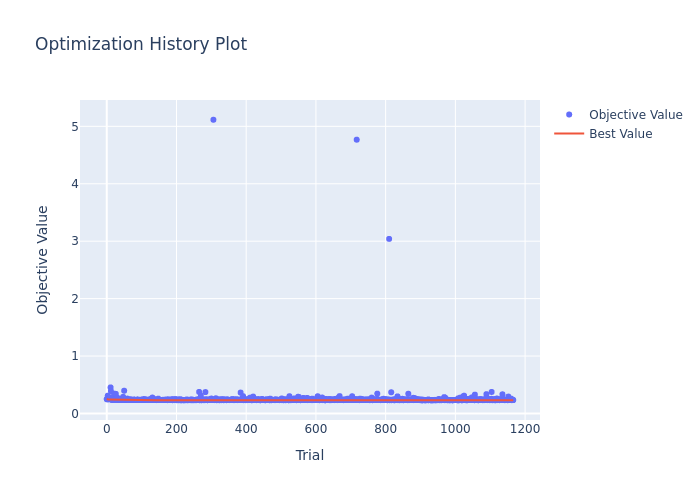

In [12]:
plot_optimization_history(study)

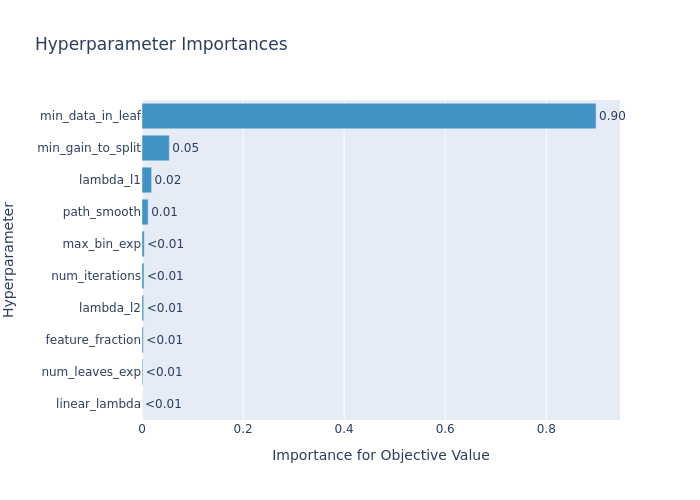

In [13]:
plot_param_importances(study)

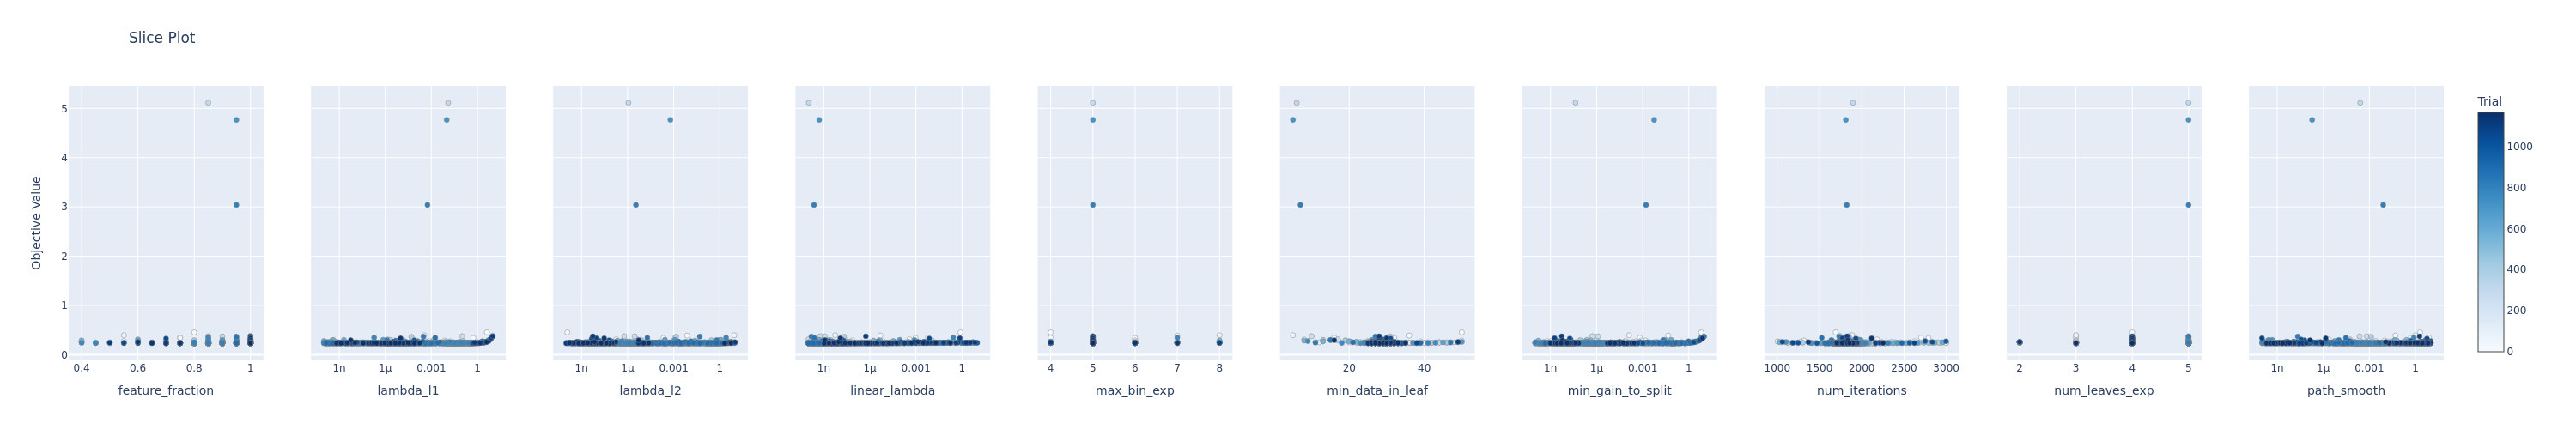

In [14]:
plot_slice(study)

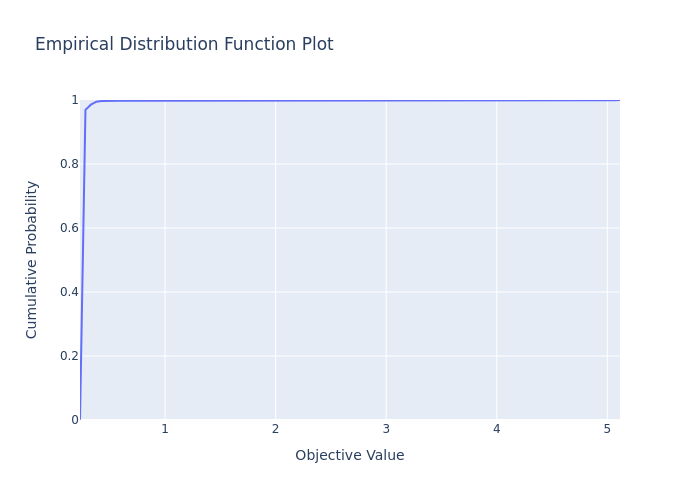

In [15]:
plot_edf(study)

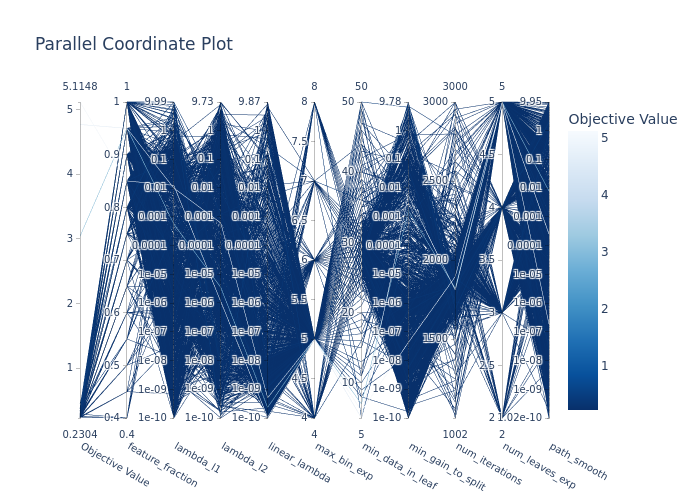

In [16]:
plot_parallel_coordinate(study)

In [17]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'linear_tree': True,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604,
 'feature_fraction': 0.8500000000000001,
 'lambda_l1': 1.882514072161519e-07,
 'lambda_l2': 0.47310656156097364,
 'linear_lambda': 1.6136340709412249e-10,
 'min_data_in_leaf': 29,
 'min_gain_to_split': 1.2401743751214779e-05,
 'num_iterations': 1790,
 'path_smooth': 7.124685345958355e-10,
 'max_bin': 31,
 'num_leaves': 31}

***